# Customer Churn Forecasting

In [1]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [2]:
from pyspark.sql.types import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
data = spark.read.csv('/CA1_customer_churn/customer_churn.csv', header=True)

In [4]:
data.show(5)

+-------------+---------+--------------------+--------------+--------------+----------------+----------------+-----------------------+---------+-----------+------+---+--------------+-----+
|Call  Failure|Complains|Subscription  Length|Charge  Amount|Seconds of Use|Frequency of use|Frequency of SMS|Distinct Called Numbers|Age Group|Tariff Plan|Status|Age|Customer Value|Churn|
+-------------+---------+--------------------+--------------+--------------+----------------+----------------+-----------------------+---------+-----------+------+---+--------------+-----+
|            8|        0|                  38|             0|          4370|              71|               5|                     17|        3|          1|     1| 30|        197.64|    0|
|            0|        0|                  39|             0|           318|               5|               7|                      4|        2|          1|     2| 25|        46.035|    0|
|           10|        0|                  37|         

In [5]:
data.limit(10).toPandas()

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.64,0
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035,0
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.52,0
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.02,0
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805,0
5,11,0,38,1,3775,82,32,28,3,1,1,30,282.28,0
6,4,0,38,0,2360,39,285,18,3,1,1,30,1235.96,0
7,13,0,37,2,9115,121,144,43,3,1,1,30,945.44,0
8,7,0,38,0,13773,169,0,44,3,1,1,30,557.68,0
9,7,0,38,1,4515,83,2,25,3,1,1,30,191.92,0


ANN vs RNN (Recurrent neural networks)

## EDA

In [6]:
data.columns

['Call  Failure',
 'Complains',
 'Subscription  Length',
 'Charge  Amount',
 'Seconds of Use',
 'Frequency of use',
 'Frequency of SMS',
 'Distinct Called Numbers',
 'Age Group',
 'Tariff Plan',
 'Status',
 'Age',
 'Customer Value',
 'Churn']

In [7]:
data.count()

3150

In [8]:
data.describe().show()

+-------+-----------------+-------------------+--------------------+------------------+------------------+------------------+------------------+-----------------------+------------------+-------------------+-------------------+------------------+------------------+-------------------+
|summary|    Call  Failure|          Complains|Subscription  Length|    Charge  Amount|    Seconds of Use|  Frequency of use|  Frequency of SMS|Distinct Called Numbers|         Age Group|        Tariff Plan|             Status|               Age|    Customer Value|              Churn|
+-------+-----------------+-------------------+--------------------+------------------+------------------+------------------+------------------+-----------------------+------------------+-------------------+-------------------+------------------+------------------+-------------------+
|  count|             3150|               3150|                3150|              3150|              3150|              3150|              315

## Exploratory Data Analysis

In [9]:
data = data.toPandas()
df = pd.DataFrame(data)

df

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.64,0
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035,0
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.52,0
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.02,0
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3145,21,0,19,2,6697,147,92,44,2,2,1,25,721.98,0
3146,17,0,17,1,9237,177,80,42,5,1,1,55,261.21,0
3147,13,0,18,4,3157,51,38,21,3,1,1,30,280.32,0
3148,7,0,11,2,4695,46,222,12,3,1,1,30,1077.64,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Call  Failure            3150 non-null   object
 1   Complains                3150 non-null   object
 2   Subscription  Length     3150 non-null   object
 3   Charge  Amount           3150 non-null   object
 4   Seconds of Use           3150 non-null   object
 5   Frequency of use         3150 non-null   object
 6   Frequency of SMS         3150 non-null   object
 7   Distinct Called Numbers  3150 non-null   object
 8   Age Group                3150 non-null   object
 9   Tariff Plan              3150 non-null   object
 10  Status                   3150 non-null   object
 11  Age                      3150 non-null   object
 12  Customer Value           3150 non-null   object
 13  Churn                    3150 non-null   object
dtypes: object(14)
memory usage: 344.7+ KB


In [11]:
# Convert from string object to float
df[df.columns.tolist()] = df[df.columns.tolist()].astype(float)

In [12]:
import numpy as np
df.describe(include = 'all')

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
count,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000
mean,7.627937,0.076508,32.541905,0.942857,4472.459683,69.460635,73.174921,23.509841,2.826032,1.077778,1.248254,30.998413,470.972916,0.157143
std,7.263886,0.265851,8.573482,1.521072,4197.908687,57.413308,112.237560,17.217337,0.892555,0.267864,0.432069,8.831095,517.015433,0.363993
min,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,15.000000,0.000000,0.000000
25%,1.000000,0.000000,30.000000,0.000000,1391.250000,27.000000,6.000000,10.000000,2.000000,1.000000,1.000000,25.000000,113.801250,0.000000
50%,6.000000,0.000000,35.000000,0.000000,2990.000000,54.000000,21.000000,21.000000,3.000000,1.000000,1.000000,30.000000,228.480000,0.000000
75%,12.000000,0.000000,38.000000,1.000000,6478.250000,95.000000,87.000000,34.000000,3.000000,1.000000,1.000000,30.000000,788.388750,0.000000
max,36.000000,1.000000,47.000000,10.000000,17090.000000,255.000000,522.000000,97.000000,5.000000,2.000000,2.000000,55.000000,2165.280000,1.000000


In [13]:
df.isnull().sum(axis = 0)

Call  Failure              0
Complains                  0
Subscription  Length       0
Charge  Amount             0
Seconds of Use             0
Frequency of use           0
Frequency of SMS           0
Distinct Called Numbers    0
Age Group                  0
Tariff Plan                0
Status                     0
Age                        0
Customer Value             0
Churn                      0
dtype: int64

0.0    2655
1.0     495
Name: Churn, dtype: int64

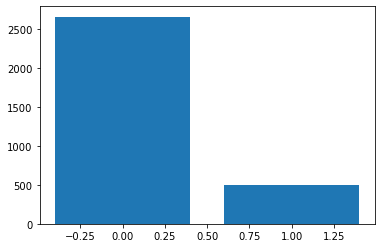

In [14]:
plt.bar(df['Churn'].unique(), df['Churn'].value_counts())
df.Churn.value_counts()

## Correlation Matrix

In [15]:
corr = df.corr() 
cm = sns.diverging_palette(220, 20, sep=20, as_cmap=True) 
corr.style.background_gradient(cmap=cm , axis=None).set_precision(2)

# Fill diagonal and upper half with NaNs
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null('#f1f1f1')  # Color NaNs grey
 .format(precision=2))

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
Call Failure,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Complains,0.15,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Subscription Length,0.17,-0.02,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Charge Amount,0.59,-0.03,0.08,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Seconds of Use,0.50,-0.10,0.12,0.45,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Frequency of use,0.57,-0.09,0.11,0.38,0.95,nan,nan,nan,nan,nan,nan,nan,nan,nan
Frequency of SMS,-0.02,-0.11,0.08,0.09,0.10,0.10,nan,nan,nan,nan,nan,nan,nan,nan
Distinct Called Numbers,0.50,-0.06,0.09,0.42,0.68,0.74,0.08,nan,nan,nan,nan,nan,nan,nan
Age Group,0.05,0.02,0.02,0.28,0.02,-0.03,-0.05,0.02,nan,nan,nan,nan,nan,nan
Tariff Plan,0.19,0.00,-0.16,0.32,0.13,0.21,0.20,0.17,-0.15,nan,nan,nan,nan,nan


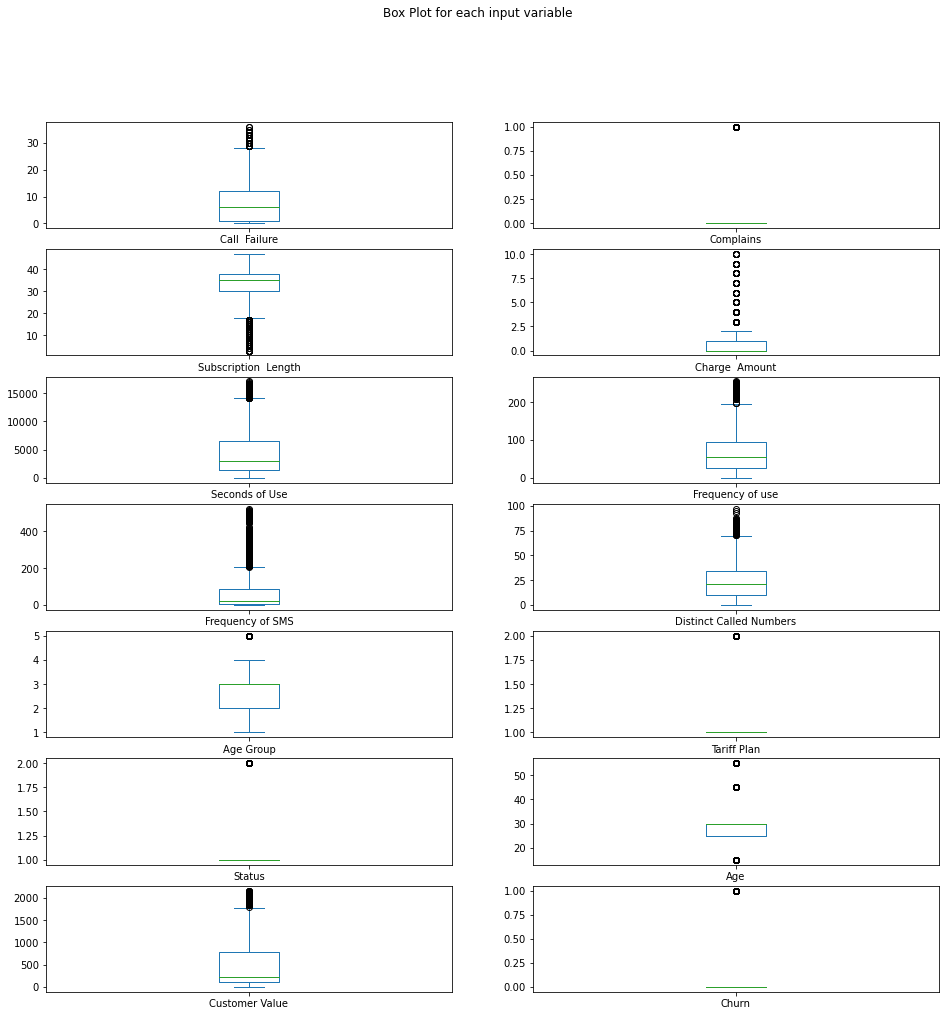

In [16]:
df.plot(kind='box', subplots=True, layout= (7,2), sharex=False, sharey=False, figsize=(16,16), title='Box Plot for each input variable')
plt.show()

<AxesSubplot:xlabel='Subscription  Length', ylabel='Density'>

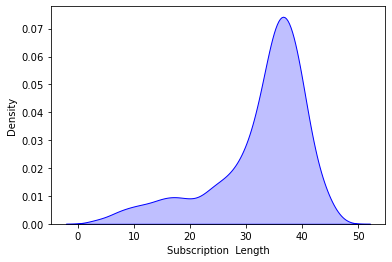

In [17]:
sns.kdeplot(data=df, x='Subscription  Length', color='b', shade=True)

<AxesSubplot:xlabel='Charge  Amount', ylabel='Density'>

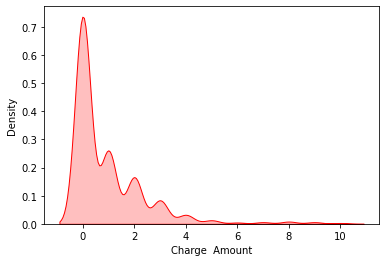

In [18]:
sns.kdeplot(data=df, x='Charge  Amount', color='r', shade=True)

<AxesSubplot:xlabel='Customer Value', ylabel='Density'>

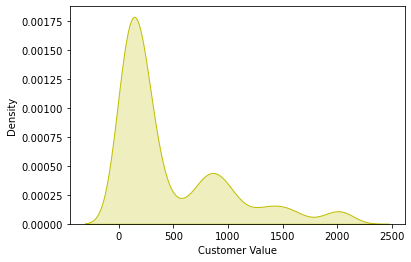

In [19]:
sns.kdeplot(data=df, x='Customer Value', color='y', shade=True)

<AxesSubplot:xlabel='Complains', ylabel='Density'>

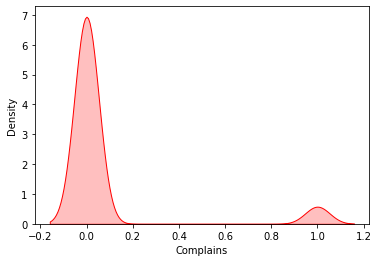

In [20]:
sns.kdeplot(data=df, x='Complains', color='r', shade=True)

<AxesSubplot:xlabel='Status', ylabel='Density'>

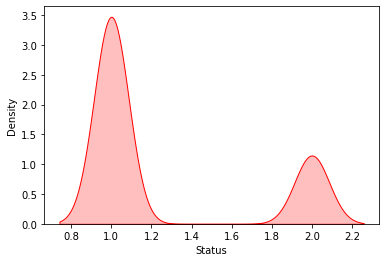

In [21]:
sns.kdeplot(data=df, x='Status', color='r', shade=True)

In [22]:
df.Status.describe()

count    3150.000000
mean        1.248254
std         0.432069
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         2.000000
Name: Status, dtype: float64

In [23]:
df.Complains.describe()

count    3150.000000
mean        0.076508
std         0.265851
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: Complains, dtype: float64

In [24]:
df_stat = df[(df['Status'] >= 1.8) & (df['Complains'] >= 0.8)]
df_stat 

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
22,23.0,1.0,33.0,0.0,955.0,47.0,16.0,17.0,2.0,1.0,2.0,25.0,117.090,1.0
27,9.0,1.0,36.0,0.0,2268.0,44.0,34.0,31.0,3.0,1.0,2.0,30.0,228.480,1.0
31,0.0,1.0,36.0,0.0,628.0,7.0,9.0,4.0,4.0,1.0,2.0,45.0,38.375,1.0
111,6.0,1.0,36.0,0.0,2178.0,51.0,3.0,15.0,3.0,1.0,2.0,30.0,101.160,0.0
127,6.0,1.0,34.0,0.0,2208.0,41.0,29.0,29.0,3.0,1.0,2.0,30.0,205.960,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3076,14.0,1.0,37.0,0.0,3295.0,47.0,16.0,18.0,3.0,1.0,2.0,30.0,197.680,1.0
3122,28.0,1.0,35.0,0.0,1260.0,53.0,23.0,19.0,3.0,1.0,2.0,30.0,144.520,1.0
3126,14.0,1.0,37.0,0.0,3295.0,47.0,16.0,18.0,3.0,1.0,2.0,30.0,197.680,1.0
3127,14.0,1.0,38.0,0.0,2573.0,50.0,41.0,33.0,4.0,1.0,2.0,45.0,168.075,1.0


1.0    141
0.0     17
Name: Churn, dtype: int64

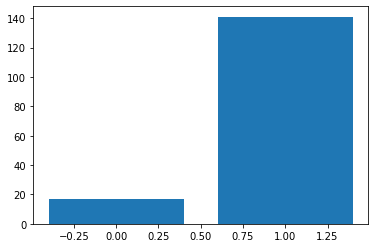

In [25]:
plt.bar(df_stat['Churn'].unique(), df_stat['Churn'].value_counts())
df_stat.Churn.value_counts()

In [26]:
(141/495 ) * 100

28.484848484848484

### 28.5% of All churn is linked to a customer complaint. Addressing the causes of the complaints would retain these customer. As there is no narrative data on the complaint it is uncertain at this stage what are the causes. The scope of using spark will allow for the scaling of the analytics platform to accomodate narrative data in the future and be able to integrate NLP to address the reasons for the complaints.

In [27]:
df_stat = df[(df['Status'] >= 1.8) & (df_stat['Complains'] >= 0.8) & (df_stat['Churn'] == 1)]
df_stat

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
22,23.0,1.0,33.0,0.0,955.0,47.0,16.0,17.0,2.0,1.0,2.0,25.0,117.090,1.0
27,9.0,1.0,36.0,0.0,2268.0,44.0,34.0,31.0,3.0,1.0,2.0,30.0,228.480,1.0
31,0.0,1.0,36.0,0.0,628.0,7.0,9.0,4.0,4.0,1.0,2.0,45.0,38.375,1.0
127,6.0,1.0,34.0,0.0,2208.0,41.0,29.0,29.0,3.0,1.0,2.0,30.0,205.960,1.0
128,0.0,1.0,34.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,2.0,30.0,0.000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3076,14.0,1.0,37.0,0.0,3295.0,47.0,16.0,18.0,3.0,1.0,2.0,30.0,197.680,1.0
3122,28.0,1.0,35.0,0.0,1260.0,53.0,23.0,19.0,3.0,1.0,2.0,30.0,144.520,1.0
3126,14.0,1.0,37.0,0.0,3295.0,47.0,16.0,18.0,3.0,1.0,2.0,30.0,197.680,1.0
3127,14.0,1.0,38.0,0.0,2573.0,50.0,41.0,33.0,4.0,1.0,2.0,45.0,168.075,1.0


In [28]:
df_stat.describe()

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
count,141.000000,141.0,141.000000,141.0,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.0,141.000000,141.000000,141.0
mean,11.595745,1.0,34.900709,0.0,1783.886525,36.517730,20.843972,17.943262,2.921986,1.007092,2.0,31.453901,145.909894,1.0
std,9.546861,0.0,5.208928,0.0,1122.282541,19.496008,17.476631,11.387821,0.666236,0.084215,0.0,6.801759,86.846298,0.0
min,0.000000,1.0,5.000000,0.0,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,2.0,25.000000,0.000000,1.0
25%,4.000000,1.0,33.000000,0.0,910.000000,25.000000,7.000000,10.000000,2.000000,1.000000,2.0,25.000000,79.640000,1.0
50%,10.000000,1.0,35.000000,0.0,1960.000000,42.000000,18.000000,18.000000,3.000000,1.000000,2.0,30.000000,154.160000,1.0
75%,18.000000,1.0,38.000000,0.0,2685.000000,51.000000,31.000000,25.000000,3.000000,1.000000,2.0,30.000000,206.100000,1.0
max,34.000000,1.0,44.000000,0.0,4005.000000,64.000000,73.000000,46.000000,4.000000,2.000000,2.0,45.000000,336.880000,1.0


In [29]:
df.describe()

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
count,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000
mean,7.627937,0.076508,32.541905,0.942857,4472.459683,69.460635,73.174921,23.509841,2.826032,1.077778,1.248254,30.998413,470.972916,0.157143
std,7.263886,0.265851,8.573482,1.521072,4197.908687,57.413308,112.237560,17.217337,0.892555,0.267864,0.432069,8.831095,517.015433,0.363993
min,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,15.000000,0.000000,0.000000
25%,1.000000,0.000000,30.000000,0.000000,1391.250000,27.000000,6.000000,10.000000,2.000000,1.000000,1.000000,25.000000,113.801250,0.000000
50%,6.000000,0.000000,35.000000,0.000000,2990.000000,54.000000,21.000000,21.000000,3.000000,1.000000,1.000000,30.000000,228.480000,0.000000
75%,12.000000,0.000000,38.000000,1.000000,6478.250000,95.000000,87.000000,34.000000,3.000000,1.000000,1.000000,30.000000,788.388750,0.000000
max,36.000000,1.000000,47.000000,10.000000,17090.000000,255.000000,522.000000,97.000000,5.000000,2.000000,2.000000,55.000000,2165.280000,1.000000


In [30]:
df_stat.Age.value_counts()

30.0    78
25.0    37
45.0    26
Name: Age, dtype: int64

In [31]:
df_stat['Tariff Plan'].value_counts()

1.0    140
2.0      1
Name: Tariff Plan, dtype: int64

### While we do not have access to narrative data from which to draw insights. We can get an understanding of the nature of the complains fromt he existing data.

- Age Group: 25-45 years old (81.5% of complains come from 25-35 year old age category)
- Tarrif Plan: 99% of complaints exist on Pay-as-you-go plan
- Subscription Lenght: On average 35 months.
- Customer Value: Customers churned who were associated with a complaint were had an average Customer Value of 146 compared to the whole dataset average score of 470. This may seem like a low number, but when compared to the total churn data which has an average customer value score of 125, we can see that at the 50 percentile range the custoemr value score is 97 and jumps to 181 at the 75 percentile. In terms of capturing churned customers, those customer associated with a complaint actually represent the higher end of customer value.
- Frequency of SMS is the highest predictor of customer value, this is presuming that SMS carries the highest network charge and as a result drives up the company bottom line.

In [32]:
df_maxVal = df[df['Churn'] == 1]
df_maxVal

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
16,0.0,0.0,37.0,0.0,875.0,14.0,0.0,11.0,2.0,1.0,2.0,25.0,40.005,1.0
18,0.0,0.0,37.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,25.0,0.000,1.0
22,23.0,1.0,33.0,0.0,955.0,47.0,16.0,17.0,2.0,1.0,2.0,25.0,117.090,1.0
24,13.0,1.0,36.0,1.0,5818.0,98.0,26.0,24.0,2.0,1.0,1.0,25.0,383.220,1.0
26,9.0,0.0,35.0,0.0,2990.0,41.0,9.0,16.0,3.0,1.0,2.0,30.0,157.240,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3126,14.0,1.0,37.0,0.0,3295.0,47.0,16.0,18.0,3.0,1.0,2.0,30.0,197.680,1.0
3127,14.0,1.0,38.0,0.0,2573.0,50.0,41.0,33.0,4.0,1.0,2.0,45.0,168.075,1.0
3128,5.0,0.0,38.0,0.0,438.0,8.0,7.0,4.0,3.0,1.0,2.0,30.0,45.840,1.0
3131,5.0,1.0,38.0,0.0,933.0,13.0,16.0,6.0,4.0,1.0,2.0,45.0,63.650,1.0


In [33]:
df_maxVal.describe()

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
count,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.0
mean,7.476768,0.404040,31.894949,0.230303,1566.632323,29.133333,15.802020,12.391919,2.795960,1.012121,1.747475,30.636364,124.811414,1.0
std,7.831407,0.491202,9.469163,0.616483,1539.203365,26.323478,23.515289,10.867622,0.711945,0.109538,0.434900,6.886081,129.429850,0.0
min,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1.000000,25.000000,0.000000,1.0
25%,0.000000,0.000000,31.000000,0.000000,318.000000,6.000000,0.000000,2.000000,2.000000,1.000000,1.000000,25.000000,38.375000,1.0
50%,5.000000,0.000000,35.000000,0.000000,1182.000000,25.000000,9.000000,10.000000,3.000000,1.000000,2.000000,30.000000,96.840000,1.0
75%,11.000000,1.000000,37.000000,0.000000,2391.500000,45.500000,23.000000,20.000000,3.000000,1.000000,2.000000,30.000000,181.322500,1.0
max,34.000000,1.000000,45.000000,4.000000,6123.000000,100.000000,204.000000,48.000000,5.000000,2.000000,2.000000,55.000000,987.255000,1.0


In [34]:
df_maxVal.sort_values('Customer Value',ascending=False).head(25)

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
388,6.0,1.0,30.0,1.0,1495.0,44.0,204.0,16.0,2.0,2.0,1.0,25.0,987.255,1.0
688,6.0,1.0,27.0,1.0,1505.0,37.0,202.0,14.0,2.0,2.0,1.0,25.0,978.390,1.0
988,4.0,1.0,27.0,1.0,1315.0,36.0,193.0,11.0,2.0,2.0,1.0,25.0,929.295,1.0
1088,0.0,1.0,25.0,0.0,1010.0,30.0,186.0,9.0,2.0,2.0,1.0,25.0,883.800,1.0
838,6.0,1.0,32.0,2.0,1315.0,42.0,201.0,12.0,3.0,2.0,1.0,30.0,858.280,1.0
1624,8.0,1.0,35.0,1.0,5628.0,98.0,51.0,26.0,2.0,1.0,1.0,25.0,487.170,1.0
674,15.0,0.0,36.0,1.0,6008.0,99.0,35.0,27.0,2.0,1.0,1.0,25.0,432.315,1.0
174,14.0,0.0,40.0,2.0,5898.0,100.0,36.0,28.0,2.0,1.0,1.0,25.0,431.910,1.0
1424,10.0,0.0,37.0,0.0,5693.0,100.0,30.0,27.0,2.0,1.0,1.0,25.0,395.685,1.0
2874,16.0,0.0,33.0,1.0,6123.0,98.0,25.0,25.0,2.0,1.0,1.0,25.0,392.445,1.0


## Data Modelling

In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense


2024-04-06 20:52:34.975124: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-06 20:52:35.323086: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-06 20:52:35.323202: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-06 20:52:35.400952: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-06 20:52:35.542043: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-06 20:52:35.543742: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [180]:
y = df['Churn']
X = df.drop('Churn',axis=1)

In [181]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [182]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [183]:
# check the shape of X_train & X_test, y_train & y_test
print("X_train Shape : ", X_train.shape)
print("X_test Shape : ", X_test.shape)
print("y_train Shape : ", y_train.shape)
print("y_test Shape : ", y_test.shape)

X_train Shape :  (2520, 13)
X_test Shape :  (630, 13)
y_train Shape :  (2520,)
y_test Shape :  (630,)


best - 0.9634920634920635 <keras.src.optimizers.adagrad.Adagrad object at 0x79b65e5248e0> 7

In [41]:
best_acc = 0
best_opt = None
best_mid_layer = None

for i in range(13):
    model = Sequential()
    model.add(Dense(units=13, activation='relu', input_dim=13))
    model.add(Dense(units=i+1, activation='relu', input_dim=i+1))
    model.add(Dense(units=1, activation='sigmoid'))
    
    optimizers = [keras.optimizers.RMSprop(),
                  'adam',
                  keras.optimizers.AdamW(),
                  keras.optimizers.Nadam(),
                  keras.optimizers.Adamax(), 
                  keras.optimizers.Adagrad(), 
                  keras.optimizers.Adadelta(), 
                  keras.optimizers.Adafactor(), 
                  keras.optimizers.Ftrl(), 
                  keras.optimizers.Lion(),
                  keras.optimizers.SGD()]
    for k in range(len(optimizers)):
        model.compile(loss='binary_crossentropy', optimizer= optimizers[k] , metrics=['accuracy'])
        model.fit(X_train_scaled, y_train, epochs = 100, validation_split=0.2)
        y_log = model.predict(X_test_scaled)
        y_pred = np.where(y_log > 0.5, 1, 0)
        curr_acc = accuracy_score(y_test, y_pred)
        
        if curr_acc > best_acc:
            best_mid_layer = i
            best_opt = optimizers[k]
            best_acc = curr_acc
            
print(best_acc , best_opt, best_mid_layer)

Epoch 1/100
63/63 [==============================] - 1s 5ms/step - loss: 0.6265 - accuracy: 0.8452 - val_loss: 0.5689 - val_accuracy: 0.8532
Epoch 2/100
63/63 [==============================] - 0s 2ms/step - loss: 0.5119 - accuracy: 0.8452 - val_loss: 0.4568 - val_accuracy: 0.8532
Epoch 3/100
63/63 [==============================] - 0s 2ms/step - loss: 0.4114 - accuracy: 0.8452 - val_loss: 0.3672 - val_accuracy: 0.8532
Epoch 4/100
63/63 [==============================] - 0s 2ms/step - loss: 0.3421 - accuracy: 0.8452 - val_loss: 0.3140 - val_accuracy: 0.8532
Epoch 5/100
63/63 [==============================] - 0s 3ms/step - loss: 0.3006 - accuracy: 0.8452 - val_loss: 0.2843 - val_accuracy: 0.8532
Epoch 6/100
63/63 [==============================] - 0s 3ms/step - loss: 0.2773 - accuracy: 0.8452 - val_loss: 0.2683 - val_accuracy: 0.8532
Epoch 7/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2644 - accuracy: 0.8452 - val_loss: 0.2589 - val_accuracy: 0.8532
Epoch 8/100
6

Epoch 59/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1895 - accuracy: 0.9216 - val_loss: 0.1978 - val_accuracy: 0.9147
Epoch 60/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1885 - accuracy: 0.9236 - val_loss: 0.1971 - val_accuracy: 0.9147
Epoch 61/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1872 - accuracy: 0.9256 - val_loss: 0.1959 - val_accuracy: 0.9107
Epoch 62/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1862 - accuracy: 0.9206 - val_loss: 0.1950 - val_accuracy: 0.9187
Epoch 63/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1856 - accuracy: 0.9221 - val_loss: 0.1948 - val_accuracy: 0.9206
Epoch 64/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1841 - accuracy: 0.9221 - val_loss: 0.1933 - val_accuracy: 0.9187
Epoch 65/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1827 - accuracy: 0.9226 - val_loss: 0.1947 - val_accuracy: 0.9167
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.1439 - accuracy: 0.9425 - val_loss: 0.1569 - val_accuracy: 0.9425
Epoch 17/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1415 - accuracy: 0.9444 - val_loss: 0.1576 - val_accuracy: 0.9405
Epoch 18/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1405 - accuracy: 0.9439 - val_loss: 0.1563 - val_accuracy: 0.9385
Epoch 19/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1399 - accuracy: 0.9430 - val_loss: 0.1552 - val_accuracy: 0.9385
Epoch 20/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1385 - accuracy: 0.9449 - val_loss: 0.1569 - val_accuracy: 0.9365
Epoch 21/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1383 - accuracy: 0.9444 - val_loss: 0.1560 - val_accuracy: 0.9365
Epoch 22/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1373 - accuracy: 0.9420 - val_loss: 0.1529 - val_accuracy: 0.9425
Epoch 23/100
63/63 

Epoch 74/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1132 - accuracy: 0.9578 - val_loss: 0.1419 - val_accuracy: 0.9504
Epoch 75/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1130 - accuracy: 0.9603 - val_loss: 0.1404 - val_accuracy: 0.9524
Epoch 76/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1123 - accuracy: 0.9603 - val_loss: 0.1435 - val_accuracy: 0.9544
Epoch 77/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1117 - accuracy: 0.9603 - val_loss: 0.1405 - val_accuracy: 0.9524
Epoch 78/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1121 - accuracy: 0.9583 - val_loss: 0.1411 - val_accuracy: 0.9464
Epoch 79/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1112 - accuracy: 0.9578 - val_loss: 0.1398 - val_accuracy: 0.9544
Epoch 80/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1114 - accuracy: 0.9598 - val_loss: 0.1411 - val_accuracy: 0.9524
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.1010 - accuracy: 0.9603 - val_loss: 0.1385 - val_accuracy: 0.9484
Epoch 32/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1026 - accuracy: 0.9623 - val_loss: 0.1442 - val_accuracy: 0.9464
Epoch 33/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1030 - accuracy: 0.9598 - val_loss: 0.1407 - val_accuracy: 0.9464
Epoch 34/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1017 - accuracy: 0.9618 - val_loss: 0.1400 - val_accuracy: 0.9504
Epoch 35/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1020 - accuracy: 0.9628 - val_loss: 0.1415 - val_accuracy: 0.9464
Epoch 36/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1017 - accuracy: 0.9613 - val_loss: 0.1450 - val_accuracy: 0.9524
Epoch 37/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1010 - accuracy: 0.9633 - val_loss: 0.1399 - val_accuracy: 0.9464
Epoch 38/100
63/63 

Epoch 89/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0979 - accuracy: 0.9623 - val_loss: 0.1391 - val_accuracy: 0.9484
Epoch 90/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0968 - accuracy: 0.9633 - val_loss: 0.1390 - val_accuracy: 0.9484
Epoch 91/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0984 - accuracy: 0.9623 - val_loss: 0.1426 - val_accuracy: 0.9563
Epoch 92/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0987 - accuracy: 0.9643 - val_loss: 0.1379 - val_accuracy: 0.9544
Epoch 93/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0983 - accuracy: 0.9623 - val_loss: 0.1384 - val_accuracy: 0.9504
Epoch 94/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0995 - accuracy: 0.9593 - val_loss: 0.1439 - val_accuracy: 0.9563
Epoch 95/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0984 - accuracy: 0.9638 - val_loss: 0.1425 - val_accuracy: 0.9544
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.0962 - accuracy: 0.9618 - val_loss: 0.1404 - val_accuracy: 0.9544
Epoch 47/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0954 - accuracy: 0.9628 - val_loss: 0.1439 - val_accuracy: 0.9444
Epoch 48/100
63/63 [==============================] - 0s 3ms/step - loss: 0.0950 - accuracy: 0.9663 - val_loss: 0.1386 - val_accuracy: 0.9544
Epoch 49/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0951 - accuracy: 0.9658 - val_loss: 0.1408 - val_accuracy: 0.9484
Epoch 50/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0952 - accuracy: 0.9618 - val_loss: 0.1423 - val_accuracy: 0.9524
Epoch 51/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0954 - accuracy: 0.9633 - val_loss: 0.1399 - val_accuracy: 0.9524
Epoch 52/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0955 - accuracy: 0.9633 - val_loss: 0.1392 - val_accuracy: 0.9484
Epoch 53/100
63/63 

63/63 [==============================] - 0s 2ms/step - loss: 0.0915 - accuracy: 0.9658 - val_loss: 0.1420 - val_accuracy: 0.9524
Epoch 4/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0914 - accuracy: 0.9643 - val_loss: 0.1413 - val_accuracy: 0.9484
Epoch 5/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0908 - accuracy: 0.9663 - val_loss: 0.1409 - val_accuracy: 0.9484
Epoch 6/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0909 - accuracy: 0.9653 - val_loss: 0.1412 - val_accuracy: 0.9504
Epoch 7/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0908 - accuracy: 0.9658 - val_loss: 0.1412 - val_accuracy: 0.9544
Epoch 8/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0912 - accuracy: 0.9638 - val_loss: 0.1410 - val_accuracy: 0.9484
Epoch 9/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0909 - accuracy: 0.9653 - val_loss: 0.1417 - val_accuracy: 0.9524
Epoch 10/100
63/63 [=====

Epoch 61/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0905 - accuracy: 0.9653 - val_loss: 0.1433 - val_accuracy: 0.9484
Epoch 62/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0902 - accuracy: 0.9673 - val_loss: 0.1427 - val_accuracy: 0.9464
Epoch 63/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0918 - accuracy: 0.9623 - val_loss: 0.1436 - val_accuracy: 0.9504
Epoch 64/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0904 - accuracy: 0.9668 - val_loss: 0.1426 - val_accuracy: 0.9464
Epoch 65/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0905 - accuracy: 0.9653 - val_loss: 0.1427 - val_accuracy: 0.9464
Epoch 66/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0906 - accuracy: 0.9658 - val_loss: 0.1432 - val_accuracy: 0.9484
Epoch 67/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0906 - accuracy: 0.9658 - val_loss: 0.1428 - val_accuracy: 0.9464
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.0891 - accuracy: 0.9663 - val_loss: 0.1443 - val_accuracy: 0.9464
Epoch 19/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0891 - accuracy: 0.9663 - val_loss: 0.1443 - val_accuracy: 0.9464
Epoch 20/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0891 - accuracy: 0.9668 - val_loss: 0.1443 - val_accuracy: 0.9464
Epoch 21/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0891 - accuracy: 0.9668 - val_loss: 0.1443 - val_accuracy: 0.9464
Epoch 22/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0891 - accuracy: 0.9663 - val_loss: 0.1443 - val_accuracy: 0.9464
Epoch 23/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0891 - accuracy: 0.9668 - val_loss: 0.1443 - val_accuracy: 0.9464
Epoch 24/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0891 - accuracy: 0.9668 - val_loss: 0.1443 - val_accuracy: 0.9464
Epoch 25/100
63/63 

Epoch 76/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0890 - accuracy: 0.9668 - val_loss: 0.1444 - val_accuracy: 0.9464
Epoch 77/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0890 - accuracy: 0.9668 - val_loss: 0.1444 - val_accuracy: 0.9464
Epoch 78/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0890 - accuracy: 0.9673 - val_loss: 0.1444 - val_accuracy: 0.9464
Epoch 79/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0890 - accuracy: 0.9663 - val_loss: 0.1444 - val_accuracy: 0.9464
Epoch 80/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0890 - accuracy: 0.9668 - val_loss: 0.1444 - val_accuracy: 0.9464
Epoch 81/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0890 - accuracy: 0.9673 - val_loss: 0.1444 - val_accuracy: 0.9464
Epoch 82/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0890 - accuracy: 0.9668 - val_loss: 0.1444 - val_accuracy: 0.9464
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.0889 - accuracy: 0.9668 - val_loss: 0.1445 - val_accuracy: 0.9464
Epoch 34/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0889 - accuracy: 0.9668 - val_loss: 0.1445 - val_accuracy: 0.9464
Epoch 35/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0889 - accuracy: 0.9668 - val_loss: 0.1445 - val_accuracy: 0.9464
Epoch 36/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0889 - accuracy: 0.9668 - val_loss: 0.1445 - val_accuracy: 0.9464
Epoch 37/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0889 - accuracy: 0.9668 - val_loss: 0.1445 - val_accuracy: 0.9464
Epoch 38/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0889 - accuracy: 0.9668 - val_loss: 0.1445 - val_accuracy: 0.9464
Epoch 39/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0889 - accuracy: 0.9668 - val_loss: 0.1445 - val_accuracy: 0.9464
Epoch 40/100
63/63 

Epoch 91/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0889 - accuracy: 0.9668 - val_loss: 0.1445 - val_accuracy: 0.9464
Epoch 92/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0889 - accuracy: 0.9668 - val_loss: 0.1445 - val_accuracy: 0.9464
Epoch 93/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0889 - accuracy: 0.9668 - val_loss: 0.1445 - val_accuracy: 0.9464
Epoch 94/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0889 - accuracy: 0.9668 - val_loss: 0.1445 - val_accuracy: 0.9464
Epoch 95/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0889 - accuracy: 0.9668 - val_loss: 0.1445 - val_accuracy: 0.9464
Epoch 96/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0889 - accuracy: 0.9668 - val_loss: 0.1445 - val_accuracy: 0.9464
Epoch 97/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0889 - accuracy: 0.9668 - val_loss: 0.1445 - val_accuracy: 0.9464
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.0903 - accuracy: 0.9688 - val_loss: 0.1641 - val_accuracy: 0.9504
Epoch 49/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0906 - accuracy: 0.9658 - val_loss: 0.1632 - val_accuracy: 0.9444
Epoch 50/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0910 - accuracy: 0.9653 - val_loss: 0.1624 - val_accuracy: 0.9504
Epoch 51/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0912 - accuracy: 0.9663 - val_loss: 0.1626 - val_accuracy: 0.9464
Epoch 52/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0901 - accuracy: 0.9678 - val_loss: 0.1628 - val_accuracy: 0.9464
Epoch 53/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0903 - accuracy: 0.9663 - val_loss: 0.1623 - val_accuracy: 0.9444
Epoch 54/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0907 - accuracy: 0.9663 - val_loss: 0.1624 - val_accuracy: 0.9464
Epoch 55/100
63/63 

63/63 [==============================] - 0s 2ms/step - loss: 0.6844 - accuracy: 0.8452 - val_loss: 0.6836 - val_accuracy: 0.8532
Epoch 6/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6832 - accuracy: 0.8452 - val_loss: 0.6824 - val_accuracy: 0.8532
Epoch 7/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6821 - accuracy: 0.8452 - val_loss: 0.6812 - val_accuracy: 0.8532
Epoch 8/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6810 - accuracy: 0.8452 - val_loss: 0.6802 - val_accuracy: 0.8532
Epoch 9/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6800 - accuracy: 0.8452 - val_loss: 0.6792 - val_accuracy: 0.8532
Epoch 10/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6791 - accuracy: 0.8452 - val_loss: 0.6783 - val_accuracy: 0.8532
Epoch 11/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6782 - accuracy: 0.8452 - val_loss: 0.6774 - val_accuracy: 0.8532
Epoch 12/100
63/63 [===

Epoch 63/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6484 - accuracy: 0.8452 - val_loss: 0.6471 - val_accuracy: 0.8532
Epoch 64/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6479 - accuracy: 0.8452 - val_loss: 0.6466 - val_accuracy: 0.8532
Epoch 65/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6475 - accuracy: 0.8452 - val_loss: 0.6462 - val_accuracy: 0.8532
Epoch 66/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6470 - accuracy: 0.8452 - val_loss: 0.6457 - val_accuracy: 0.8532
Epoch 67/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6466 - accuracy: 0.8452 - val_loss: 0.6453 - val_accuracy: 0.8532
Epoch 68/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6461 - accuracy: 0.8452 - val_loss: 0.6448 - val_accuracy: 0.8532
Epoch 69/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6457 - accuracy: 0.8452 - val_loss: 0.6443 - val_accuracy: 0.8532
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.5179 - accuracy: 0.8452 - val_loss: 0.5120 - val_accuracy: 0.8532
Epoch 21/100
63/63 [==============================] - 0s 2ms/step - loss: 0.5100 - accuracy: 0.8452 - val_loss: 0.5040 - val_accuracy: 0.8532
Epoch 22/100
63/63 [==============================] - 0s 2ms/step - loss: 0.5021 - accuracy: 0.8452 - val_loss: 0.4959 - val_accuracy: 0.8532
Epoch 23/100
63/63 [==============================] - 0s 2ms/step - loss: 0.4940 - accuracy: 0.8452 - val_loss: 0.4877 - val_accuracy: 0.8532
Epoch 24/100
63/63 [==============================] - 0s 2ms/step - loss: 0.4859 - accuracy: 0.8452 - val_loss: 0.4796 - val_accuracy: 0.8532
Epoch 25/100
63/63 [==============================] - 0s 2ms/step - loss: 0.4778 - accuracy: 0.8452 - val_loss: 0.4714 - val_accuracy: 0.8532
Epoch 26/100
63/63 [==============================] - 0s 2ms/step - loss: 0.4697 - accuracy: 0.8452 - val_loss: 0.4632 - val_accuracy: 0.8532
Epoch 27/100
63/63 

Epoch 78/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2546 - accuracy: 0.8452 - val_loss: 0.2563 - val_accuracy: 0.8532
Epoch 79/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2534 - accuracy: 0.8452 - val_loss: 0.2552 - val_accuracy: 0.8532
Epoch 80/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2522 - accuracy: 0.8452 - val_loss: 0.2542 - val_accuracy: 0.8532
Epoch 81/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2511 - accuracy: 0.8452 - val_loss: 0.2533 - val_accuracy: 0.8532
Epoch 82/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2500 - accuracy: 0.8452 - val_loss: 0.2523 - val_accuracy: 0.8532
Epoch 83/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2490 - accuracy: 0.8452 - val_loss: 0.2513 - val_accuracy: 0.8532
Epoch 84/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2481 - accuracy: 0.8452 - val_loss: 0.2504 - val_accuracy: 0.8532
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.2073 - accuracy: 0.9216 - val_loss: 0.2177 - val_accuracy: 0.9107
Epoch 36/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2068 - accuracy: 0.9226 - val_loss: 0.2173 - val_accuracy: 0.9107
Epoch 37/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2062 - accuracy: 0.9236 - val_loss: 0.2169 - val_accuracy: 0.9107
Epoch 38/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2057 - accuracy: 0.9231 - val_loss: 0.2166 - val_accuracy: 0.9107
Epoch 39/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2051 - accuracy: 0.9236 - val_loss: 0.2162 - val_accuracy: 0.9107
Epoch 40/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2046 - accuracy: 0.9241 - val_loss: 0.2159 - val_accuracy: 0.9107
Epoch 41/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2041 - accuracy: 0.9256 - val_loss: 0.2156 - val_accuracy: 0.9107
Epoch 42/100
63/63 

Epoch 93/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1821 - accuracy: 0.9291 - val_loss: 0.2027 - val_accuracy: 0.9167
Epoch 94/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1817 - accuracy: 0.9301 - val_loss: 0.2025 - val_accuracy: 0.9167
Epoch 95/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1814 - accuracy: 0.9286 - val_loss: 0.2023 - val_accuracy: 0.9187
Epoch 96/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1811 - accuracy: 0.9266 - val_loss: 0.2021 - val_accuracy: 0.9187
Epoch 97/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1808 - accuracy: 0.9281 - val_loss: 0.2019 - val_accuracy: 0.9187
Epoch 98/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1799 - accuracy: 0.9291 - val_loss: 0.2022 - val_accuracy: 0.9067
Epoch 99/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1801 - accuracy: 0.9301 - val_loss: 0.2015 - val_accuracy: 0.9167
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.2080 - accuracy: 0.9355 - val_loss: 0.2265 - val_accuracy: 0.9246
Epoch 51/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2062 - accuracy: 0.9340 - val_loss: 0.2251 - val_accuracy: 0.9206
Epoch 52/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2048 - accuracy: 0.9325 - val_loss: 0.2234 - val_accuracy: 0.9266
Epoch 53/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2032 - accuracy: 0.9335 - val_loss: 0.2233 - val_accuracy: 0.9206
Epoch 54/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2017 - accuracy: 0.9360 - val_loss: 0.2216 - val_accuracy: 0.9206
Epoch 55/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2005 - accuracy: 0.9355 - val_loss: 0.2203 - val_accuracy: 0.9206
Epoch 56/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1987 - accuracy: 0.9335 - val_loss: 0.2191 - val_accuracy: 0.9266
Epoch 57/100
63/63 

63/63 [==============================] - 0s 2ms/step - loss: 0.1586 - accuracy: 0.9474 - val_loss: 0.1876 - val_accuracy: 0.9306
Epoch 8/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1574 - accuracy: 0.9469 - val_loss: 0.1882 - val_accuracy: 0.9246
Epoch 9/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1570 - accuracy: 0.9479 - val_loss: 0.1872 - val_accuracy: 0.9246
Epoch 10/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1578 - accuracy: 0.9449 - val_loss: 0.1873 - val_accuracy: 0.9167
Epoch 11/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1567 - accuracy: 0.9454 - val_loss: 0.1850 - val_accuracy: 0.9266
Epoch 12/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1552 - accuracy: 0.9474 - val_loss: 0.1850 - val_accuracy: 0.9226
Epoch 13/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1548 - accuracy: 0.9469 - val_loss: 0.1846 - val_accuracy: 0.9266
Epoch 14/100
63/63 [=

Epoch 65/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1344 - accuracy: 0.9559 - val_loss: 0.1720 - val_accuracy: 0.9286
Epoch 66/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1346 - accuracy: 0.9568 - val_loss: 0.1728 - val_accuracy: 0.9306
Epoch 67/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1341 - accuracy: 0.9539 - val_loss: 0.1723 - val_accuracy: 0.9286
Epoch 68/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1355 - accuracy: 0.9559 - val_loss: 0.1721 - val_accuracy: 0.9286
Epoch 69/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1343 - accuracy: 0.9554 - val_loss: 0.1721 - val_accuracy: 0.9286
Epoch 70/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1337 - accuracy: 0.9568 - val_loss: 0.1704 - val_accuracy: 0.9365
Epoch 71/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1334 - accuracy: 0.9549 - val_loss: 0.1714 - val_accuracy: 0.9325
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.1261 - accuracy: 0.9573 - val_loss: 0.1730 - val_accuracy: 0.9246
Epoch 23/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1266 - accuracy: 0.9554 - val_loss: 0.1741 - val_accuracy: 0.9306
Epoch 24/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1253 - accuracy: 0.9578 - val_loss: 0.1754 - val_accuracy: 0.9246
Epoch 25/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1259 - accuracy: 0.9568 - val_loss: 0.1745 - val_accuracy: 0.9266
Epoch 26/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1259 - accuracy: 0.9578 - val_loss: 0.1721 - val_accuracy: 0.9286
Epoch 27/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1255 - accuracy: 0.9613 - val_loss: 0.1735 - val_accuracy: 0.9246
Epoch 28/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1259 - accuracy: 0.9559 - val_loss: 0.1743 - val_accuracy: 0.9345
Epoch 29/100
63/63 

Epoch 80/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1209 - accuracy: 0.9638 - val_loss: 0.1775 - val_accuracy: 0.9246
Epoch 81/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1208 - accuracy: 0.9618 - val_loss: 0.1748 - val_accuracy: 0.9306
Epoch 82/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1199 - accuracy: 0.9628 - val_loss: 0.1765 - val_accuracy: 0.9345
Epoch 83/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1215 - accuracy: 0.9603 - val_loss: 0.1756 - val_accuracy: 0.9266
Epoch 84/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1214 - accuracy: 0.9603 - val_loss: 0.1728 - val_accuracy: 0.9345
Epoch 85/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1195 - accuracy: 0.9643 - val_loss: 0.1786 - val_accuracy: 0.9365
Epoch 86/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1220 - accuracy: 0.9598 - val_loss: 0.1771 - val_accuracy: 0.9306
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.1178 - accuracy: 0.9648 - val_loss: 0.1786 - val_accuracy: 0.9345
Epoch 38/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1180 - accuracy: 0.9628 - val_loss: 0.1775 - val_accuracy: 0.9325
Epoch 39/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1181 - accuracy: 0.9613 - val_loss: 0.1735 - val_accuracy: 0.9325
Epoch 40/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1172 - accuracy: 0.9633 - val_loss: 0.1755 - val_accuracy: 0.9246
Epoch 41/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1169 - accuracy: 0.9618 - val_loss: 0.1796 - val_accuracy: 0.9306
Epoch 42/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1167 - accuracy: 0.9648 - val_loss: 0.1765 - val_accuracy: 0.9246
Epoch 43/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1177 - accuracy: 0.9648 - val_loss: 0.1729 - val_accuracy: 0.9266
Epoch 44/100
63/63 

Epoch 95/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1164 - accuracy: 0.9643 - val_loss: 0.1726 - val_accuracy: 0.9385
Epoch 96/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1143 - accuracy: 0.9643 - val_loss: 0.1753 - val_accuracy: 0.9365
Epoch 97/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1154 - accuracy: 0.9608 - val_loss: 0.1762 - val_accuracy: 0.9325
Epoch 98/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1142 - accuracy: 0.9648 - val_loss: 0.1781 - val_accuracy: 0.9385
Epoch 99/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1139 - accuracy: 0.9648 - val_loss: 0.1750 - val_accuracy: 0.9325
Epoch 100/100
20/20 [==============================] - 0s 917us/step
Epoch 1/100
63/63 [==============================] - 1s 3ms/step - loss: 0.1137 - accuracy: 0.9653 - val_loss: 0.1744 - val_accuracy: 0.9266
Epoch 2/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1132 

63/63 [==============================] - 0s 2ms/step - loss: 0.1124 - accuracy: 0.9653 - val_loss: 0.1740 - val_accuracy: 0.9365
Epoch 53/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1118 - accuracy: 0.9653 - val_loss: 0.1744 - val_accuracy: 0.9365
Epoch 54/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1117 - accuracy: 0.9643 - val_loss: 0.1749 - val_accuracy: 0.9365
Epoch 55/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1116 - accuracy: 0.9658 - val_loss: 0.1747 - val_accuracy: 0.9345
Epoch 56/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1118 - accuracy: 0.9658 - val_loss: 0.1754 - val_accuracy: 0.9345
Epoch 57/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1121 - accuracy: 0.9643 - val_loss: 0.1752 - val_accuracy: 0.9325
Epoch 58/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1122 - accuracy: 0.9638 - val_loss: 0.1746 - val_accuracy: 0.9444
Epoch 59/100
63/63 

63/63 [==============================] - 0s 2ms/step - loss: 0.1107 - accuracy: 0.9653 - val_loss: 0.1746 - val_accuracy: 0.9365
Epoch 10/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1107 - accuracy: 0.9653 - val_loss: 0.1746 - val_accuracy: 0.9365
Epoch 11/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1107 - accuracy: 0.9653 - val_loss: 0.1746 - val_accuracy: 0.9365
Epoch 12/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1106 - accuracy: 0.9653 - val_loss: 0.1746 - val_accuracy: 0.9365
Epoch 13/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1107 - accuracy: 0.9658 - val_loss: 0.1746 - val_accuracy: 0.9365
Epoch 14/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1106 - accuracy: 0.9663 - val_loss: 0.1746 - val_accuracy: 0.9365
Epoch 15/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1106 - accuracy: 0.9663 - val_loss: 0.1746 - val_accuracy: 0.9365
Epoch 16/100
63/63 

Epoch 67/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1105 - accuracy: 0.9663 - val_loss: 0.1746 - val_accuracy: 0.9365
Epoch 68/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1105 - accuracy: 0.9663 - val_loss: 0.1746 - val_accuracy: 0.9365
Epoch 69/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1105 - accuracy: 0.9663 - val_loss: 0.1746 - val_accuracy: 0.9365
Epoch 70/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1105 - accuracy: 0.9658 - val_loss: 0.1746 - val_accuracy: 0.9365
Epoch 71/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1105 - accuracy: 0.9663 - val_loss: 0.1746 - val_accuracy: 0.9365
Epoch 72/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1105 - accuracy: 0.9663 - val_loss: 0.1746 - val_accuracy: 0.9365
Epoch 73/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1105 - accuracy: 0.9663 - val_loss: 0.1746 - val_accuracy: 0.9365
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.1104 - accuracy: 0.9663 - val_loss: 0.1746 - val_accuracy: 0.9365
Epoch 25/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1104 - accuracy: 0.9663 - val_loss: 0.1746 - val_accuracy: 0.9365
Epoch 26/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1104 - accuracy: 0.9663 - val_loss: 0.1746 - val_accuracy: 0.9365
Epoch 27/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1104 - accuracy: 0.9663 - val_loss: 0.1746 - val_accuracy: 0.9365
Epoch 28/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1104 - accuracy: 0.9663 - val_loss: 0.1746 - val_accuracy: 0.9365
Epoch 29/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1104 - accuracy: 0.9663 - val_loss: 0.1746 - val_accuracy: 0.9365
Epoch 30/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1104 - accuracy: 0.9663 - val_loss: 0.1746 - val_accuracy: 0.9365
Epoch 31/100
63/63 

Epoch 82/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1104 - accuracy: 0.9663 - val_loss: 0.1746 - val_accuracy: 0.9365
Epoch 83/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1104 - accuracy: 0.9663 - val_loss: 0.1746 - val_accuracy: 0.9365
Epoch 84/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1104 - accuracy: 0.9663 - val_loss: 0.1746 - val_accuracy: 0.9365
Epoch 85/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1104 - accuracy: 0.9663 - val_loss: 0.1746 - val_accuracy: 0.9365
Epoch 86/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1104 - accuracy: 0.9663 - val_loss: 0.1746 - val_accuracy: 0.9365
Epoch 87/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1104 - accuracy: 0.9663 - val_loss: 0.1746 - val_accuracy: 0.9365
Epoch 88/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1104 - accuracy: 0.9663 - val_loss: 0.1746 - val_accuracy: 0.9365
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.1110 - accuracy: 0.9658 - val_loss: 0.1791 - val_accuracy: 0.9365
Epoch 40/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1110 - accuracy: 0.9683 - val_loss: 0.1810 - val_accuracy: 0.9325
Epoch 41/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1112 - accuracy: 0.9663 - val_loss: 0.1835 - val_accuracy: 0.9385
Epoch 42/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1111 - accuracy: 0.9663 - val_loss: 0.1843 - val_accuracy: 0.9345
Epoch 43/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1108 - accuracy: 0.9678 - val_loss: 0.1857 - val_accuracy: 0.9345
Epoch 44/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1115 - accuracy: 0.9668 - val_loss: 0.1831 - val_accuracy: 0.9385
Epoch 45/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1111 - accuracy: 0.9653 - val_loss: 0.1858 - val_accuracy: 0.9345
Epoch 46/100
63/63 

Epoch 97/100
63/63 [==============================] - 0s 3ms/step - loss: 0.1102 - accuracy: 0.9663 - val_loss: 0.1893 - val_accuracy: 0.9345
Epoch 98/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1097 - accuracy: 0.9678 - val_loss: 0.1915 - val_accuracy: 0.9345
Epoch 99/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1098 - accuracy: 0.9678 - val_loss: 0.1914 - val_accuracy: 0.9345
Epoch 100/100
20/20 [==============================] - 0s 832us/step
Epoch 1/100
63/63 [==============================] - 1s 3ms/step - loss: 0.6751 - accuracy: 0.8467 - val_loss: 0.6836 - val_accuracy: 0.8532
Epoch 2/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6827 - accuracy: 0.8452 - val_loss: 0.6814 - val_accuracy: 0.8532
Epoch 3/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6808 - accuracy: 0.8452 - val_loss: 0.6797 - val_accuracy: 0.8532
Epoch 4/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6793 - 

63/63 [==============================] - 0s 2ms/step - loss: 0.6522 - accuracy: 0.8452 - val_loss: 0.6511 - val_accuracy: 0.8532
Epoch 55/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6519 - accuracy: 0.8452 - val_loss: 0.6507 - val_accuracy: 0.8532
Epoch 56/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6516 - accuracy: 0.8452 - val_loss: 0.6504 - val_accuracy: 0.8532
Epoch 57/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6513 - accuracy: 0.8452 - val_loss: 0.6501 - val_accuracy: 0.8532
Epoch 58/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6510 - accuracy: 0.8452 - val_loss: 0.6498 - val_accuracy: 0.8532
Epoch 59/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6506 - accuracy: 0.8452 - val_loss: 0.6495 - val_accuracy: 0.8532
Epoch 60/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6503 - accuracy: 0.8452 - val_loss: 0.6491 - val_accuracy: 0.8532
Epoch 61/100
63/63 

63/63 [==============================] - 0s 2ms/step - loss: 0.6202 - accuracy: 0.8452 - val_loss: 0.6174 - val_accuracy: 0.8532
Epoch 12/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6184 - accuracy: 0.8452 - val_loss: 0.6155 - val_accuracy: 0.8532
Epoch 13/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6165 - accuracy: 0.8452 - val_loss: 0.6137 - val_accuracy: 0.8532
Epoch 14/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6148 - accuracy: 0.8452 - val_loss: 0.6119 - val_accuracy: 0.8532
Epoch 15/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6130 - accuracy: 0.8452 - val_loss: 0.6100 - val_accuracy: 0.8532
Epoch 16/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6112 - accuracy: 0.8452 - val_loss: 0.6082 - val_accuracy: 0.8532
Epoch 17/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6095 - accuracy: 0.8452 - val_loss: 0.6064 - val_accuracy: 0.8532
Epoch 18/100
63/63 

Epoch 69/100
63/63 [==============================] - 0s 2ms/step - loss: 0.5311 - accuracy: 0.8452 - val_loss: 0.5258 - val_accuracy: 0.8532
Epoch 70/100
63/63 [==============================] - 0s 2ms/step - loss: 0.5299 - accuracy: 0.8452 - val_loss: 0.5245 - val_accuracy: 0.8532
Epoch 71/100
63/63 [==============================] - 0s 2ms/step - loss: 0.5286 - accuracy: 0.8452 - val_loss: 0.5232 - val_accuracy: 0.8532
Epoch 72/100
63/63 [==============================] - 0s 2ms/step - loss: 0.5274 - accuracy: 0.8452 - val_loss: 0.5219 - val_accuracy: 0.8532
Epoch 73/100
63/63 [==============================] - 0s 2ms/step - loss: 0.5262 - accuracy: 0.8452 - val_loss: 0.5206 - val_accuracy: 0.8532
Epoch 74/100
63/63 [==============================] - 0s 2ms/step - loss: 0.5250 - accuracy: 0.8452 - val_loss: 0.5193 - val_accuracy: 0.8532
Epoch 75/100
63/63 [==============================] - 0s 2ms/step - loss: 0.5237 - accuracy: 0.8452 - val_loss: 0.5181 - val_accuracy: 0.8532
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.4314 - accuracy: 0.8452 - val_loss: 0.4185 - val_accuracy: 0.8532
Epoch 27/100
63/63 [==============================] - 0s 2ms/step - loss: 0.4313 - accuracy: 0.8452 - val_loss: 0.4184 - val_accuracy: 0.8532
Epoch 28/100
63/63 [==============================] - 0s 2ms/step - loss: 0.4312 - accuracy: 0.8452 - val_loss: 0.4183 - val_accuracy: 0.8532
Epoch 29/100
63/63 [==============================] - 0s 1ms/step - loss: 0.4312 - accuracy: 0.8452 - val_loss: 0.4182 - val_accuracy: 0.8532
Epoch 30/100
63/63 [==============================] - 0s 1ms/step - loss: 0.4311 - accuracy: 0.8452 - val_loss: 0.4181 - val_accuracy: 0.8532
Epoch 31/100
63/63 [==============================] - 0s 1ms/step - loss: 0.4311 - accuracy: 0.8452 - val_loss: 0.4180 - val_accuracy: 0.8532
Epoch 32/100
63/63 [==============================] - 0s 2ms/step - loss: 0.4311 - accuracy: 0.8452 - val_loss: 0.4180 - val_accuracy: 0.8532
Epoch 33/100
63/63 

Epoch 84/100
63/63 [==============================] - 0s 2ms/step - loss: 0.4309 - accuracy: 0.8452 - val_loss: 0.4174 - val_accuracy: 0.8532
Epoch 85/100
63/63 [==============================] - 0s 1ms/step - loss: 0.4309 - accuracy: 0.8452 - val_loss: 0.4174 - val_accuracy: 0.8532
Epoch 86/100
63/63 [==============================] - 0s 2ms/step - loss: 0.4309 - accuracy: 0.8452 - val_loss: 0.4174 - val_accuracy: 0.8532
Epoch 87/100
63/63 [==============================] - 0s 1ms/step - loss: 0.4309 - accuracy: 0.8452 - val_loss: 0.4174 - val_accuracy: 0.8532
Epoch 88/100
63/63 [==============================] - 0s 2ms/step - loss: 0.4309 - accuracy: 0.8452 - val_loss: 0.4174 - val_accuracy: 0.8532
Epoch 89/100
63/63 [==============================] - 0s 2ms/step - loss: 0.4309 - accuracy: 0.8452 - val_loss: 0.4174 - val_accuracy: 0.8532
Epoch 90/100
63/63 [==============================] - 0s 1ms/step - loss: 0.4309 - accuracy: 0.8452 - val_loss: 0.4174 - val_accuracy: 0.8532
Epoch 

63/63 [==============================] - 0s 1ms/step - loss: 0.2334 - accuracy: 0.9251 - val_loss: 0.2462 - val_accuracy: 0.9167
Epoch 42/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2299 - accuracy: 0.9251 - val_loss: 0.2434 - val_accuracy: 0.9206
Epoch 43/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2271 - accuracy: 0.9266 - val_loss: 0.2409 - val_accuracy: 0.9187
Epoch 44/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2250 - accuracy: 0.9286 - val_loss: 0.2382 - val_accuracy: 0.9167
Epoch 45/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2226 - accuracy: 0.9271 - val_loss: 0.2360 - val_accuracy: 0.9187
Epoch 46/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2200 - accuracy: 0.9271 - val_loss: 0.2339 - val_accuracy: 0.9167
Epoch 47/100
63/63 [==============================] - 0s 1ms/step - loss: 0.2178 - accuracy: 0.9271 - val_loss: 0.2328 - val_accuracy: 0.9147
Epoch 48/100
63/63 

Epoch 99/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1632 - accuracy: 0.9479 - val_loss: 0.1940 - val_accuracy: 0.9325
Epoch 100/100
20/20 [==============================] - 0s 1ms/step
Epoch 1/100
63/63 [==============================] - 1s 3ms/step - loss: 0.1629 - accuracy: 0.9489 - val_loss: 0.1915 - val_accuracy: 0.9325
Epoch 2/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1629 - accuracy: 0.9489 - val_loss: 0.1925 - val_accuracy: 0.9345
Epoch 3/100
63/63 [==============================] - 0s 1ms/step - loss: 0.1619 - accuracy: 0.9494 - val_loss: 0.1914 - val_accuracy: 0.9325
Epoch 4/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1610 - accuracy: 0.9494 - val_loss: 0.1945 - val_accuracy: 0.9286
Epoch 5/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1619 - accuracy: 0.9479 - val_loss: 0.1949 - val_accuracy: 0.9306
Epoch 6/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1609 - accu

63/63 [==============================] - 0s 1ms/step - loss: 0.1506 - accuracy: 0.9509 - val_loss: 0.1842 - val_accuracy: 0.9345
Epoch 57/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1506 - accuracy: 0.9514 - val_loss: 0.1850 - val_accuracy: 0.9345
Epoch 58/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1508 - accuracy: 0.9499 - val_loss: 0.1861 - val_accuracy: 0.9345
Epoch 59/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1501 - accuracy: 0.9519 - val_loss: 0.1895 - val_accuracy: 0.9325
Epoch 60/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1512 - accuracy: 0.9489 - val_loss: 0.1854 - val_accuracy: 0.9325
Epoch 61/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1492 - accuracy: 0.9519 - val_loss: 0.1844 - val_accuracy: 0.9325
Epoch 62/100
63/63 [==============================] - 0s 1ms/step - loss: 0.1492 - accuracy: 0.9544 - val_loss: 0.1888 - val_accuracy: 0.9325
Epoch 63/100
63/63 

63/63 [==============================] - 0s 2ms/step - loss: 0.1438 - accuracy: 0.9563 - val_loss: 0.1902 - val_accuracy: 0.9325
Epoch 14/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1455 - accuracy: 0.9534 - val_loss: 0.1816 - val_accuracy: 0.9345
Epoch 15/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1445 - accuracy: 0.9534 - val_loss: 0.1865 - val_accuracy: 0.9325
Epoch 16/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1438 - accuracy: 0.9549 - val_loss: 0.1808 - val_accuracy: 0.9345
Epoch 17/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1440 - accuracy: 0.9524 - val_loss: 0.1824 - val_accuracy: 0.9325
Epoch 18/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1439 - accuracy: 0.9534 - val_loss: 0.1844 - val_accuracy: 0.9306
Epoch 19/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1434 - accuracy: 0.9539 - val_loss: 0.1814 - val_accuracy: 0.9345
Epoch 20/100
63/63 

Epoch 71/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1403 - accuracy: 0.9583 - val_loss: 0.1793 - val_accuracy: 0.9345
Epoch 72/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1407 - accuracy: 0.9568 - val_loss: 0.1794 - val_accuracy: 0.9345
Epoch 73/100
63/63 [==============================] - 0s 1ms/step - loss: 0.1405 - accuracy: 0.9578 - val_loss: 0.1804 - val_accuracy: 0.9365
Epoch 74/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1406 - accuracy: 0.9588 - val_loss: 0.1787 - val_accuracy: 0.9405
Epoch 75/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1402 - accuracy: 0.9568 - val_loss: 0.1825 - val_accuracy: 0.9345
Epoch 76/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1395 - accuracy: 0.9583 - val_loss: 0.1806 - val_accuracy: 0.9325
Epoch 77/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1399 - accuracy: 0.9603 - val_loss: 0.1833 - val_accuracy: 0.9325
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.1365 - accuracy: 0.9623 - val_loss: 0.1808 - val_accuracy: 0.9365
Epoch 29/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1370 - accuracy: 0.9578 - val_loss: 0.1834 - val_accuracy: 0.9365
Epoch 30/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1369 - accuracy: 0.9608 - val_loss: 0.1761 - val_accuracy: 0.9365
Epoch 31/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1365 - accuracy: 0.9588 - val_loss: 0.1778 - val_accuracy: 0.9405
Epoch 32/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1361 - accuracy: 0.9588 - val_loss: 0.1780 - val_accuracy: 0.9345
Epoch 33/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1356 - accuracy: 0.9628 - val_loss: 0.1828 - val_accuracy: 0.9345
Epoch 34/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1358 - accuracy: 0.9598 - val_loss: 0.1764 - val_accuracy: 0.9365
Epoch 35/100
63/63 

Epoch 86/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1343 - accuracy: 0.9608 - val_loss: 0.1781 - val_accuracy: 0.9405
Epoch 87/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1347 - accuracy: 0.9628 - val_loss: 0.1805 - val_accuracy: 0.9405
Epoch 88/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1339 - accuracy: 0.9613 - val_loss: 0.1806 - val_accuracy: 0.9405
Epoch 89/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1335 - accuracy: 0.9628 - val_loss: 0.1797 - val_accuracy: 0.9405
Epoch 90/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1332 - accuracy: 0.9608 - val_loss: 0.1782 - val_accuracy: 0.9385
Epoch 91/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1342 - accuracy: 0.9638 - val_loss: 0.1776 - val_accuracy: 0.9385
Epoch 92/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1332 - accuracy: 0.9618 - val_loss: 0.1809 - val_accuracy: 0.9365
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.1311 - accuracy: 0.9638 - val_loss: 0.1760 - val_accuracy: 0.9425
Epoch 44/100
63/63 [==============================] - 0s 1ms/step - loss: 0.1309 - accuracy: 0.9643 - val_loss: 0.1762 - val_accuracy: 0.9365
Epoch 45/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1309 - accuracy: 0.9638 - val_loss: 0.1750 - val_accuracy: 0.9405
Epoch 46/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1311 - accuracy: 0.9623 - val_loss: 0.1760 - val_accuracy: 0.9464
Epoch 47/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1309 - accuracy: 0.9613 - val_loss: 0.1766 - val_accuracy: 0.9385
Epoch 48/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1313 - accuracy: 0.9623 - val_loss: 0.1767 - val_accuracy: 0.9405
Epoch 49/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1309 - accuracy: 0.9638 - val_loss: 0.1760 - val_accuracy: 0.9385
Epoch 50/100
63/63 

20/20 [==============================] - 0s 1ms/step
Epoch 1/100
63/63 [==============================] - 0s 3ms/step - loss: 0.1304 - accuracy: 0.9628 - val_loss: 0.1757 - val_accuracy: 0.9444
Epoch 2/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1300 - accuracy: 0.9643 - val_loss: 0.1756 - val_accuracy: 0.9444
Epoch 3/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1299 - accuracy: 0.9643 - val_loss: 0.1756 - val_accuracy: 0.9464
Epoch 4/100
63/63 [==============================] - 0s 1ms/step - loss: 0.1299 - accuracy: 0.9638 - val_loss: 0.1756 - val_accuracy: 0.9464
Epoch 5/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1298 - accuracy: 0.9653 - val_loss: 0.1756 - val_accuracy: 0.9464
Epoch 6/100
63/63 [==============================] - 0s 1ms/step - loss: 0.1299 - accuracy: 0.9658 - val_loss: 0.1755 - val_accuracy: 0.9464
Epoch 7/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1298 - accuracy: 0.9648 - 

63/63 [==============================] - 0s 1ms/step - loss: 0.1297 - accuracy: 0.9653 - val_loss: 0.1755 - val_accuracy: 0.9464
Epoch 59/100
63/63 [==============================] - 0s 1ms/step - loss: 0.1297 - accuracy: 0.9648 - val_loss: 0.1755 - val_accuracy: 0.9464
Epoch 60/100
63/63 [==============================] - 0s 1ms/step - loss: 0.1297 - accuracy: 0.9648 - val_loss: 0.1755 - val_accuracy: 0.9464
Epoch 61/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1297 - accuracy: 0.9653 - val_loss: 0.1755 - val_accuracy: 0.9464
Epoch 62/100
63/63 [==============================] - 0s 1ms/step - loss: 0.1297 - accuracy: 0.9653 - val_loss: 0.1755 - val_accuracy: 0.9464
Epoch 63/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1297 - accuracy: 0.9648 - val_loss: 0.1755 - val_accuracy: 0.9464
Epoch 64/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1297 - accuracy: 0.9648 - val_loss: 0.1756 - val_accuracy: 0.9464
Epoch 65/100
63/63 

63/63 [==============================] - 0s 2ms/step - loss: 0.1296 - accuracy: 0.9648 - val_loss: 0.1755 - val_accuracy: 0.9464
Epoch 16/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1296 - accuracy: 0.9648 - val_loss: 0.1755 - val_accuracy: 0.9464
Epoch 17/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1296 - accuracy: 0.9648 - val_loss: 0.1755 - val_accuracy: 0.9464
Epoch 18/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1296 - accuracy: 0.9648 - val_loss: 0.1755 - val_accuracy: 0.9464
Epoch 19/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1296 - accuracy: 0.9648 - val_loss: 0.1755 - val_accuracy: 0.9464
Epoch 20/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1296 - accuracy: 0.9648 - val_loss: 0.1755 - val_accuracy: 0.9464
Epoch 21/100
63/63 [==============================] - 0s 1ms/step - loss: 0.1296 - accuracy: 0.9648 - val_loss: 0.1755 - val_accuracy: 0.9464
Epoch 22/100
63/63 

Epoch 73/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1296 - accuracy: 0.9648 - val_loss: 0.1755 - val_accuracy: 0.9464
Epoch 74/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1296 - accuracy: 0.9648 - val_loss: 0.1755 - val_accuracy: 0.9464
Epoch 75/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1296 - accuracy: 0.9648 - val_loss: 0.1755 - val_accuracy: 0.9464
Epoch 76/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1296 - accuracy: 0.9648 - val_loss: 0.1755 - val_accuracy: 0.9464
Epoch 77/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1296 - accuracy: 0.9648 - val_loss: 0.1755 - val_accuracy: 0.9464
Epoch 78/100
63/63 [==============================] - 0s 1ms/step - loss: 0.1296 - accuracy: 0.9648 - val_loss: 0.1755 - val_accuracy: 0.9464
Epoch 79/100
63/63 [==============================] - 0s 1ms/step - loss: 0.1296 - accuracy: 0.9648 - val_loss: 0.1755 - val_accuracy: 0.9464
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 32/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 33/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 34/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 35/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 36/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 37/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 38/100
63/63 [==============================] - 0s 2ms/

63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 92/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 93/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 94/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 95/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 96/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 97/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 98/100
63/63 [==============================] - 0s 2ms/

Epoch 51/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 52/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 53/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 54/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 55/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 56/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 57/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 58/100
63/63 [============================

Epoch 11/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 12/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 13/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 14/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 15/100
63/63 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 16/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 17/100
63/63 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 18/100
63/63 [============================

63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 72/100
63/63 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 73/100
63/63 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 74/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 75/100
63/63 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 76/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 77/100
63/63 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 78/100
63/63 [==============================] - 0s 2ms/

63/63 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 32/100
63/63 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 33/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 34/100
63/63 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 35/100
63/63 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 36/100
63/63 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 37/100
63/63 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 38/100
63/63 [==============================] - 0s 1ms/

63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 92/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 93/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 94/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 95/100
63/63 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 96/100
63/63 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 97/100
63/63 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 98/100
63/63 [==============================] - 0s 2ms/

Epoch 49/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1568 - accuracy: 0.9340 - val_loss: 0.1849 - val_accuracy: 0.9206
Epoch 50/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1550 - accuracy: 0.9365 - val_loss: 0.1854 - val_accuracy: 0.9226
Epoch 51/100
63/63 [==============================] - 0s 1ms/step - loss: 0.1542 - accuracy: 0.9345 - val_loss: 0.1843 - val_accuracy: 0.9206
Epoch 52/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1535 - accuracy: 0.9345 - val_loss: 0.1829 - val_accuracy: 0.9206
Epoch 53/100
63/63 [==============================] - 0s 1ms/step - loss: 0.1505 - accuracy: 0.9355 - val_loss: 0.1841 - val_accuracy: 0.9187
Epoch 54/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1509 - accuracy: 0.9360 - val_loss: 0.1807 - val_accuracy: 0.9187
Epoch 55/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1498 - accuracy: 0.9355 - val_loss: 0.1800 - val_accuracy: 0.9226
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.1128 - accuracy: 0.9469 - val_loss: 0.1587 - val_accuracy: 0.9206
Epoch 7/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1126 - accuracy: 0.9469 - val_loss: 0.1587 - val_accuracy: 0.9187
Epoch 8/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1111 - accuracy: 0.9479 - val_loss: 0.1559 - val_accuracy: 0.9226
Epoch 9/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1113 - accuracy: 0.9474 - val_loss: 0.1579 - val_accuracy: 0.9246
Epoch 10/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1111 - accuracy: 0.9474 - val_loss: 0.1579 - val_accuracy: 0.9226
Epoch 11/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1099 - accuracy: 0.9489 - val_loss: 0.1562 - val_accuracy: 0.9226
Epoch 12/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1104 - accuracy: 0.9469 - val_loss: 0.1561 - val_accuracy: 0.9266
Epoch 13/100
63/63 [==

Epoch 64/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0920 - accuracy: 0.9603 - val_loss: 0.1557 - val_accuracy: 0.9345
Epoch 65/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0922 - accuracy: 0.9598 - val_loss: 0.1546 - val_accuracy: 0.9325
Epoch 66/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0913 - accuracy: 0.9608 - val_loss: 0.1523 - val_accuracy: 0.9306
Epoch 67/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0912 - accuracy: 0.9608 - val_loss: 0.1539 - val_accuracy: 0.9325
Epoch 68/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0908 - accuracy: 0.9623 - val_loss: 0.1572 - val_accuracy: 0.9345
Epoch 69/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0895 - accuracy: 0.9663 - val_loss: 0.1637 - val_accuracy: 0.9306
Epoch 70/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0895 - accuracy: 0.9658 - val_loss: 0.1535 - val_accuracy: 0.9365
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.0841 - accuracy: 0.9658 - val_loss: 0.1518 - val_accuracy: 0.9405
Epoch 22/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0825 - accuracy: 0.9633 - val_loss: 0.1493 - val_accuracy: 0.9405
Epoch 23/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0821 - accuracy: 0.9688 - val_loss: 0.1463 - val_accuracy: 0.9504
Epoch 24/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0834 - accuracy: 0.9648 - val_loss: 0.1490 - val_accuracy: 0.9425
Epoch 25/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0807 - accuracy: 0.9688 - val_loss: 0.1530 - val_accuracy: 0.9385
Epoch 26/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0823 - accuracy: 0.9658 - val_loss: 0.1500 - val_accuracy: 0.9385
Epoch 27/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0809 - accuracy: 0.9658 - val_loss: 0.1501 - val_accuracy: 0.9425
Epoch 28/100
63/63 

Epoch 79/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0775 - accuracy: 0.9692 - val_loss: 0.1478 - val_accuracy: 0.9425
Epoch 80/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0779 - accuracy: 0.9702 - val_loss: 0.1488 - val_accuracy: 0.9444
Epoch 81/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0766 - accuracy: 0.9702 - val_loss: 0.1451 - val_accuracy: 0.9385
Epoch 82/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0767 - accuracy: 0.9702 - val_loss: 0.1444 - val_accuracy: 0.9484
Epoch 83/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0753 - accuracy: 0.9702 - val_loss: 0.1495 - val_accuracy: 0.9464
Epoch 84/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0777 - accuracy: 0.9697 - val_loss: 0.1487 - val_accuracy: 0.9385
Epoch 85/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0773 - accuracy: 0.9683 - val_loss: 0.1418 - val_accuracy: 0.9524
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.0723 - accuracy: 0.9697 - val_loss: 0.1465 - val_accuracy: 0.9484
Epoch 37/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0733 - accuracy: 0.9717 - val_loss: 0.1466 - val_accuracy: 0.9464
Epoch 38/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0741 - accuracy: 0.9712 - val_loss: 0.1462 - val_accuracy: 0.9484
Epoch 39/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0725 - accuracy: 0.9707 - val_loss: 0.1450 - val_accuracy: 0.9524
Epoch 40/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0721 - accuracy: 0.9722 - val_loss: 0.1471 - val_accuracy: 0.9484
Epoch 41/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0725 - accuracy: 0.9722 - val_loss: 0.1473 - val_accuracy: 0.9444
Epoch 42/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0721 - accuracy: 0.9692 - val_loss: 0.1456 - val_accuracy: 0.9425
Epoch 43/100
63/63 

Epoch 94/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0693 - accuracy: 0.9742 - val_loss: 0.1492 - val_accuracy: 0.9464
Epoch 95/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0701 - accuracy: 0.9717 - val_loss: 0.1469 - val_accuracy: 0.9504
Epoch 96/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0696 - accuracy: 0.9717 - val_loss: 0.1476 - val_accuracy: 0.9484
Epoch 97/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0693 - accuracy: 0.9742 - val_loss: 0.1465 - val_accuracy: 0.9464
Epoch 98/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0711 - accuracy: 0.9702 - val_loss: 0.1483 - val_accuracy: 0.9504
Epoch 99/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0694 - accuracy: 0.9722 - val_loss: 0.1464 - val_accuracy: 0.9444
Epoch 100/100
20/20 [==============================] - 0s 758us/step
Epoch 1/100
63/63 [==============================] - 1s 3ms/step - loss: 0.0679

63/63 [==============================] - 0s 2ms/step - loss: 0.0662 - accuracy: 0.9747 - val_loss: 0.1459 - val_accuracy: 0.9484
Epoch 52/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0662 - accuracy: 0.9722 - val_loss: 0.1464 - val_accuracy: 0.9484
Epoch 53/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0666 - accuracy: 0.9727 - val_loss: 0.1461 - val_accuracy: 0.9484
Epoch 54/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0668 - accuracy: 0.9757 - val_loss: 0.1463 - val_accuracy: 0.9464
Epoch 55/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0662 - accuracy: 0.9762 - val_loss: 0.1457 - val_accuracy: 0.9504
Epoch 56/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0668 - accuracy: 0.9752 - val_loss: 0.1484 - val_accuracy: 0.9464
Epoch 57/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0664 - accuracy: 0.9727 - val_loss: 0.1460 - val_accuracy: 0.9425
Epoch 58/100
63/63 

63/63 [==============================] - 0s 1ms/step - loss: 0.0652 - accuracy: 0.9742 - val_loss: 0.1460 - val_accuracy: 0.9444
Epoch 9/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0652 - accuracy: 0.9752 - val_loss: 0.1460 - val_accuracy: 0.9464
Epoch 10/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0652 - accuracy: 0.9742 - val_loss: 0.1460 - val_accuracy: 0.9464
Epoch 11/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0651 - accuracy: 0.9757 - val_loss: 0.1459 - val_accuracy: 0.9444
Epoch 12/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0652 - accuracy: 0.9762 - val_loss: 0.1459 - val_accuracy: 0.9444
Epoch 13/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0651 - accuracy: 0.9752 - val_loss: 0.1459 - val_accuracy: 0.9444
Epoch 14/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0652 - accuracy: 0.9747 - val_loss: 0.1459 - val_accuracy: 0.9444
Epoch 15/100
63/63 [

Epoch 66/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0650 - accuracy: 0.9752 - val_loss: 0.1457 - val_accuracy: 0.9444
Epoch 67/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0650 - accuracy: 0.9757 - val_loss: 0.1457 - val_accuracy: 0.9444
Epoch 68/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0650 - accuracy: 0.9757 - val_loss: 0.1457 - val_accuracy: 0.9444
Epoch 69/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0650 - accuracy: 0.9757 - val_loss: 0.1457 - val_accuracy: 0.9444
Epoch 70/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0650 - accuracy: 0.9757 - val_loss: 0.1457 - val_accuracy: 0.9444
Epoch 71/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0650 - accuracy: 0.9757 - val_loss: 0.1457 - val_accuracy: 0.9444
Epoch 72/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0650 - accuracy: 0.9757 - val_loss: 0.1457 - val_accuracy: 0.9444
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.0649 - accuracy: 0.9757 - val_loss: 0.1456 - val_accuracy: 0.9444
Epoch 24/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0649 - accuracy: 0.9757 - val_loss: 0.1456 - val_accuracy: 0.9444
Epoch 25/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0649 - accuracy: 0.9757 - val_loss: 0.1456 - val_accuracy: 0.9444
Epoch 26/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0649 - accuracy: 0.9757 - val_loss: 0.1456 - val_accuracy: 0.9444
Epoch 27/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0649 - accuracy: 0.9757 - val_loss: 0.1456 - val_accuracy: 0.9444
Epoch 28/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0649 - accuracy: 0.9757 - val_loss: 0.1456 - val_accuracy: 0.9444
Epoch 29/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0649 - accuracy: 0.9757 - val_loss: 0.1456 - val_accuracy: 0.9444
Epoch 30/100
63/63 

Epoch 81/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0649 - accuracy: 0.9757 - val_loss: 0.1457 - val_accuracy: 0.9444
Epoch 82/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0649 - accuracy: 0.9757 - val_loss: 0.1457 - val_accuracy: 0.9444
Epoch 83/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0649 - accuracy: 0.9757 - val_loss: 0.1457 - val_accuracy: 0.9444
Epoch 84/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0649 - accuracy: 0.9757 - val_loss: 0.1457 - val_accuracy: 0.9444
Epoch 85/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0649 - accuracy: 0.9757 - val_loss: 0.1457 - val_accuracy: 0.9444
Epoch 86/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0649 - accuracy: 0.9757 - val_loss: 0.1457 - val_accuracy: 0.9444
Epoch 87/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0649 - accuracy: 0.9757 - val_loss: 0.1457 - val_accuracy: 0.9444
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.0654 - accuracy: 0.9732 - val_loss: 0.1508 - val_accuracy: 0.9484
Epoch 39/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0655 - accuracy: 0.9712 - val_loss: 0.1511 - val_accuracy: 0.9464
Epoch 40/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0662 - accuracy: 0.9742 - val_loss: 0.1533 - val_accuracy: 0.9504
Epoch 41/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0661 - accuracy: 0.9727 - val_loss: 0.1520 - val_accuracy: 0.9484
Epoch 42/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0663 - accuracy: 0.9717 - val_loss: 0.1519 - val_accuracy: 0.9464
Epoch 43/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0657 - accuracy: 0.9737 - val_loss: 0.1522 - val_accuracy: 0.9484
Epoch 44/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0651 - accuracy: 0.9742 - val_loss: 0.1527 - val_accuracy: 0.9544
Epoch 45/100
63/63 

Epoch 96/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0648 - accuracy: 0.9712 - val_loss: 0.1597 - val_accuracy: 0.9484
Epoch 97/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0653 - accuracy: 0.9737 - val_loss: 0.1599 - val_accuracy: 0.9504
Epoch 98/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0644 - accuracy: 0.9727 - val_loss: 0.1580 - val_accuracy: 0.9484
Epoch 99/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0654 - accuracy: 0.9737 - val_loss: 0.1578 - val_accuracy: 0.9524
Epoch 100/100
20/20 [==============================] - 0s 804us/step
Epoch 1/100
63/63 [==============================] - 1s 3ms/step - loss: 0.6805 - accuracy: 0.7941 - val_loss: 0.6893 - val_accuracy: 0.8532
Epoch 2/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6883 - accuracy: 0.8452 - val_loss: 0.6871 - val_accuracy: 0.8532
Epoch 3/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6864 -

63/63 [==============================] - 0s 2ms/step - loss: 0.6552 - accuracy: 0.8452 - val_loss: 0.6540 - val_accuracy: 0.8532
Epoch 54/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6547 - accuracy: 0.8452 - val_loss: 0.6536 - val_accuracy: 0.8532
Epoch 55/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6543 - accuracy: 0.8452 - val_loss: 0.6531 - val_accuracy: 0.8532
Epoch 56/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6539 - accuracy: 0.8452 - val_loss: 0.6527 - val_accuracy: 0.8532
Epoch 57/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6534 - accuracy: 0.8452 - val_loss: 0.6523 - val_accuracy: 0.8532
Epoch 58/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6530 - accuracy: 0.8452 - val_loss: 0.6518 - val_accuracy: 0.8532
Epoch 59/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6526 - accuracy: 0.8452 - val_loss: 0.6514 - val_accuracy: 0.8532
Epoch 60/100
63/63 

63/63 [==============================] - 0s 2ms/step - loss: 0.5945 - accuracy: 0.8452 - val_loss: 0.5895 - val_accuracy: 0.8532
Epoch 11/100
63/63 [==============================] - 0s 2ms/step - loss: 0.5874 - accuracy: 0.8452 - val_loss: 0.5822 - val_accuracy: 0.8532
Epoch 12/100
63/63 [==============================] - 0s 2ms/step - loss: 0.5797 - accuracy: 0.8452 - val_loss: 0.5744 - val_accuracy: 0.8532
Epoch 13/100
63/63 [==============================] - 0s 2ms/step - loss: 0.5716 - accuracy: 0.8452 - val_loss: 0.5660 - val_accuracy: 0.8532
Epoch 14/100
63/63 [==============================] - 0s 2ms/step - loss: 0.5628 - accuracy: 0.8452 - val_loss: 0.5570 - val_accuracy: 0.8532
Epoch 15/100
63/63 [==============================] - 0s 2ms/step - loss: 0.5535 - accuracy: 0.8452 - val_loss: 0.5476 - val_accuracy: 0.8532
Epoch 16/100
63/63 [==============================] - 0s 2ms/step - loss: 0.5438 - accuracy: 0.8452 - val_loss: 0.5378 - val_accuracy: 0.8532
Epoch 17/100
63/63 

Epoch 68/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2614 - accuracy: 0.8452 - val_loss: 0.2545 - val_accuracy: 0.8532
Epoch 69/100
63/63 [==============================] - 0s 1ms/step - loss: 0.2600 - accuracy: 0.8452 - val_loss: 0.2533 - val_accuracy: 0.8532
Epoch 70/100
63/63 [==============================] - 0s 1ms/step - loss: 0.2585 - accuracy: 0.8452 - val_loss: 0.2521 - val_accuracy: 0.8532
Epoch 71/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2573 - accuracy: 0.8452 - val_loss: 0.2510 - val_accuracy: 0.8532
Epoch 72/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2560 - accuracy: 0.8452 - val_loss: 0.2499 - val_accuracy: 0.8532
Epoch 73/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2550 - accuracy: 0.8452 - val_loss: 0.2490 - val_accuracy: 0.8532
Epoch 74/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2538 - accuracy: 0.8452 - val_loss: 0.2481 - val_accuracy: 0.8532
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.2221 - accuracy: 0.9003 - val_loss: 0.2267 - val_accuracy: 0.9067
Epoch 26/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2218 - accuracy: 0.8998 - val_loss: 0.2265 - val_accuracy: 0.9048
Epoch 27/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2215 - accuracy: 0.9003 - val_loss: 0.2263 - val_accuracy: 0.9008
Epoch 28/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2212 - accuracy: 0.9003 - val_loss: 0.2261 - val_accuracy: 0.9008
Epoch 29/100
63/63 [==============================] - 0s 1ms/step - loss: 0.2209 - accuracy: 0.8993 - val_loss: 0.2260 - val_accuracy: 0.9028
Epoch 30/100
63/63 [==============================] - 0s 1ms/step - loss: 0.2206 - accuracy: 0.8993 - val_loss: 0.2258 - val_accuracy: 0.9028
Epoch 31/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2203 - accuracy: 0.8998 - val_loss: 0.2256 - val_accuracy: 0.9048
Epoch 32/100
63/63 

Epoch 83/100
63/63 [==============================] - 0s 1ms/step - loss: 0.2084 - accuracy: 0.9117 - val_loss: 0.2196 - val_accuracy: 0.9048
Epoch 84/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2082 - accuracy: 0.9117 - val_loss: 0.2196 - val_accuracy: 0.9048
Epoch 85/100
63/63 [==============================] - 0s 1ms/step - loss: 0.2080 - accuracy: 0.9117 - val_loss: 0.2196 - val_accuracy: 0.9048
Epoch 86/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2079 - accuracy: 0.9137 - val_loss: 0.2195 - val_accuracy: 0.9048
Epoch 87/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2077 - accuracy: 0.9132 - val_loss: 0.2194 - val_accuracy: 0.9048
Epoch 88/100
63/63 [==============================] - 0s 1ms/step - loss: 0.2075 - accuracy: 0.9132 - val_loss: 0.2194 - val_accuracy: 0.9048
Epoch 89/100
63/63 [==============================] - 0s 1ms/step - loss: 0.2073 - accuracy: 0.9132 - val_loss: 0.2193 - val_accuracy: 0.9048
Epoch 

63/63 [==============================] - 0s 1ms/step - loss: 0.2215 - accuracy: 0.9286 - val_loss: 0.2394 - val_accuracy: 0.9167
Epoch 41/100
63/63 [==============================] - 0s 1ms/step - loss: 0.2185 - accuracy: 0.9266 - val_loss: 0.2367 - val_accuracy: 0.9167
Epoch 42/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2149 - accuracy: 0.9276 - val_loss: 0.2331 - val_accuracy: 0.9167
Epoch 43/100
63/63 [==============================] - 0s 1ms/step - loss: 0.2122 - accuracy: 0.9291 - val_loss: 0.2306 - val_accuracy: 0.9167
Epoch 44/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2092 - accuracy: 0.9286 - val_loss: 0.2273 - val_accuracy: 0.9167
Epoch 45/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2062 - accuracy: 0.9281 - val_loss: 0.2256 - val_accuracy: 0.9206
Epoch 46/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2038 - accuracy: 0.9296 - val_loss: 0.2231 - val_accuracy: 0.9187
Epoch 47/100
63/63 

Epoch 98/100
63/63 [==============================] - 0s 1ms/step - loss: 0.1399 - accuracy: 0.9519 - val_loss: 0.1691 - val_accuracy: 0.9325
Epoch 99/100
63/63 [==============================] - 0s 1ms/step - loss: 0.1400 - accuracy: 0.9499 - val_loss: 0.1666 - val_accuracy: 0.9325
Epoch 100/100
20/20 [==============================] - 0s 977us/step
Epoch 1/100
63/63 [==============================] - 1s 3ms/step - loss: 0.1383 - accuracy: 0.9539 - val_loss: 0.1666 - val_accuracy: 0.9306
Epoch 2/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1366 - accuracy: 0.9529 - val_loss: 0.1655 - val_accuracy: 0.9306
Epoch 3/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1364 - accuracy: 0.9529 - val_loss: 0.1646 - val_accuracy: 0.9306
Epoch 4/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1354 - accuracy: 0.9544 - val_loss: 0.1639 - val_accuracy: 0.9345
Epoch 5/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1348 - a

63/63 [==============================] - 0s 2ms/step - loss: 0.1083 - accuracy: 0.9573 - val_loss: 0.1386 - val_accuracy: 0.9365
Epoch 56/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1073 - accuracy: 0.9573 - val_loss: 0.1378 - val_accuracy: 0.9405
Epoch 57/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1074 - accuracy: 0.9563 - val_loss: 0.1392 - val_accuracy: 0.9365
Epoch 58/100
63/63 [==============================] - 0s 1ms/step - loss: 0.1061 - accuracy: 0.9568 - val_loss: 0.1372 - val_accuracy: 0.9385
Epoch 59/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1073 - accuracy: 0.9544 - val_loss: 0.1355 - val_accuracy: 0.9365
Epoch 60/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1045 - accuracy: 0.9563 - val_loss: 0.1364 - val_accuracy: 0.9325
Epoch 61/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1053 - accuracy: 0.9588 - val_loss: 0.1341 - val_accuracy: 0.9345
Epoch 62/100
63/63 

63/63 [==============================] - 0s 2ms/step - loss: 0.0860 - accuracy: 0.9653 - val_loss: 0.1218 - val_accuracy: 0.9405
Epoch 13/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0889 - accuracy: 0.9643 - val_loss: 0.1200 - val_accuracy: 0.9405
Epoch 14/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0856 - accuracy: 0.9663 - val_loss: 0.1242 - val_accuracy: 0.9385
Epoch 15/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0866 - accuracy: 0.9673 - val_loss: 0.1227 - val_accuracy: 0.9405
Epoch 16/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0868 - accuracy: 0.9653 - val_loss: 0.1224 - val_accuracy: 0.9405
Epoch 17/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0861 - accuracy: 0.9643 - val_loss: 0.1209 - val_accuracy: 0.9405
Epoch 18/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0856 - accuracy: 0.9643 - val_loss: 0.1192 - val_accuracy: 0.9444
Epoch 19/100
63/63 

Epoch 70/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0789 - accuracy: 0.9678 - val_loss: 0.1170 - val_accuracy: 0.9405
Epoch 71/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0784 - accuracy: 0.9697 - val_loss: 0.1295 - val_accuracy: 0.9365
Epoch 72/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0810 - accuracy: 0.9692 - val_loss: 0.1125 - val_accuracy: 0.9464
Epoch 73/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0802 - accuracy: 0.9658 - val_loss: 0.1146 - val_accuracy: 0.9504
Epoch 74/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0803 - accuracy: 0.9683 - val_loss: 0.1248 - val_accuracy: 0.9405
Epoch 75/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0788 - accuracy: 0.9688 - val_loss: 0.1187 - val_accuracy: 0.9504
Epoch 76/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0777 - accuracy: 0.9663 - val_loss: 0.1158 - val_accuracy: 0.9444
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.0729 - accuracy: 0.9692 - val_loss: 0.1156 - val_accuracy: 0.9464
Epoch 28/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0738 - accuracy: 0.9692 - val_loss: 0.1220 - val_accuracy: 0.9504
Epoch 29/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0737 - accuracy: 0.9697 - val_loss: 0.1191 - val_accuracy: 0.9425
Epoch 30/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0729 - accuracy: 0.9683 - val_loss: 0.1178 - val_accuracy: 0.9464
Epoch 31/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0730 - accuracy: 0.9712 - val_loss: 0.1147 - val_accuracy: 0.9504
Epoch 32/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0726 - accuracy: 0.9707 - val_loss: 0.1162 - val_accuracy: 0.9504
Epoch 33/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0724 - accuracy: 0.9732 - val_loss: 0.1212 - val_accuracy: 0.9504
Epoch 34/100
63/63 

Epoch 85/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0696 - accuracy: 0.9712 - val_loss: 0.1162 - val_accuracy: 0.9504
Epoch 86/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0699 - accuracy: 0.9732 - val_loss: 0.1145 - val_accuracy: 0.9484
Epoch 87/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0697 - accuracy: 0.9722 - val_loss: 0.1176 - val_accuracy: 0.9484
Epoch 88/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0699 - accuracy: 0.9717 - val_loss: 0.1154 - val_accuracy: 0.9444
Epoch 89/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0687 - accuracy: 0.9692 - val_loss: 0.1154 - val_accuracy: 0.9444
Epoch 90/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0688 - accuracy: 0.9737 - val_loss: 0.1139 - val_accuracy: 0.9484
Epoch 91/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0680 - accuracy: 0.9737 - val_loss: 0.1197 - val_accuracy: 0.9444
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.0654 - accuracy: 0.9772 - val_loss: 0.1133 - val_accuracy: 0.9484
Epoch 43/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0647 - accuracy: 0.9757 - val_loss: 0.1128 - val_accuracy: 0.9504
Epoch 44/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0648 - accuracy: 0.9767 - val_loss: 0.1125 - val_accuracy: 0.9504
Epoch 45/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0650 - accuracy: 0.9767 - val_loss: 0.1123 - val_accuracy: 0.9504
Epoch 46/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0650 - accuracy: 0.9772 - val_loss: 0.1136 - val_accuracy: 0.9484
Epoch 47/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0648 - accuracy: 0.9752 - val_loss: 0.1138 - val_accuracy: 0.9504
Epoch 48/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0656 - accuracy: 0.9772 - val_loss: 0.1137 - val_accuracy: 0.9484
Epoch 49/100
63/63 

Epoch 100/100
20/20 [==============================] - 0s 917us/step
Epoch 1/100
63/63 [==============================] - 0s 3ms/step - loss: 0.0640 - accuracy: 0.9762 - val_loss: 0.1138 - val_accuracy: 0.9504
Epoch 2/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0635 - accuracy: 0.9772 - val_loss: 0.1136 - val_accuracy: 0.9484
Epoch 3/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0635 - accuracy: 0.9777 - val_loss: 0.1136 - val_accuracy: 0.9484
Epoch 4/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0633 - accuracy: 0.9782 - val_loss: 0.1137 - val_accuracy: 0.9484
Epoch 5/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0633 - accuracy: 0.9777 - val_loss: 0.1136 - val_accuracy: 0.9484
Epoch 6/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0633 - accuracy: 0.9767 - val_loss: 0.1136 - val_accuracy: 0.9484
Epoch 7/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0632 - acc

63/63 [==============================] - 0s 2ms/step - loss: 0.0630 - accuracy: 0.9792 - val_loss: 0.1134 - val_accuracy: 0.9484
Epoch 58/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0630 - accuracy: 0.9792 - val_loss: 0.1134 - val_accuracy: 0.9484
Epoch 59/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0630 - accuracy: 0.9792 - val_loss: 0.1134 - val_accuracy: 0.9484
Epoch 60/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0630 - accuracy: 0.9792 - val_loss: 0.1134 - val_accuracy: 0.9484
Epoch 61/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0630 - accuracy: 0.9782 - val_loss: 0.1134 - val_accuracy: 0.9484
Epoch 62/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0630 - accuracy: 0.9792 - val_loss: 0.1134 - val_accuracy: 0.9484
Epoch 63/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0630 - accuracy: 0.9787 - val_loss: 0.1134 - val_accuracy: 0.9484
Epoch 64/100
63/63 

63/63 [==============================] - 0s 1ms/step - loss: 0.0629 - accuracy: 0.9792 - val_loss: 0.1133 - val_accuracy: 0.9484
Epoch 15/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0629 - accuracy: 0.9792 - val_loss: 0.1133 - val_accuracy: 0.9484
Epoch 16/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0629 - accuracy: 0.9792 - val_loss: 0.1133 - val_accuracy: 0.9484
Epoch 17/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0629 - accuracy: 0.9792 - val_loss: 0.1133 - val_accuracy: 0.9484
Epoch 18/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0629 - accuracy: 0.9792 - val_loss: 0.1133 - val_accuracy: 0.9484
Epoch 19/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0629 - accuracy: 0.9792 - val_loss: 0.1133 - val_accuracy: 0.9484
Epoch 20/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0629 - accuracy: 0.9792 - val_loss: 0.1133 - val_accuracy: 0.9484
Epoch 21/100
63/63 

Epoch 72/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0629 - accuracy: 0.9792 - val_loss: 0.1134 - val_accuracy: 0.9484
Epoch 73/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0629 - accuracy: 0.9792 - val_loss: 0.1134 - val_accuracy: 0.9484
Epoch 74/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0629 - accuracy: 0.9792 - val_loss: 0.1134 - val_accuracy: 0.9484
Epoch 75/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0629 - accuracy: 0.9792 - val_loss: 0.1134 - val_accuracy: 0.9484
Epoch 76/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0629 - accuracy: 0.9792 - val_loss: 0.1134 - val_accuracy: 0.9484
Epoch 77/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0629 - accuracy: 0.9792 - val_loss: 0.1134 - val_accuracy: 0.9484
Epoch 78/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0629 - accuracy: 0.9792 - val_loss: 0.1134 - val_accuracy: 0.9484
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.0641 - accuracy: 0.9732 - val_loss: 0.1175 - val_accuracy: 0.9484
Epoch 30/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0636 - accuracy: 0.9762 - val_loss: 0.1192 - val_accuracy: 0.9484
Epoch 31/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0642 - accuracy: 0.9762 - val_loss: 0.1190 - val_accuracy: 0.9524
Epoch 32/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0629 - accuracy: 0.9797 - val_loss: 0.1214 - val_accuracy: 0.9484
Epoch 33/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0639 - accuracy: 0.9782 - val_loss: 0.1213 - val_accuracy: 0.9504
Epoch 34/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0637 - accuracy: 0.9742 - val_loss: 0.1212 - val_accuracy: 0.9464
Epoch 35/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0637 - accuracy: 0.9757 - val_loss: 0.1198 - val_accuracy: 0.9484
Epoch 36/100
63/63 

Epoch 87/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0602 - accuracy: 0.9792 - val_loss: 0.1260 - val_accuracy: 0.9484
Epoch 88/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0620 - accuracy: 0.9807 - val_loss: 0.1249 - val_accuracy: 0.9464
Epoch 89/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0602 - accuracy: 0.9767 - val_loss: 0.1255 - val_accuracy: 0.9544
Epoch 90/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0617 - accuracy: 0.9747 - val_loss: 0.1233 - val_accuracy: 0.9464
Epoch 91/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0604 - accuracy: 0.9792 - val_loss: 0.1259 - val_accuracy: 0.9504
Epoch 92/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0600 - accuracy: 0.9792 - val_loss: 0.1247 - val_accuracy: 0.9484
Epoch 93/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0605 - accuracy: 0.9762 - val_loss: 0.1236 - val_accuracy: 0.9544
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.6307 - accuracy: 0.8452 - val_loss: 0.6290 - val_accuracy: 0.8532
Epoch 45/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6304 - accuracy: 0.8452 - val_loss: 0.6287 - val_accuracy: 0.8532
Epoch 46/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6301 - accuracy: 0.8452 - val_loss: 0.6283 - val_accuracy: 0.8532
Epoch 47/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6297 - accuracy: 0.8452 - val_loss: 0.6280 - val_accuracy: 0.8532
Epoch 48/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6294 - accuracy: 0.8452 - val_loss: 0.6277 - val_accuracy: 0.8532
Epoch 49/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6291 - accuracy: 0.8452 - val_loss: 0.6273 - val_accuracy: 0.8532
Epoch 50/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6288 - accuracy: 0.8452 - val_loss: 0.6270 - val_accuracy: 0.8532
Epoch 51/100
63/63 

63/63 [==============================] - 1s 3ms/step - loss: 0.6150 - accuracy: 0.8452 - val_loss: 0.6121 - val_accuracy: 0.8532
Epoch 2/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6132 - accuracy: 0.8452 - val_loss: 0.6103 - val_accuracy: 0.8532
Epoch 3/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6114 - accuracy: 0.8452 - val_loss: 0.6084 - val_accuracy: 0.8532
Epoch 4/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6097 - accuracy: 0.8452 - val_loss: 0.6066 - val_accuracy: 0.8532
Epoch 5/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6078 - accuracy: 0.8452 - val_loss: 0.6048 - val_accuracy: 0.8532
Epoch 6/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6061 - accuracy: 0.8452 - val_loss: 0.6029 - val_accuracy: 0.8532
Epoch 7/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6042 - accuracy: 0.8452 - val_loss: 0.6011 - val_accuracy: 0.8532
Epoch 8/100
63/63 [======

Epoch 59/100
63/63 [==============================] - 0s 2ms/step - loss: 0.4744 - accuracy: 0.9048 - val_loss: 0.4854 - val_accuracy: 0.8968
Epoch 60/100
63/63 [==============================] - 0s 2ms/step - loss: 0.4727 - accuracy: 0.9048 - val_loss: 0.4839 - val_accuracy: 0.8968
Epoch 61/100
63/63 [==============================] - 0s 2ms/step - loss: 0.4710 - accuracy: 0.9048 - val_loss: 0.4823 - val_accuracy: 0.8968
Epoch 62/100
63/63 [==============================] - 0s 1ms/step - loss: 0.4693 - accuracy: 0.9048 - val_loss: 0.4807 - val_accuracy: 0.8968
Epoch 63/100
63/63 [==============================] - 0s 2ms/step - loss: 0.4678 - accuracy: 0.9048 - val_loss: 0.4791 - val_accuracy: 0.8968
Epoch 64/100
63/63 [==============================] - 0s 2ms/step - loss: 0.4661 - accuracy: 0.9048 - val_loss: 0.4775 - val_accuracy: 0.8968
Epoch 65/100
63/63 [==============================] - 0s 2ms/step - loss: 0.4645 - accuracy: 0.9048 - val_loss: 0.4758 - val_accuracy: 0.8968
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.2698 - accuracy: 0.9077 - val_loss: 0.2850 - val_accuracy: 0.8968
Epoch 17/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2667 - accuracy: 0.9077 - val_loss: 0.2820 - val_accuracy: 0.8988
Epoch 18/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2636 - accuracy: 0.9062 - val_loss: 0.2792 - val_accuracy: 0.9008
Epoch 19/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2612 - accuracy: 0.9087 - val_loss: 0.2767 - val_accuracy: 0.9008
Epoch 20/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2588 - accuracy: 0.9082 - val_loss: 0.2744 - val_accuracy: 0.9008
Epoch 21/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2565 - accuracy: 0.9072 - val_loss: 0.2722 - val_accuracy: 0.9008
Epoch 22/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2544 - accuracy: 0.9082 - val_loss: 0.2702 - val_accuracy: 0.9008
Epoch 23/100
63/63 

Epoch 74/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2173 - accuracy: 0.9092 - val_loss: 0.2350 - val_accuracy: 0.9107
Epoch 75/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2171 - accuracy: 0.9107 - val_loss: 0.2348 - val_accuracy: 0.9107
Epoch 76/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2170 - accuracy: 0.9107 - val_loss: 0.2348 - val_accuracy: 0.9087
Epoch 77/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2167 - accuracy: 0.9102 - val_loss: 0.2345 - val_accuracy: 0.9087
Epoch 78/100
63/63 [==============================] - 0s 1ms/step - loss: 0.2163 - accuracy: 0.9117 - val_loss: 0.2343 - val_accuracy: 0.9087
Epoch 79/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2161 - accuracy: 0.9117 - val_loss: 0.2338 - val_accuracy: 0.9087
Epoch 80/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2158 - accuracy: 0.9102 - val_loss: 0.2336 - val_accuracy: 0.9087
Epoch 

63/63 [==============================] - 0s 1ms/step - loss: 0.1697 - accuracy: 0.9291 - val_loss: 0.1932 - val_accuracy: 0.9187
Epoch 32/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1675 - accuracy: 0.9350 - val_loss: 0.1913 - val_accuracy: 0.9206
Epoch 33/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1666 - accuracy: 0.9330 - val_loss: 0.1899 - val_accuracy: 0.9226
Epoch 34/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1653 - accuracy: 0.9350 - val_loss: 0.1887 - val_accuracy: 0.9206
Epoch 35/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1632 - accuracy: 0.9340 - val_loss: 0.1870 - val_accuracy: 0.9266
Epoch 36/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1620 - accuracy: 0.9365 - val_loss: 0.1872 - val_accuracy: 0.9187
Epoch 37/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1611 - accuracy: 0.9330 - val_loss: 0.1840 - val_accuracy: 0.9246
Epoch 38/100
63/63 

Epoch 89/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1102 - accuracy: 0.9509 - val_loss: 0.1436 - val_accuracy: 0.9167
Epoch 90/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1097 - accuracy: 0.9514 - val_loss: 0.1432 - val_accuracy: 0.9206
Epoch 91/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1090 - accuracy: 0.9529 - val_loss: 0.1451 - val_accuracy: 0.9286
Epoch 92/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1097 - accuracy: 0.9544 - val_loss: 0.1422 - val_accuracy: 0.9206
Epoch 93/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1092 - accuracy: 0.9524 - val_loss: 0.1425 - val_accuracy: 0.9206
Epoch 94/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1073 - accuracy: 0.9544 - val_loss: 0.1400 - val_accuracy: 0.9246
Epoch 95/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1074 - accuracy: 0.9529 - val_loss: 0.1435 - val_accuracy: 0.9286
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.0912 - accuracy: 0.9544 - val_loss: 0.1296 - val_accuracy: 0.9187
Epoch 47/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0920 - accuracy: 0.9563 - val_loss: 0.1291 - val_accuracy: 0.9226
Epoch 48/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0917 - accuracy: 0.9563 - val_loss: 0.1271 - val_accuracy: 0.9246
Epoch 49/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0903 - accuracy: 0.9593 - val_loss: 0.1264 - val_accuracy: 0.9226
Epoch 50/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0902 - accuracy: 0.9573 - val_loss: 0.1298 - val_accuracy: 0.9286
Epoch 51/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0915 - accuracy: 0.9588 - val_loss: 0.1285 - val_accuracy: 0.9206
Epoch 52/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0900 - accuracy: 0.9578 - val_loss: 0.1271 - val_accuracy: 0.9187
Epoch 53/100
63/63 

63/63 [==============================] - 0s 2ms/step - loss: 0.0836 - accuracy: 0.9588 - val_loss: 0.1191 - val_accuracy: 0.9325
Epoch 4/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0823 - accuracy: 0.9608 - val_loss: 0.1235 - val_accuracy: 0.9425
Epoch 5/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0839 - accuracy: 0.9618 - val_loss: 0.1209 - val_accuracy: 0.9286
Epoch 6/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0831 - accuracy: 0.9633 - val_loss: 0.1216 - val_accuracy: 0.9365
Epoch 7/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0824 - accuracy: 0.9618 - val_loss: 0.1212 - val_accuracy: 0.9286
Epoch 8/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0820 - accuracy: 0.9608 - val_loss: 0.1220 - val_accuracy: 0.9345
Epoch 9/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0827 - accuracy: 0.9613 - val_loss: 0.1251 - val_accuracy: 0.9425
Epoch 10/100
63/63 [=====

Epoch 61/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0779 - accuracy: 0.9623 - val_loss: 0.1189 - val_accuracy: 0.9464
Epoch 62/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0800 - accuracy: 0.9633 - val_loss: 0.1133 - val_accuracy: 0.9385
Epoch 63/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0797 - accuracy: 0.9633 - val_loss: 0.1170 - val_accuracy: 0.9484
Epoch 64/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0778 - accuracy: 0.9633 - val_loss: 0.1168 - val_accuracy: 0.9464
Epoch 65/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0777 - accuracy: 0.9658 - val_loss: 0.1181 - val_accuracy: 0.9405
Epoch 66/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0784 - accuracy: 0.9623 - val_loss: 0.1134 - val_accuracy: 0.9345
Epoch 67/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0772 - accuracy: 0.9658 - val_loss: 0.1120 - val_accuracy: 0.9365
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.0746 - accuracy: 0.9643 - val_loss: 0.1091 - val_accuracy: 0.9385
Epoch 19/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0751 - accuracy: 0.9668 - val_loss: 0.1154 - val_accuracy: 0.9345
Epoch 20/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0752 - accuracy: 0.9653 - val_loss: 0.1122 - val_accuracy: 0.9345
Epoch 21/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0751 - accuracy: 0.9673 - val_loss: 0.1133 - val_accuracy: 0.9325
Epoch 22/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0764 - accuracy: 0.9673 - val_loss: 0.1194 - val_accuracy: 0.9484
Epoch 23/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0759 - accuracy: 0.9658 - val_loss: 0.1130 - val_accuracy: 0.9444
Epoch 24/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0765 - accuracy: 0.9643 - val_loss: 0.1111 - val_accuracy: 0.9345
Epoch 25/100
63/63 

Epoch 76/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0729 - accuracy: 0.9658 - val_loss: 0.1082 - val_accuracy: 0.9385
Epoch 77/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0727 - accuracy: 0.9683 - val_loss: 0.1136 - val_accuracy: 0.9524
Epoch 78/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0735 - accuracy: 0.9643 - val_loss: 0.1106 - val_accuracy: 0.9464
Epoch 79/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0732 - accuracy: 0.9643 - val_loss: 0.1104 - val_accuracy: 0.9405
Epoch 80/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0731 - accuracy: 0.9643 - val_loss: 0.1127 - val_accuracy: 0.9365
Epoch 81/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0729 - accuracy: 0.9668 - val_loss: 0.1196 - val_accuracy: 0.9425
Epoch 82/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0726 - accuracy: 0.9638 - val_loss: 0.1148 - val_accuracy: 0.9464
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.0698 - accuracy: 0.9683 - val_loss: 0.1090 - val_accuracy: 0.9345
Epoch 34/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0701 - accuracy: 0.9663 - val_loss: 0.1082 - val_accuracy: 0.9365
Epoch 35/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0695 - accuracy: 0.9688 - val_loss: 0.1090 - val_accuracy: 0.9345
Epoch 36/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0700 - accuracy: 0.9683 - val_loss: 0.1093 - val_accuracy: 0.9365
Epoch 37/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0709 - accuracy: 0.9668 - val_loss: 0.1100 - val_accuracy: 0.9365
Epoch 38/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0702 - accuracy: 0.9658 - val_loss: 0.1081 - val_accuracy: 0.9365
Epoch 39/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0694 - accuracy: 0.9683 - val_loss: 0.1091 - val_accuracy: 0.9345
Epoch 40/100
63/63 

Epoch 91/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0689 - accuracy: 0.9678 - val_loss: 0.1100 - val_accuracy: 0.9345
Epoch 92/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0695 - accuracy: 0.9688 - val_loss: 0.1101 - val_accuracy: 0.9385
Epoch 93/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0695 - accuracy: 0.9683 - val_loss: 0.1117 - val_accuracy: 0.9385
Epoch 94/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0697 - accuracy: 0.9692 - val_loss: 0.1101 - val_accuracy: 0.9365
Epoch 95/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0690 - accuracy: 0.9683 - val_loss: 0.1099 - val_accuracy: 0.9405
Epoch 96/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0692 - accuracy: 0.9683 - val_loss: 0.1110 - val_accuracy: 0.9464
Epoch 97/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0703 - accuracy: 0.9673 - val_loss: 0.1114 - val_accuracy: 0.9464
Epoch 

63/63 [==============================] - 0s 1ms/step - loss: 0.0682 - accuracy: 0.9697 - val_loss: 0.1094 - val_accuracy: 0.9365
Epoch 49/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0682 - accuracy: 0.9697 - val_loss: 0.1094 - val_accuracy: 0.9365
Epoch 50/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0682 - accuracy: 0.9697 - val_loss: 0.1095 - val_accuracy: 0.9365
Epoch 51/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0682 - accuracy: 0.9692 - val_loss: 0.1095 - val_accuracy: 0.9365
Epoch 52/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0682 - accuracy: 0.9688 - val_loss: 0.1095 - val_accuracy: 0.9365
Epoch 53/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0682 - accuracy: 0.9688 - val_loss: 0.1095 - val_accuracy: 0.9365
Epoch 54/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0682 - accuracy: 0.9702 - val_loss: 0.1095 - val_accuracy: 0.9365
Epoch 55/100
63/63 

63/63 [==============================] - 0s 1ms/step - loss: 0.0681 - accuracy: 0.9692 - val_loss: 0.1094 - val_accuracy: 0.9365
Epoch 6/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0681 - accuracy: 0.9697 - val_loss: 0.1094 - val_accuracy: 0.9365
Epoch 7/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0681 - accuracy: 0.9697 - val_loss: 0.1094 - val_accuracy: 0.9365
Epoch 8/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0681 - accuracy: 0.9692 - val_loss: 0.1094 - val_accuracy: 0.9365
Epoch 9/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0681 - accuracy: 0.9692 - val_loss: 0.1094 - val_accuracy: 0.9365
Epoch 10/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0681 - accuracy: 0.9697 - val_loss: 0.1094 - val_accuracy: 0.9365
Epoch 11/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0681 - accuracy: 0.9697 - val_loss: 0.1094 - val_accuracy: 0.9365
Epoch 12/100
63/63 [===

Epoch 63/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0681 - accuracy: 0.9702 - val_loss: 0.1095 - val_accuracy: 0.9365
Epoch 64/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0681 - accuracy: 0.9702 - val_loss: 0.1095 - val_accuracy: 0.9365
Epoch 65/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0681 - accuracy: 0.9702 - val_loss: 0.1095 - val_accuracy: 0.9365
Epoch 66/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0681 - accuracy: 0.9702 - val_loss: 0.1095 - val_accuracy: 0.9365
Epoch 67/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0681 - accuracy: 0.9702 - val_loss: 0.1095 - val_accuracy: 0.9365
Epoch 68/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0681 - accuracy: 0.9702 - val_loss: 0.1095 - val_accuracy: 0.9365
Epoch 69/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0681 - accuracy: 0.9702 - val_loss: 0.1095 - val_accuracy: 0.9365
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.0692 - accuracy: 0.9697 - val_loss: 0.1132 - val_accuracy: 0.9385
Epoch 21/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0703 - accuracy: 0.9648 - val_loss: 0.1115 - val_accuracy: 0.9425
Epoch 22/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0701 - accuracy: 0.9668 - val_loss: 0.1141 - val_accuracy: 0.9425
Epoch 23/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0683 - accuracy: 0.9707 - val_loss: 0.1117 - val_accuracy: 0.9405
Epoch 24/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0699 - accuracy: 0.9683 - val_loss: 0.1126 - val_accuracy: 0.9425
Epoch 25/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0698 - accuracy: 0.9678 - val_loss: 0.1123 - val_accuracy: 0.9365
Epoch 26/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0703 - accuracy: 0.9688 - val_loss: 0.1118 - val_accuracy: 0.9385
Epoch 27/100
63/63 

Epoch 78/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0696 - accuracy: 0.9678 - val_loss: 0.1154 - val_accuracy: 0.9524
Epoch 79/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0701 - accuracy: 0.9683 - val_loss: 0.1114 - val_accuracy: 0.9425
Epoch 80/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0686 - accuracy: 0.9712 - val_loss: 0.1097 - val_accuracy: 0.9405
Epoch 81/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0699 - accuracy: 0.9658 - val_loss: 0.1132 - val_accuracy: 0.9425
Epoch 82/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0692 - accuracy: 0.9697 - val_loss: 0.1150 - val_accuracy: 0.9405
Epoch 83/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0697 - accuracy: 0.9673 - val_loss: 0.1145 - val_accuracy: 0.9425
Epoch 84/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0690 - accuracy: 0.9658 - val_loss: 0.1129 - val_accuracy: 0.9425
Epoch 

63/63 [==============================] - 0s 1ms/step - loss: 0.6620 - accuracy: 0.8452 - val_loss: 0.6609 - val_accuracy: 0.8532
Epoch 36/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6614 - accuracy: 0.8452 - val_loss: 0.6604 - val_accuracy: 0.8532
Epoch 37/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6608 - accuracy: 0.8452 - val_loss: 0.6598 - val_accuracy: 0.8532
Epoch 38/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6603 - accuracy: 0.8452 - val_loss: 0.6592 - val_accuracy: 0.8532
Epoch 39/100
63/63 [==============================] - 0s 1ms/step - loss: 0.6597 - accuracy: 0.8452 - val_loss: 0.6586 - val_accuracy: 0.8532
Epoch 40/100
63/63 [==============================] - 0s 1ms/step - loss: 0.6592 - accuracy: 0.8452 - val_loss: 0.6581 - val_accuracy: 0.8532
Epoch 41/100
63/63 [==============================] - 0s 1ms/step - loss: 0.6586 - accuracy: 0.8452 - val_loss: 0.6575 - val_accuracy: 0.8532
Epoch 42/100
63/63 

Epoch 93/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6304 - accuracy: 0.8452 - val_loss: 0.6286 - val_accuracy: 0.8532
Epoch 94/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6298 - accuracy: 0.8452 - val_loss: 0.6280 - val_accuracy: 0.8532
Epoch 95/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6293 - accuracy: 0.8452 - val_loss: 0.6275 - val_accuracy: 0.8532
Epoch 96/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6287 - accuracy: 0.8452 - val_loss: 0.6269 - val_accuracy: 0.8532
Epoch 97/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6282 - accuracy: 0.8452 - val_loss: 0.6264 - val_accuracy: 0.8532
Epoch 98/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6276 - accuracy: 0.8452 - val_loss: 0.6258 - val_accuracy: 0.8532
Epoch 99/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6271 - accuracy: 0.8452 - val_loss: 0.6253 - val_accuracy: 0.8532
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.2606 - accuracy: 0.8452 - val_loss: 0.2569 - val_accuracy: 0.8532
Epoch 51/100
63/63 [==============================] - 0s 1ms/step - loss: 0.2589 - accuracy: 0.8452 - val_loss: 0.2559 - val_accuracy: 0.8532
Epoch 52/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2575 - accuracy: 0.8452 - val_loss: 0.2549 - val_accuracy: 0.8532
Epoch 53/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2560 - accuracy: 0.8452 - val_loss: 0.2541 - val_accuracy: 0.8532
Epoch 54/100
63/63 [==============================] - 0s 1ms/step - loss: 0.2549 - accuracy: 0.8452 - val_loss: 0.2534 - val_accuracy: 0.8532
Epoch 55/100
63/63 [==============================] - 0s 1ms/step - loss: 0.2535 - accuracy: 0.8452 - val_loss: 0.2527 - val_accuracy: 0.8532
Epoch 56/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2524 - accuracy: 0.8452 - val_loss: 0.2521 - val_accuracy: 0.8532
Epoch 57/100
63/63 

63/63 [==============================] - 0s 1ms/step - loss: 0.2132 - accuracy: 0.9028 - val_loss: 0.2229 - val_accuracy: 0.9048
Epoch 8/100
63/63 [==============================] - 0s 1ms/step - loss: 0.2128 - accuracy: 0.9023 - val_loss: 0.2226 - val_accuracy: 0.9048
Epoch 9/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2124 - accuracy: 0.9018 - val_loss: 0.2224 - val_accuracy: 0.9067
Epoch 10/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2119 - accuracy: 0.9033 - val_loss: 0.2221 - val_accuracy: 0.9067
Epoch 11/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2115 - accuracy: 0.9038 - val_loss: 0.2217 - val_accuracy: 0.9067
Epoch 12/100
63/63 [==============================] - 0s 1ms/step - loss: 0.2111 - accuracy: 0.9023 - val_loss: 0.2215 - val_accuracy: 0.9067
Epoch 13/100
63/63 [==============================] - 0s 1ms/step - loss: 0.2107 - accuracy: 0.9023 - val_loss: 0.2210 - val_accuracy: 0.9067
Epoch 14/100
63/63 [=

Epoch 65/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2007 - accuracy: 0.9038 - val_loss: 0.2157 - val_accuracy: 0.9028
Epoch 66/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2005 - accuracy: 0.9043 - val_loss: 0.2163 - val_accuracy: 0.9028
Epoch 67/100
63/63 [==============================] - 0s 1ms/step - loss: 0.2006 - accuracy: 0.9077 - val_loss: 0.2158 - val_accuracy: 0.9008
Epoch 68/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2004 - accuracy: 0.9058 - val_loss: 0.2159 - val_accuracy: 0.9008
Epoch 69/100
63/63 [==============================] - 0s 1ms/step - loss: 0.2004 - accuracy: 0.9058 - val_loss: 0.2158 - val_accuracy: 0.9008
Epoch 70/100
63/63 [==============================] - 0s 1ms/step - loss: 0.2001 - accuracy: 0.9053 - val_loss: 0.2165 - val_accuracy: 0.9028
Epoch 71/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2002 - accuracy: 0.9072 - val_loss: 0.2155 - val_accuracy: 0.9008
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.1890 - accuracy: 0.9187 - val_loss: 0.2117 - val_accuracy: 0.9107
Epoch 23/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1875 - accuracy: 0.9206 - val_loss: 0.2113 - val_accuracy: 0.9107
Epoch 24/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1862 - accuracy: 0.9191 - val_loss: 0.2103 - val_accuracy: 0.9107
Epoch 25/100
63/63 [==============================] - 0s 1ms/step - loss: 0.1849 - accuracy: 0.9236 - val_loss: 0.2088 - val_accuracy: 0.9107
Epoch 26/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1840 - accuracy: 0.9226 - val_loss: 0.2083 - val_accuracy: 0.9107
Epoch 27/100
63/63 [==============================] - 0s 1ms/step - loss: 0.1827 - accuracy: 0.9236 - val_loss: 0.2072 - val_accuracy: 0.9167
Epoch 28/100
63/63 [==============================] - 0s 1ms/step - loss: 0.1811 - accuracy: 0.9246 - val_loss: 0.2059 - val_accuracy: 0.9127
Epoch 29/100
63/63 

Epoch 80/100
63/63 [==============================] - 0s 1ms/step - loss: 0.1279 - accuracy: 0.9494 - val_loss: 0.1737 - val_accuracy: 0.9226
Epoch 81/100
63/63 [==============================] - 0s 1ms/step - loss: 0.1270 - accuracy: 0.9474 - val_loss: 0.1727 - val_accuracy: 0.9167
Epoch 82/100
63/63 [==============================] - 0s 1ms/step - loss: 0.1261 - accuracy: 0.9464 - val_loss: 0.1747 - val_accuracy: 0.9206
Epoch 83/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1243 - accuracy: 0.9519 - val_loss: 0.1715 - val_accuracy: 0.9246
Epoch 84/100
63/63 [==============================] - 0s 1ms/step - loss: 0.1252 - accuracy: 0.9454 - val_loss: 0.1713 - val_accuracy: 0.9187
Epoch 85/100
63/63 [==============================] - 0s 1ms/step - loss: 0.1234 - accuracy: 0.9484 - val_loss: 0.1734 - val_accuracy: 0.9206
Epoch 86/100
63/63 [==============================] - 0s 1ms/step - loss: 0.1228 - accuracy: 0.9524 - val_loss: 0.1714 - val_accuracy: 0.9246
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.0927 - accuracy: 0.9573 - val_loss: 0.1524 - val_accuracy: 0.9385
Epoch 38/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0920 - accuracy: 0.9573 - val_loss: 0.1531 - val_accuracy: 0.9345
Epoch 39/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0924 - accuracy: 0.9588 - val_loss: 0.1498 - val_accuracy: 0.9286
Epoch 40/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0912 - accuracy: 0.9588 - val_loss: 0.1480 - val_accuracy: 0.9365
Epoch 41/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0924 - accuracy: 0.9598 - val_loss: 0.1495 - val_accuracy: 0.9345
Epoch 42/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0904 - accuracy: 0.9618 - val_loss: 0.1503 - val_accuracy: 0.9345
Epoch 43/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0921 - accuracy: 0.9613 - val_loss: 0.1508 - val_accuracy: 0.9365
Epoch 44/100
63/63 

Epoch 95/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0781 - accuracy: 0.9648 - val_loss: 0.1429 - val_accuracy: 0.9425
Epoch 96/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0783 - accuracy: 0.9638 - val_loss: 0.1459 - val_accuracy: 0.9425
Epoch 97/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0788 - accuracy: 0.9678 - val_loss: 0.1412 - val_accuracy: 0.9385
Epoch 98/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0779 - accuracy: 0.9653 - val_loss: 0.1418 - val_accuracy: 0.9405
Epoch 99/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0786 - accuracy: 0.9648 - val_loss: 0.1419 - val_accuracy: 0.9444
Epoch 100/100
20/20 [==============================] - 0s 992us/step
Epoch 1/100
63/63 [==============================] - 1s 3ms/step - loss: 0.0778 - accuracy: 0.9668 - val_loss: 0.1487 - val_accuracy: 0.9405
Epoch 2/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0779 

63/63 [==============================] - 0s 2ms/step - loss: 0.0701 - accuracy: 0.9673 - val_loss: 0.1547 - val_accuracy: 0.9464
Epoch 53/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0716 - accuracy: 0.9688 - val_loss: 0.1497 - val_accuracy: 0.9484
Epoch 54/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0703 - accuracy: 0.9673 - val_loss: 0.1509 - val_accuracy: 0.9425
Epoch 55/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0703 - accuracy: 0.9683 - val_loss: 0.1476 - val_accuracy: 0.9385
Epoch 56/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0701 - accuracy: 0.9668 - val_loss: 0.1472 - val_accuracy: 0.9425
Epoch 57/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0699 - accuracy: 0.9692 - val_loss: 0.1507 - val_accuracy: 0.9464
Epoch 58/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0701 - accuracy: 0.9663 - val_loss: 0.1492 - val_accuracy: 0.9425
Epoch 59/100
63/63 

63/63 [==============================] - 0s 2ms/step - loss: 0.0653 - accuracy: 0.9712 - val_loss: 0.1521 - val_accuracy: 0.9405
Epoch 10/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0643 - accuracy: 0.9732 - val_loss: 0.1491 - val_accuracy: 0.9425
Epoch 11/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0659 - accuracy: 0.9702 - val_loss: 0.1524 - val_accuracy: 0.9444
Epoch 12/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0649 - accuracy: 0.9688 - val_loss: 0.1545 - val_accuracy: 0.9425
Epoch 13/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0652 - accuracy: 0.9683 - val_loss: 0.1510 - val_accuracy: 0.9444
Epoch 14/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0644 - accuracy: 0.9722 - val_loss: 0.1554 - val_accuracy: 0.9405
Epoch 15/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0645 - accuracy: 0.9692 - val_loss: 0.1481 - val_accuracy: 0.9425
Epoch 16/100
63/63 

Epoch 67/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0601 - accuracy: 0.9702 - val_loss: 0.1599 - val_accuracy: 0.9444
Epoch 68/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0609 - accuracy: 0.9707 - val_loss: 0.1606 - val_accuracy: 0.9504
Epoch 69/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0610 - accuracy: 0.9742 - val_loss: 0.1636 - val_accuracy: 0.9484
Epoch 70/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0598 - accuracy: 0.9737 - val_loss: 0.1624 - val_accuracy: 0.9464
Epoch 71/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0605 - accuracy: 0.9732 - val_loss: 0.1634 - val_accuracy: 0.9504
Epoch 72/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0603 - accuracy: 0.9712 - val_loss: 0.1610 - val_accuracy: 0.9444
Epoch 73/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0601 - accuracy: 0.9712 - val_loss: 0.1607 - val_accuracy: 0.9464
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.0566 - accuracy: 0.9737 - val_loss: 0.1747 - val_accuracy: 0.9484
Epoch 25/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0562 - accuracy: 0.9737 - val_loss: 0.1744 - val_accuracy: 0.9464
Epoch 26/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0561 - accuracy: 0.9732 - val_loss: 0.1749 - val_accuracy: 0.9484
Epoch 27/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0561 - accuracy: 0.9737 - val_loss: 0.1743 - val_accuracy: 0.9464
Epoch 28/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0559 - accuracy: 0.9752 - val_loss: 0.1755 - val_accuracy: 0.9464
Epoch 29/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0565 - accuracy: 0.9737 - val_loss: 0.1745 - val_accuracy: 0.9464
Epoch 30/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0560 - accuracy: 0.9757 - val_loss: 0.1743 - val_accuracy: 0.9484
Epoch 31/100
63/63 

Epoch 82/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0554 - accuracy: 0.9742 - val_loss: 0.1795 - val_accuracy: 0.9464
Epoch 83/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0556 - accuracy: 0.9737 - val_loss: 0.1793 - val_accuracy: 0.9464
Epoch 84/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0555 - accuracy: 0.9732 - val_loss: 0.1787 - val_accuracy: 0.9444
Epoch 85/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0557 - accuracy: 0.9752 - val_loss: 0.1795 - val_accuracy: 0.9444
Epoch 86/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0554 - accuracy: 0.9742 - val_loss: 0.1798 - val_accuracy: 0.9484
Epoch 87/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0553 - accuracy: 0.9737 - val_loss: 0.1786 - val_accuracy: 0.9444
Epoch 88/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0554 - accuracy: 0.9732 - val_loss: 0.1809 - val_accuracy: 0.9484
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.0545 - accuracy: 0.9747 - val_loss: 0.1807 - val_accuracy: 0.9484
Epoch 40/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0545 - accuracy: 0.9747 - val_loss: 0.1807 - val_accuracy: 0.9484
Epoch 41/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0545 - accuracy: 0.9747 - val_loss: 0.1807 - val_accuracy: 0.9484
Epoch 42/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0545 - accuracy: 0.9747 - val_loss: 0.1807 - val_accuracy: 0.9484
Epoch 43/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0545 - accuracy: 0.9747 - val_loss: 0.1807 - val_accuracy: 0.9484
Epoch 44/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0545 - accuracy: 0.9747 - val_loss: 0.1807 - val_accuracy: 0.9484
Epoch 45/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0545 - accuracy: 0.9747 - val_loss: 0.1806 - val_accuracy: 0.9484
Epoch 46/100
63/63 

Epoch 97/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0544 - accuracy: 0.9747 - val_loss: 0.1810 - val_accuracy: 0.9484
Epoch 98/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0544 - accuracy: 0.9747 - val_loss: 0.1810 - val_accuracy: 0.9484
Epoch 99/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0544 - accuracy: 0.9747 - val_loss: 0.1810 - val_accuracy: 0.9484
Epoch 100/100
20/20 [==============================] - 0s 790us/step
Epoch 1/100
63/63 [==============================] - 1s 3ms/step - loss: 0.0543 - accuracy: 0.9747 - val_loss: 0.1810 - val_accuracy: 0.9484
Epoch 2/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0543 - accuracy: 0.9747 - val_loss: 0.1810 - val_accuracy: 0.9484
Epoch 3/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0543 - accuracy: 0.9747 - val_loss: 0.1810 - val_accuracy: 0.9484
Epoch 4/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0543 - 

63/63 [==============================] - 0s 2ms/step - loss: 0.0543 - accuracy: 0.9747 - val_loss: 0.1811 - val_accuracy: 0.9484
Epoch 55/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0543 - accuracy: 0.9747 - val_loss: 0.1811 - val_accuracy: 0.9484
Epoch 56/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0543 - accuracy: 0.9747 - val_loss: 0.1811 - val_accuracy: 0.9484
Epoch 57/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0543 - accuracy: 0.9747 - val_loss: 0.1811 - val_accuracy: 0.9484
Epoch 58/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0543 - accuracy: 0.9747 - val_loss: 0.1811 - val_accuracy: 0.9484
Epoch 59/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0543 - accuracy: 0.9747 - val_loss: 0.1811 - val_accuracy: 0.9484
Epoch 60/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0543 - accuracy: 0.9747 - val_loss: 0.1811 - val_accuracy: 0.9484
Epoch 61/100
63/63 

Epoch 12/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 13/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 14/100
63/63 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 15/100
63/63 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 16/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 17/100
63/63 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 18/100
63/63 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 19/100
63/63 [============================

63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 73/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 74/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 75/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 76/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 77/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 78/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 79/100
63/63 [==============================] - 0s 2ms/

Epoch 32/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 33/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 34/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 35/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 36/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 37/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 38/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 39/100
63/63 [============================

63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 93/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 94/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 95/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 96/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 97/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 98/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 99/100
63/63 [==============================] - 0s 2ms/

63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 53/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 54/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 55/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 56/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 57/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 58/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 59/100
63/63 [==============================] - 0s 2ms/

Epoch 12/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 13/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 14/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 15/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 16/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 17/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 18/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 19/100
63/63 [============================

63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 73/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 74/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 75/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 76/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 77/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 78/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 79/100
63/63 [==============================] - 0s 2ms/

Epoch 31/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1648 - accuracy: 0.9320 - val_loss: 0.1835 - val_accuracy: 0.9246
Epoch 32/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1630 - accuracy: 0.9330 - val_loss: 0.1819 - val_accuracy: 0.9246
Epoch 33/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1610 - accuracy: 0.9325 - val_loss: 0.1810 - val_accuracy: 0.9226
Epoch 34/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1593 - accuracy: 0.9370 - val_loss: 0.1787 - val_accuracy: 0.9266
Epoch 35/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1577 - accuracy: 0.9370 - val_loss: 0.1770 - val_accuracy: 0.9226
Epoch 36/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1550 - accuracy: 0.9370 - val_loss: 0.1756 - val_accuracy: 0.9266
Epoch 37/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1537 - accuracy: 0.9390 - val_loss: 0.1738 - val_accuracy: 0.9246
Epoch 

Epoch 89/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1081 - accuracy: 0.9554 - val_loss: 0.1360 - val_accuracy: 0.9306
Epoch 90/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1069 - accuracy: 0.9539 - val_loss: 0.1365 - val_accuracy: 0.9325
Epoch 91/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1083 - accuracy: 0.9534 - val_loss: 0.1345 - val_accuracy: 0.9385
Epoch 92/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1074 - accuracy: 0.9559 - val_loss: 0.1363 - val_accuracy: 0.9425
Epoch 93/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1062 - accuracy: 0.9544 - val_loss: 0.1369 - val_accuracy: 0.9306
Epoch 94/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1059 - accuracy: 0.9549 - val_loss: 0.1341 - val_accuracy: 0.9345
Epoch 95/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1060 - accuracy: 0.9544 - val_loss: 0.1332 - val_accuracy: 0.9345
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.0905 - accuracy: 0.9608 - val_loss: 0.1205 - val_accuracy: 0.9385
Epoch 47/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0892 - accuracy: 0.9633 - val_loss: 0.1199 - val_accuracy: 0.9425
Epoch 48/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0896 - accuracy: 0.9618 - val_loss: 0.1200 - val_accuracy: 0.9385
Epoch 49/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0912 - accuracy: 0.9613 - val_loss: 0.1225 - val_accuracy: 0.9365
Epoch 50/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0893 - accuracy: 0.9618 - val_loss: 0.1204 - val_accuracy: 0.9385
Epoch 51/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0894 - accuracy: 0.9613 - val_loss: 0.1204 - val_accuracy: 0.9425
Epoch 52/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0880 - accuracy: 0.9618 - val_loss: 0.1198 - val_accuracy: 0.9444
Epoch 53/100
63/63 

63/63 [==============================] - 0s 2ms/step - loss: 0.0799 - accuracy: 0.9658 - val_loss: 0.1147 - val_accuracy: 0.9444
Epoch 4/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0802 - accuracy: 0.9643 - val_loss: 0.1143 - val_accuracy: 0.9524
Epoch 5/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0805 - accuracy: 0.9663 - val_loss: 0.1152 - val_accuracy: 0.9385
Epoch 6/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0806 - accuracy: 0.9648 - val_loss: 0.1163 - val_accuracy: 0.9504
Epoch 7/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0806 - accuracy: 0.9658 - val_loss: 0.1147 - val_accuracy: 0.9464
Epoch 8/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0796 - accuracy: 0.9673 - val_loss: 0.1156 - val_accuracy: 0.9464
Epoch 9/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0801 - accuracy: 0.9658 - val_loss: 0.1149 - val_accuracy: 0.9425
Epoch 10/100
63/63 [=====

Epoch 61/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0755 - accuracy: 0.9678 - val_loss: 0.1132 - val_accuracy: 0.9464
Epoch 62/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0759 - accuracy: 0.9692 - val_loss: 0.1139 - val_accuracy: 0.9484
Epoch 63/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0741 - accuracy: 0.9692 - val_loss: 0.1141 - val_accuracy: 0.9544
Epoch 64/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0763 - accuracy: 0.9663 - val_loss: 0.1153 - val_accuracy: 0.9504
Epoch 65/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0753 - accuracy: 0.9663 - val_loss: 0.1142 - val_accuracy: 0.9444
Epoch 66/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0747 - accuracy: 0.9668 - val_loss: 0.1149 - val_accuracy: 0.9524
Epoch 67/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0736 - accuracy: 0.9683 - val_loss: 0.1158 - val_accuracy: 0.9524
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.0711 - accuracy: 0.9702 - val_loss: 0.1154 - val_accuracy: 0.9504
Epoch 19/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0697 - accuracy: 0.9688 - val_loss: 0.1139 - val_accuracy: 0.9524
Epoch 20/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0709 - accuracy: 0.9692 - val_loss: 0.1137 - val_accuracy: 0.9524
Epoch 21/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0706 - accuracy: 0.9702 - val_loss: 0.1147 - val_accuracy: 0.9504
Epoch 22/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0702 - accuracy: 0.9727 - val_loss: 0.1182 - val_accuracy: 0.9504
Epoch 23/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0712 - accuracy: 0.9688 - val_loss: 0.1138 - val_accuracy: 0.9504
Epoch 24/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0707 - accuracy: 0.9697 - val_loss: 0.1167 - val_accuracy: 0.9504
Epoch 25/100
63/63 

Epoch 76/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0683 - accuracy: 0.9722 - val_loss: 0.1171 - val_accuracy: 0.9504
Epoch 77/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0678 - accuracy: 0.9697 - val_loss: 0.1174 - val_accuracy: 0.9504
Epoch 78/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0680 - accuracy: 0.9702 - val_loss: 0.1178 - val_accuracy: 0.9464
Epoch 79/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0681 - accuracy: 0.9702 - val_loss: 0.1173 - val_accuracy: 0.9563
Epoch 80/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0666 - accuracy: 0.9717 - val_loss: 0.1186 - val_accuracy: 0.9544
Epoch 81/100
63/63 [==============================] - 0s 3ms/step - loss: 0.0707 - accuracy: 0.9692 - val_loss: 0.1144 - val_accuracy: 0.9524
Epoch 82/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0687 - accuracy: 0.9702 - val_loss: 0.1142 - val_accuracy: 0.9524
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.0635 - accuracy: 0.9702 - val_loss: 0.1167 - val_accuracy: 0.9504
Epoch 34/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0633 - accuracy: 0.9732 - val_loss: 0.1164 - val_accuracy: 0.9504
Epoch 35/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0634 - accuracy: 0.9692 - val_loss: 0.1171 - val_accuracy: 0.9464
Epoch 36/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0636 - accuracy: 0.9717 - val_loss: 0.1168 - val_accuracy: 0.9444
Epoch 37/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0635 - accuracy: 0.9727 - val_loss: 0.1167 - val_accuracy: 0.9524
Epoch 38/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0634 - accuracy: 0.9732 - val_loss: 0.1170 - val_accuracy: 0.9504
Epoch 39/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0639 - accuracy: 0.9722 - val_loss: 0.1169 - val_accuracy: 0.9484
Epoch 40/100
63/63 

Epoch 91/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0626 - accuracy: 0.9707 - val_loss: 0.1182 - val_accuracy: 0.9484
Epoch 92/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0624 - accuracy: 0.9727 - val_loss: 0.1180 - val_accuracy: 0.9484
Epoch 93/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0627 - accuracy: 0.9702 - val_loss: 0.1182 - val_accuracy: 0.9444
Epoch 94/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0627 - accuracy: 0.9712 - val_loss: 0.1185 - val_accuracy: 0.9484
Epoch 95/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0628 - accuracy: 0.9722 - val_loss: 0.1185 - val_accuracy: 0.9504
Epoch 96/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0628 - accuracy: 0.9722 - val_loss: 0.1176 - val_accuracy: 0.9484
Epoch 97/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0627 - accuracy: 0.9707 - val_loss: 0.1185 - val_accuracy: 0.9504
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.0616 - accuracy: 0.9737 - val_loss: 0.1180 - val_accuracy: 0.9464
Epoch 49/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0616 - accuracy: 0.9732 - val_loss: 0.1180 - val_accuracy: 0.9464
Epoch 50/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0616 - accuracy: 0.9737 - val_loss: 0.1180 - val_accuracy: 0.9464
Epoch 51/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0616 - accuracy: 0.9737 - val_loss: 0.1180 - val_accuracy: 0.9464
Epoch 52/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0615 - accuracy: 0.9737 - val_loss: 0.1180 - val_accuracy: 0.9464
Epoch 53/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0616 - accuracy: 0.9737 - val_loss: 0.1180 - val_accuracy: 0.9464
Epoch 54/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0616 - accuracy: 0.9737 - val_loss: 0.1180 - val_accuracy: 0.9464
Epoch 55/100
63/63 

63/63 [==============================] - 0s 2ms/step - loss: 0.0614 - accuracy: 0.9737 - val_loss: 0.1180 - val_accuracy: 0.9464
Epoch 6/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0614 - accuracy: 0.9737 - val_loss: 0.1180 - val_accuracy: 0.9464
Epoch 7/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0614 - accuracy: 0.9737 - val_loss: 0.1180 - val_accuracy: 0.9464
Epoch 8/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0614 - accuracy: 0.9737 - val_loss: 0.1180 - val_accuracy: 0.9464
Epoch 9/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0614 - accuracy: 0.9737 - val_loss: 0.1180 - val_accuracy: 0.9464
Epoch 10/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0614 - accuracy: 0.9737 - val_loss: 0.1180 - val_accuracy: 0.9464
Epoch 11/100
63/63 [==============================] - 0s 3ms/step - loss: 0.0614 - accuracy: 0.9737 - val_loss: 0.1180 - val_accuracy: 0.9464
Epoch 12/100
63/63 [===

Epoch 63/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0614 - accuracy: 0.9737 - val_loss: 0.1180 - val_accuracy: 0.9464
Epoch 64/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0614 - accuracy: 0.9737 - val_loss: 0.1180 - val_accuracy: 0.9464
Epoch 65/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0614 - accuracy: 0.9737 - val_loss: 0.1180 - val_accuracy: 0.9464
Epoch 66/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0614 - accuracy: 0.9737 - val_loss: 0.1180 - val_accuracy: 0.9464
Epoch 67/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0614 - accuracy: 0.9737 - val_loss: 0.1180 - val_accuracy: 0.9464
Epoch 68/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0614 - accuracy: 0.9737 - val_loss: 0.1180 - val_accuracy: 0.9464
Epoch 69/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0614 - accuracy: 0.9737 - val_loss: 0.1180 - val_accuracy: 0.9464
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.0638 - accuracy: 0.9717 - val_loss: 0.1202 - val_accuracy: 0.9484
Epoch 21/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0633 - accuracy: 0.9688 - val_loss: 0.1199 - val_accuracy: 0.9504
Epoch 22/100
63/63 [==============================] - 0s 3ms/step - loss: 0.0634 - accuracy: 0.9712 - val_loss: 0.1195 - val_accuracy: 0.9464
Epoch 23/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0632 - accuracy: 0.9692 - val_loss: 0.1209 - val_accuracy: 0.9484
Epoch 24/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0634 - accuracy: 0.9732 - val_loss: 0.1188 - val_accuracy: 0.9484
Epoch 25/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0633 - accuracy: 0.9742 - val_loss: 0.1193 - val_accuracy: 0.9504
Epoch 26/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0634 - accuracy: 0.9702 - val_loss: 0.1195 - val_accuracy: 0.9484
Epoch 27/100
63/63 

Epoch 78/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0621 - accuracy: 0.9732 - val_loss: 0.1201 - val_accuracy: 0.9484
Epoch 79/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0635 - accuracy: 0.9732 - val_loss: 0.1200 - val_accuracy: 0.9484
Epoch 80/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0622 - accuracy: 0.9717 - val_loss: 0.1211 - val_accuracy: 0.9484
Epoch 81/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0624 - accuracy: 0.9747 - val_loss: 0.1220 - val_accuracy: 0.9484
Epoch 82/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0639 - accuracy: 0.9692 - val_loss: 0.1214 - val_accuracy: 0.9484
Epoch 83/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0628 - accuracy: 0.9722 - val_loss: 0.1210 - val_accuracy: 0.9484
Epoch 84/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0631 - accuracy: 0.9722 - val_loss: 0.1246 - val_accuracy: 0.9464
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.6636 - accuracy: 0.8452 - val_loss: 0.6627 - val_accuracy: 0.8532
Epoch 36/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6632 - accuracy: 0.8452 - val_loss: 0.6622 - val_accuracy: 0.8532
Epoch 37/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6628 - accuracy: 0.8452 - val_loss: 0.6618 - val_accuracy: 0.8532
Epoch 38/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6623 - accuracy: 0.8452 - val_loss: 0.6614 - val_accuracy: 0.8532
Epoch 39/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6619 - accuracy: 0.8452 - val_loss: 0.6610 - val_accuracy: 0.8532
Epoch 40/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6615 - accuracy: 0.8452 - val_loss: 0.6606 - val_accuracy: 0.8532
Epoch 41/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6612 - accuracy: 0.8452 - val_loss: 0.6602 - val_accuracy: 0.8532
Epoch 42/100
63/63 

Epoch 93/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6428 - accuracy: 0.8452 - val_loss: 0.6414 - val_accuracy: 0.8532
Epoch 94/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6424 - accuracy: 0.8452 - val_loss: 0.6410 - val_accuracy: 0.8532
Epoch 95/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6420 - accuracy: 0.8452 - val_loss: 0.6406 - val_accuracy: 0.8532
Epoch 96/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6417 - accuracy: 0.8452 - val_loss: 0.6402 - val_accuracy: 0.8532
Epoch 97/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6413 - accuracy: 0.8452 - val_loss: 0.6399 - val_accuracy: 0.8532
Epoch 98/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6409 - accuracy: 0.8452 - val_loss: 0.6395 - val_accuracy: 0.8532
Epoch 99/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6406 - accuracy: 0.8452 - val_loss: 0.6391 - val_accuracy: 0.8532
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.2714 - accuracy: 0.8452 - val_loss: 0.2677 - val_accuracy: 0.8532
Epoch 51/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2691 - accuracy: 0.8452 - val_loss: 0.2657 - val_accuracy: 0.8532
Epoch 52/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2670 - accuracy: 0.8452 - val_loss: 0.2636 - val_accuracy: 0.8532
Epoch 53/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2653 - accuracy: 0.8452 - val_loss: 0.2616 - val_accuracy: 0.8532
Epoch 54/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2636 - accuracy: 0.8452 - val_loss: 0.2597 - val_accuracy: 0.8532
Epoch 55/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2620 - accuracy: 0.8452 - val_loss: 0.2581 - val_accuracy: 0.8532
Epoch 56/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2606 - accuracy: 0.8452 - val_loss: 0.2567 - val_accuracy: 0.8532
Epoch 57/100
63/63 

63/63 [==============================] - 0s 2ms/step - loss: 0.2208 - accuracy: 0.9102 - val_loss: 0.2270 - val_accuracy: 0.9048
Epoch 8/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2204 - accuracy: 0.9087 - val_loss: 0.2267 - val_accuracy: 0.9048
Epoch 9/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2200 - accuracy: 0.9107 - val_loss: 0.2264 - val_accuracy: 0.9067
Epoch 10/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2196 - accuracy: 0.9092 - val_loss: 0.2261 - val_accuracy: 0.9067
Epoch 11/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2192 - accuracy: 0.9107 - val_loss: 0.2258 - val_accuracy: 0.9067
Epoch 12/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2188 - accuracy: 0.9107 - val_loss: 0.2255 - val_accuracy: 0.9048
Epoch 13/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2185 - accuracy: 0.9092 - val_loss: 0.2252 - val_accuracy: 0.9048
Epoch 14/100
63/63 [=

Epoch 65/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2045 - accuracy: 0.9117 - val_loss: 0.2174 - val_accuracy: 0.9028
Epoch 66/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2042 - accuracy: 0.9127 - val_loss: 0.2173 - val_accuracy: 0.9048
Epoch 67/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2040 - accuracy: 0.9122 - val_loss: 0.2172 - val_accuracy: 0.9028
Epoch 68/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2038 - accuracy: 0.9137 - val_loss: 0.2170 - val_accuracy: 0.9028
Epoch 69/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2036 - accuracy: 0.9127 - val_loss: 0.2169 - val_accuracy: 0.9028
Epoch 70/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2033 - accuracy: 0.9122 - val_loss: 0.2168 - val_accuracy: 0.9028
Epoch 71/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2031 - accuracy: 0.9127 - val_loss: 0.2167 - val_accuracy: 0.9028
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.1747 - accuracy: 0.9276 - val_loss: 0.1956 - val_accuracy: 0.9246
Epoch 23/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1741 - accuracy: 0.9330 - val_loss: 0.1938 - val_accuracy: 0.9167
Epoch 24/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1730 - accuracy: 0.9306 - val_loss: 0.1929 - val_accuracy: 0.9226
Epoch 25/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1717 - accuracy: 0.9335 - val_loss: 0.1919 - val_accuracy: 0.9226
Epoch 26/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1699 - accuracy: 0.9301 - val_loss: 0.1911 - val_accuracy: 0.9266
Epoch 27/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1690 - accuracy: 0.9340 - val_loss: 0.1896 - val_accuracy: 0.9246
Epoch 28/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1668 - accuracy: 0.9320 - val_loss: 0.1885 - val_accuracy: 0.9266
Epoch 29/100
63/63 

Epoch 80/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1170 - accuracy: 0.9494 - val_loss: 0.1582 - val_accuracy: 0.9286
Epoch 81/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1169 - accuracy: 0.9499 - val_loss: 0.1586 - val_accuracy: 0.9187
Epoch 82/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1167 - accuracy: 0.9479 - val_loss: 0.1623 - val_accuracy: 0.9306
Epoch 83/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1161 - accuracy: 0.9529 - val_loss: 0.1562 - val_accuracy: 0.9286
Epoch 84/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1152 - accuracy: 0.9499 - val_loss: 0.1578 - val_accuracy: 0.9206
Epoch 85/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1138 - accuracy: 0.9504 - val_loss: 0.1576 - val_accuracy: 0.9226
Epoch 86/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1154 - accuracy: 0.9499 - val_loss: 0.1573 - val_accuracy: 0.9306
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.0954 - accuracy: 0.9549 - val_loss: 0.1547 - val_accuracy: 0.9246
Epoch 38/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0968 - accuracy: 0.9563 - val_loss: 0.1566 - val_accuracy: 0.9365
Epoch 39/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0980 - accuracy: 0.9583 - val_loss: 0.1547 - val_accuracy: 0.9266
Epoch 40/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0958 - accuracy: 0.9568 - val_loss: 0.1564 - val_accuracy: 0.9345
Epoch 41/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0964 - accuracy: 0.9573 - val_loss: 0.1548 - val_accuracy: 0.9345
Epoch 42/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0959 - accuracy: 0.9563 - val_loss: 0.1534 - val_accuracy: 0.9306
Epoch 43/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0936 - accuracy: 0.9598 - val_loss: 0.1542 - val_accuracy: 0.9226
Epoch 44/100
63/63 

Epoch 95/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0812 - accuracy: 0.9673 - val_loss: 0.1620 - val_accuracy: 0.9206
Epoch 96/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0855 - accuracy: 0.9618 - val_loss: 0.1543 - val_accuracy: 0.9365
Epoch 97/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0833 - accuracy: 0.9613 - val_loss: 0.1531 - val_accuracy: 0.9266
Epoch 98/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0815 - accuracy: 0.9643 - val_loss: 0.1588 - val_accuracy: 0.9345
Epoch 99/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0811 - accuracy: 0.9643 - val_loss: 0.1525 - val_accuracy: 0.9246
Epoch 100/100
20/20 [==============================] - 0s 1ms/step
Epoch 1/100
63/63 [==============================] - 1s 3ms/step - loss: 0.0810 - accuracy: 0.9633 - val_loss: 0.1523 - val_accuracy: 0.9365
Epoch 2/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0813 - 

63/63 [==============================] - 0s 2ms/step - loss: 0.0722 - accuracy: 0.9688 - val_loss: 0.1563 - val_accuracy: 0.9365
Epoch 53/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0727 - accuracy: 0.9658 - val_loss: 0.1574 - val_accuracy: 0.9345
Epoch 54/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0709 - accuracy: 0.9658 - val_loss: 0.1587 - val_accuracy: 0.9385
Epoch 55/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0718 - accuracy: 0.9663 - val_loss: 0.1565 - val_accuracy: 0.9405
Epoch 56/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0715 - accuracy: 0.9663 - val_loss: 0.1544 - val_accuracy: 0.9345
Epoch 57/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0716 - accuracy: 0.9688 - val_loss: 0.1555 - val_accuracy: 0.9405
Epoch 58/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0706 - accuracy: 0.9658 - val_loss: 0.1581 - val_accuracy: 0.9425
Epoch 59/100
63/63 

63/63 [==============================] - 0s 2ms/step - loss: 0.0669 - accuracy: 0.9717 - val_loss: 0.1571 - val_accuracy: 0.9365
Epoch 10/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0660 - accuracy: 0.9717 - val_loss: 0.1587 - val_accuracy: 0.9405
Epoch 11/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0655 - accuracy: 0.9717 - val_loss: 0.1583 - val_accuracy: 0.9444
Epoch 12/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0669 - accuracy: 0.9722 - val_loss: 0.1632 - val_accuracy: 0.9385
Epoch 13/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0666 - accuracy: 0.9688 - val_loss: 0.1564 - val_accuracy: 0.9365
Epoch 14/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0651 - accuracy: 0.9722 - val_loss: 0.1574 - val_accuracy: 0.9405
Epoch 15/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0651 - accuracy: 0.9722 - val_loss: 0.1605 - val_accuracy: 0.9405
Epoch 16/100
63/63 

Epoch 67/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0624 - accuracy: 0.9737 - val_loss: 0.1636 - val_accuracy: 0.9425
Epoch 68/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0608 - accuracy: 0.9737 - val_loss: 0.1674 - val_accuracy: 0.9484
Epoch 69/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0627 - accuracy: 0.9722 - val_loss: 0.1636 - val_accuracy: 0.9484
Epoch 70/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0641 - accuracy: 0.9722 - val_loss: 0.1645 - val_accuracy: 0.9464
Epoch 71/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0605 - accuracy: 0.9737 - val_loss: 0.1633 - val_accuracy: 0.9464
Epoch 72/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0608 - accuracy: 0.9747 - val_loss: 0.1783 - val_accuracy: 0.9385
Epoch 73/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0623 - accuracy: 0.9712 - val_loss: 0.1639 - val_accuracy: 0.9524
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.0558 - accuracy: 0.9772 - val_loss: 0.1702 - val_accuracy: 0.9425
Epoch 25/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0565 - accuracy: 0.9762 - val_loss: 0.1723 - val_accuracy: 0.9425
Epoch 26/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0562 - accuracy: 0.9772 - val_loss: 0.1681 - val_accuracy: 0.9464
Epoch 27/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0562 - accuracy: 0.9767 - val_loss: 0.1678 - val_accuracy: 0.9484
Epoch 28/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0560 - accuracy: 0.9767 - val_loss: 0.1677 - val_accuracy: 0.9464
Epoch 29/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0554 - accuracy: 0.9772 - val_loss: 0.1671 - val_accuracy: 0.9484
Epoch 30/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0564 - accuracy: 0.9767 - val_loss: 0.1669 - val_accuracy: 0.9464
Epoch 31/100
63/63 

Epoch 82/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0551 - accuracy: 0.9757 - val_loss: 0.1701 - val_accuracy: 0.9464
Epoch 83/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0552 - accuracy: 0.9762 - val_loss: 0.1709 - val_accuracy: 0.9484
Epoch 84/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0550 - accuracy: 0.9767 - val_loss: 0.1720 - val_accuracy: 0.9464
Epoch 85/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0547 - accuracy: 0.9757 - val_loss: 0.1711 - val_accuracy: 0.9484
Epoch 86/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0548 - accuracy: 0.9772 - val_loss: 0.1710 - val_accuracy: 0.9484
Epoch 87/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0549 - accuracy: 0.9772 - val_loss: 0.1720 - val_accuracy: 0.9464
Epoch 88/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0553 - accuracy: 0.9782 - val_loss: 0.1711 - val_accuracy: 0.9484
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.0535 - accuracy: 0.9777 - val_loss: 0.1720 - val_accuracy: 0.9484
Epoch 40/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0535 - accuracy: 0.9777 - val_loss: 0.1719 - val_accuracy: 0.9484
Epoch 41/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0535 - accuracy: 0.9782 - val_loss: 0.1719 - val_accuracy: 0.9484
Epoch 42/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0535 - accuracy: 0.9782 - val_loss: 0.1720 - val_accuracy: 0.9484
Epoch 43/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0535 - accuracy: 0.9782 - val_loss: 0.1719 - val_accuracy: 0.9484
Epoch 44/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0535 - accuracy: 0.9782 - val_loss: 0.1719 - val_accuracy: 0.9484
Epoch 45/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0534 - accuracy: 0.9782 - val_loss: 0.1719 - val_accuracy: 0.9484
Epoch 46/100
63/63 

Epoch 97/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0534 - accuracy: 0.9782 - val_loss: 0.1720 - val_accuracy: 0.9484
Epoch 98/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0533 - accuracy: 0.9782 - val_loss: 0.1720 - val_accuracy: 0.9484
Epoch 99/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0534 - accuracy: 0.9782 - val_loss: 0.1720 - val_accuracy: 0.9484
Epoch 100/100
20/20 [==============================] - 0s 921us/step
Epoch 1/100
63/63 [==============================] - 1s 3ms/step - loss: 0.0533 - accuracy: 0.9782 - val_loss: 0.1720 - val_accuracy: 0.9484
Epoch 2/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0533 - accuracy: 0.9782 - val_loss: 0.1720 - val_accuracy: 0.9484
Epoch 3/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0533 - accuracy: 0.9782 - val_loss: 0.1720 - val_accuracy: 0.9484
Epoch 4/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0533 - 

63/63 [==============================] - 0s 2ms/step - loss: 0.0533 - accuracy: 0.9782 - val_loss: 0.1721 - val_accuracy: 0.9484
Epoch 55/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0533 - accuracy: 0.9782 - val_loss: 0.1721 - val_accuracy: 0.9484
Epoch 56/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0533 - accuracy: 0.9782 - val_loss: 0.1721 - val_accuracy: 0.9484
Epoch 57/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0533 - accuracy: 0.9782 - val_loss: 0.1721 - val_accuracy: 0.9484
Epoch 58/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0533 - accuracy: 0.9782 - val_loss: 0.1721 - val_accuracy: 0.9484
Epoch 59/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0533 - accuracy: 0.9782 - val_loss: 0.1721 - val_accuracy: 0.9484
Epoch 60/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0533 - accuracy: 0.9782 - val_loss: 0.1721 - val_accuracy: 0.9484
Epoch 61/100
63/63 

63/63 [==============================] - 0s 2ms/step - loss: 0.0568 - accuracy: 0.9737 - val_loss: 0.1771 - val_accuracy: 0.9504
Epoch 12/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0558 - accuracy: 0.9767 - val_loss: 0.1766 - val_accuracy: 0.9484
Epoch 13/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0566 - accuracy: 0.9742 - val_loss: 0.1777 - val_accuracy: 0.9484
Epoch 14/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0562 - accuracy: 0.9752 - val_loss: 0.1786 - val_accuracy: 0.9425
Epoch 15/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0557 - accuracy: 0.9742 - val_loss: 0.1763 - val_accuracy: 0.9464
Epoch 16/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0558 - accuracy: 0.9757 - val_loss: 0.1817 - val_accuracy: 0.9425
Epoch 17/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0566 - accuracy: 0.9732 - val_loss: 0.1775 - val_accuracy: 0.9484
Epoch 18/100
63/63 

Epoch 69/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0545 - accuracy: 0.9767 - val_loss: 0.1926 - val_accuracy: 0.9425
Epoch 70/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0540 - accuracy: 0.9787 - val_loss: 0.1874 - val_accuracy: 0.9464
Epoch 71/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0550 - accuracy: 0.9752 - val_loss: 0.1862 - val_accuracy: 0.9504
Epoch 72/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0559 - accuracy: 0.9752 - val_loss: 0.1881 - val_accuracy: 0.9484
Epoch 73/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0539 - accuracy: 0.9742 - val_loss: 0.1884 - val_accuracy: 0.9484
Epoch 74/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0553 - accuracy: 0.9762 - val_loss: 0.1881 - val_accuracy: 0.9444
Epoch 75/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0552 - accuracy: 0.9757 - val_loss: 0.1912 - val_accuracy: 0.9425
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.6682 - accuracy: 0.8452 - val_loss: 0.6673 - val_accuracy: 0.8532
Epoch 27/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6676 - accuracy: 0.8452 - val_loss: 0.6667 - val_accuracy: 0.8532
Epoch 28/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6670 - accuracy: 0.8452 - val_loss: 0.6661 - val_accuracy: 0.8532
Epoch 29/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6665 - accuracy: 0.8452 - val_loss: 0.6656 - val_accuracy: 0.8532
Epoch 30/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6659 - accuracy: 0.8452 - val_loss: 0.6650 - val_accuracy: 0.8532
Epoch 31/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6654 - accuracy: 0.8452 - val_loss: 0.6644 - val_accuracy: 0.8532
Epoch 32/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6648 - accuracy: 0.8452 - val_loss: 0.6639 - val_accuracy: 0.8532
Epoch 33/100
63/63 

Epoch 84/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6378 - accuracy: 0.8452 - val_loss: 0.6361 - val_accuracy: 0.8532
Epoch 85/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6371 - accuracy: 0.8452 - val_loss: 0.6354 - val_accuracy: 0.8532
Epoch 86/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6365 - accuracy: 0.8452 - val_loss: 0.6348 - val_accuracy: 0.8532
Epoch 87/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6358 - accuracy: 0.8452 - val_loss: 0.6341 - val_accuracy: 0.8532
Epoch 88/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6352 - accuracy: 0.8452 - val_loss: 0.6334 - val_accuracy: 0.8532
Epoch 89/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6345 - accuracy: 0.8452 - val_loss: 0.6327 - val_accuracy: 0.8532
Epoch 90/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6338 - accuracy: 0.8452 - val_loss: 0.6320 - val_accuracy: 0.8532
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.2381 - accuracy: 0.9023 - val_loss: 0.2364 - val_accuracy: 0.9028
Epoch 42/100
63/63 [==============================] - 0s 1ms/step - loss: 0.2356 - accuracy: 0.9013 - val_loss: 0.2348 - val_accuracy: 0.9048
Epoch 43/100
63/63 [==============================] - 0s 1ms/step - loss: 0.2336 - accuracy: 0.9008 - val_loss: 0.2331 - val_accuracy: 0.9048
Epoch 44/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2314 - accuracy: 0.9013 - val_loss: 0.2314 - val_accuracy: 0.9008
Epoch 45/100
63/63 [==============================] - 0s 1ms/step - loss: 0.2290 - accuracy: 0.9003 - val_loss: 0.2297 - val_accuracy: 0.9028
Epoch 46/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2268 - accuracy: 0.9013 - val_loss: 0.2282 - val_accuracy: 0.9067
Epoch 47/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2246 - accuracy: 0.9008 - val_loss: 0.2265 - val_accuracy: 0.9067
Epoch 48/100
63/63 

Epoch 99/100
63/63 [==============================] - 0s 1ms/step - loss: 0.1815 - accuracy: 0.9221 - val_loss: 0.2028 - val_accuracy: 0.9147
Epoch 100/100
20/20 [==============================] - 0s 976us/step
Epoch 1/100
63/63 [==============================] - 0s 3ms/step - loss: 0.1809 - accuracy: 0.9211 - val_loss: 0.2023 - val_accuracy: 0.9167
Epoch 2/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1807 - accuracy: 0.9226 - val_loss: 0.2019 - val_accuracy: 0.9147
Epoch 3/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1805 - accuracy: 0.9226 - val_loss: 0.2020 - val_accuracy: 0.9167
Epoch 4/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1804 - accuracy: 0.9246 - val_loss: 0.2019 - val_accuracy: 0.9167
Epoch 5/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1801 - accuracy: 0.9241 - val_loss: 0.2016 - val_accuracy: 0.9127
Epoch 6/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1800 - ac

63/63 [==============================] - 0s 2ms/step - loss: 0.1726 - accuracy: 0.9281 - val_loss: 0.1924 - val_accuracy: 0.9167
Epoch 57/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1725 - accuracy: 0.9271 - val_loss: 0.1914 - val_accuracy: 0.9187
Epoch 58/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1726 - accuracy: 0.9306 - val_loss: 0.1915 - val_accuracy: 0.9167
Epoch 59/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1723 - accuracy: 0.9271 - val_loss: 0.1916 - val_accuracy: 0.9187
Epoch 60/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1721 - accuracy: 0.9281 - val_loss: 0.1910 - val_accuracy: 0.9167
Epoch 61/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1717 - accuracy: 0.9276 - val_loss: 0.1916 - val_accuracy: 0.9167
Epoch 62/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1718 - accuracy: 0.9286 - val_loss: 0.1907 - val_accuracy: 0.9167
Epoch 63/100
63/63 

63/63 [==============================] - 0s 2ms/step - loss: 0.2086 - accuracy: 0.9082 - val_loss: 0.2169 - val_accuracy: 0.8929
Epoch 14/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2059 - accuracy: 0.9077 - val_loss: 0.2138 - val_accuracy: 0.9008
Epoch 15/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2028 - accuracy: 0.9092 - val_loss: 0.2106 - val_accuracy: 0.9028
Epoch 16/100
63/63 [==============================] - 0s 1ms/step - loss: 0.2006 - accuracy: 0.9107 - val_loss: 0.2107 - val_accuracy: 0.8988
Epoch 17/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1997 - accuracy: 0.9122 - val_loss: 0.2082 - val_accuracy: 0.9067
Epoch 18/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1975 - accuracy: 0.9167 - val_loss: 0.2074 - val_accuracy: 0.9028
Epoch 19/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1960 - accuracy: 0.9172 - val_loss: 0.2066 - val_accuracy: 0.9028
Epoch 20/100
63/63 

Epoch 71/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1465 - accuracy: 0.9410 - val_loss: 0.1669 - val_accuracy: 0.9286
Epoch 72/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1444 - accuracy: 0.9405 - val_loss: 0.1690 - val_accuracy: 0.9306
Epoch 73/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1442 - accuracy: 0.9410 - val_loss: 0.1658 - val_accuracy: 0.9306
Epoch 74/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1432 - accuracy: 0.9400 - val_loss: 0.1655 - val_accuracy: 0.9365
Epoch 75/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1416 - accuracy: 0.9400 - val_loss: 0.1649 - val_accuracy: 0.9345
Epoch 76/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1408 - accuracy: 0.9430 - val_loss: 0.1642 - val_accuracy: 0.9365
Epoch 77/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1406 - accuracy: 0.9425 - val_loss: 0.1636 - val_accuracy: 0.9345
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.0979 - accuracy: 0.9583 - val_loss: 0.1348 - val_accuracy: 0.9345
Epoch 29/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0980 - accuracy: 0.9583 - val_loss: 0.1360 - val_accuracy: 0.9345
Epoch 30/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0973 - accuracy: 0.9573 - val_loss: 0.1341 - val_accuracy: 0.9444
Epoch 31/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0970 - accuracy: 0.9588 - val_loss: 0.1330 - val_accuracy: 0.9444
Epoch 32/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0965 - accuracy: 0.9608 - val_loss: 0.1328 - val_accuracy: 0.9425
Epoch 33/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0960 - accuracy: 0.9608 - val_loss: 0.1313 - val_accuracy: 0.9385
Epoch 34/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0947 - accuracy: 0.9593 - val_loss: 0.1313 - val_accuracy: 0.9425
Epoch 35/100
63/63 

Epoch 86/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0807 - accuracy: 0.9683 - val_loss: 0.1299 - val_accuracy: 0.9544
Epoch 87/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0800 - accuracy: 0.9673 - val_loss: 0.1296 - val_accuracy: 0.9504
Epoch 88/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0821 - accuracy: 0.9702 - val_loss: 0.1268 - val_accuracy: 0.9583
Epoch 89/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0813 - accuracy: 0.9633 - val_loss: 0.1313 - val_accuracy: 0.9504
Epoch 90/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0811 - accuracy: 0.9663 - val_loss: 0.1285 - val_accuracy: 0.9563
Epoch 91/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0803 - accuracy: 0.9643 - val_loss: 0.1279 - val_accuracy: 0.9544
Epoch 92/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0792 - accuracy: 0.9668 - val_loss: 0.1331 - val_accuracy: 0.9504
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.0739 - accuracy: 0.9712 - val_loss: 0.1305 - val_accuracy: 0.9603
Epoch 44/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0754 - accuracy: 0.9678 - val_loss: 0.1372 - val_accuracy: 0.9524
Epoch 45/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0733 - accuracy: 0.9722 - val_loss: 0.1369 - val_accuracy: 0.9484
Epoch 46/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0766 - accuracy: 0.9683 - val_loss: 0.1297 - val_accuracy: 0.9623
Epoch 47/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0750 - accuracy: 0.9663 - val_loss: 0.1320 - val_accuracy: 0.9544
Epoch 48/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0745 - accuracy: 0.9697 - val_loss: 0.1317 - val_accuracy: 0.9544
Epoch 49/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0746 - accuracy: 0.9707 - val_loss: 0.1303 - val_accuracy: 0.9603
Epoch 50/100
63/63 

20/20 [==============================] - 0s 1ms/step
Epoch 1/100
63/63 [==============================] - 1s 3ms/step - loss: 0.0713 - accuracy: 0.9712 - val_loss: 0.1353 - val_accuracy: 0.9484
Epoch 2/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0714 - accuracy: 0.9722 - val_loss: 0.1342 - val_accuracy: 0.9544
Epoch 3/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0707 - accuracy: 0.9722 - val_loss: 0.1355 - val_accuracy: 0.9563
Epoch 4/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0705 - accuracy: 0.9727 - val_loss: 0.1373 - val_accuracy: 0.9544
Epoch 5/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0717 - accuracy: 0.9727 - val_loss: 0.1347 - val_accuracy: 0.9603
Epoch 6/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0707 - accuracy: 0.9707 - val_loss: 0.1344 - val_accuracy: 0.9484
Epoch 7/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0711 - accuracy: 0.9717 - 

63/63 [==============================] - 0s 2ms/step - loss: 0.0691 - accuracy: 0.9712 - val_loss: 0.1420 - val_accuracy: 0.9484
Epoch 59/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0678 - accuracy: 0.9717 - val_loss: 0.1361 - val_accuracy: 0.9504
Epoch 60/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0680 - accuracy: 0.9747 - val_loss: 0.1401 - val_accuracy: 0.9524
Epoch 61/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0672 - accuracy: 0.9727 - val_loss: 0.1414 - val_accuracy: 0.9524
Epoch 62/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0683 - accuracy: 0.9742 - val_loss: 0.1388 - val_accuracy: 0.9504
Epoch 63/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0686 - accuracy: 0.9712 - val_loss: 0.1371 - val_accuracy: 0.9504
Epoch 64/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0679 - accuracy: 0.9702 - val_loss: 0.1387 - val_accuracy: 0.9504
Epoch 65/100
63/63 

63/63 [==============================] - 0s 2ms/step - loss: 0.0633 - accuracy: 0.9762 - val_loss: 0.1377 - val_accuracy: 0.9504
Epoch 16/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0634 - accuracy: 0.9762 - val_loss: 0.1395 - val_accuracy: 0.9484
Epoch 17/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0636 - accuracy: 0.9747 - val_loss: 0.1381 - val_accuracy: 0.9504
Epoch 18/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0629 - accuracy: 0.9747 - val_loss: 0.1377 - val_accuracy: 0.9504
Epoch 19/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0626 - accuracy: 0.9752 - val_loss: 0.1391 - val_accuracy: 0.9504
Epoch 20/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0632 - accuracy: 0.9762 - val_loss: 0.1367 - val_accuracy: 0.9563
Epoch 21/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0633 - accuracy: 0.9747 - val_loss: 0.1383 - val_accuracy: 0.9504
Epoch 22/100
63/63 

Epoch 73/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0621 - accuracy: 0.9787 - val_loss: 0.1385 - val_accuracy: 0.9484
Epoch 74/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0630 - accuracy: 0.9742 - val_loss: 0.1375 - val_accuracy: 0.9524
Epoch 75/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0630 - accuracy: 0.9757 - val_loss: 0.1382 - val_accuracy: 0.9504
Epoch 76/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0624 - accuracy: 0.9757 - val_loss: 0.1385 - val_accuracy: 0.9504
Epoch 77/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0624 - accuracy: 0.9757 - val_loss: 0.1377 - val_accuracy: 0.9484
Epoch 78/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0625 - accuracy: 0.9767 - val_loss: 0.1372 - val_accuracy: 0.9544
Epoch 79/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0622 - accuracy: 0.9742 - val_loss: 0.1377 - val_accuracy: 0.9544
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.0612 - accuracy: 0.9757 - val_loss: 0.1374 - val_accuracy: 0.9544
Epoch 31/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0612 - accuracy: 0.9762 - val_loss: 0.1374 - val_accuracy: 0.9544
Epoch 32/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0612 - accuracy: 0.9762 - val_loss: 0.1374 - val_accuracy: 0.9544
Epoch 33/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0612 - accuracy: 0.9757 - val_loss: 0.1374 - val_accuracy: 0.9544
Epoch 34/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0612 - accuracy: 0.9757 - val_loss: 0.1374 - val_accuracy: 0.9544
Epoch 35/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0612 - accuracy: 0.9757 - val_loss: 0.1374 - val_accuracy: 0.9544
Epoch 36/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0612 - accuracy: 0.9762 - val_loss: 0.1374 - val_accuracy: 0.9544
Epoch 37/100
63/63 

Epoch 88/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0611 - accuracy: 0.9757 - val_loss: 0.1374 - val_accuracy: 0.9544
Epoch 89/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0611 - accuracy: 0.9762 - val_loss: 0.1374 - val_accuracy: 0.9544
Epoch 90/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0611 - accuracy: 0.9757 - val_loss: 0.1374 - val_accuracy: 0.9544
Epoch 91/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0611 - accuracy: 0.9757 - val_loss: 0.1375 - val_accuracy: 0.9544
Epoch 92/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0611 - accuracy: 0.9757 - val_loss: 0.1375 - val_accuracy: 0.9544
Epoch 93/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0611 - accuracy: 0.9757 - val_loss: 0.1375 - val_accuracy: 0.9544
Epoch 94/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0611 - accuracy: 0.9757 - val_loss: 0.1375 - val_accuracy: 0.9544
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.0610 - accuracy: 0.9757 - val_loss: 0.1376 - val_accuracy: 0.9544
Epoch 46/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0610 - accuracy: 0.9757 - val_loss: 0.1376 - val_accuracy: 0.9544
Epoch 47/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0610 - accuracy: 0.9757 - val_loss: 0.1376 - val_accuracy: 0.9544
Epoch 48/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0610 - accuracy: 0.9757 - val_loss: 0.1376 - val_accuracy: 0.9544
Epoch 49/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0610 - accuracy: 0.9757 - val_loss: 0.1376 - val_accuracy: 0.9544
Epoch 50/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0610 - accuracy: 0.9757 - val_loss: 0.1376 - val_accuracy: 0.9544
Epoch 51/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0610 - accuracy: 0.9757 - val_loss: 0.1376 - val_accuracy: 0.9544
Epoch 52/100
63/63 

63/63 [==============================] - 0s 2ms/step - loss: 0.0640 - accuracy: 0.9752 - val_loss: 0.1401 - val_accuracy: 0.9524
Epoch 3/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0631 - accuracy: 0.9762 - val_loss: 0.1404 - val_accuracy: 0.9524
Epoch 4/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0636 - accuracy: 0.9762 - val_loss: 0.1397 - val_accuracy: 0.9464
Epoch 5/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0643 - accuracy: 0.9732 - val_loss: 0.1409 - val_accuracy: 0.9524
Epoch 6/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0635 - accuracy: 0.9762 - val_loss: 0.1394 - val_accuracy: 0.9563
Epoch 7/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0638 - accuracy: 0.9777 - val_loss: 0.1403 - val_accuracy: 0.9544
Epoch 8/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0638 - accuracy: 0.9762 - val_loss: 0.1396 - val_accuracy: 0.9444
Epoch 9/100
63/63 [======

Epoch 60/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0633 - accuracy: 0.9752 - val_loss: 0.1418 - val_accuracy: 0.9504
Epoch 61/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0630 - accuracy: 0.9752 - val_loss: 0.1427 - val_accuracy: 0.9464
Epoch 62/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0627 - accuracy: 0.9772 - val_loss: 0.1461 - val_accuracy: 0.9484
Epoch 63/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0622 - accuracy: 0.9762 - val_loss: 0.1430 - val_accuracy: 0.9504
Epoch 64/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0625 - accuracy: 0.9757 - val_loss: 0.1442 - val_accuracy: 0.9444
Epoch 65/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0625 - accuracy: 0.9757 - val_loss: 0.1417 - val_accuracy: 0.9504
Epoch 66/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0631 - accuracy: 0.9747 - val_loss: 0.1432 - val_accuracy: 0.9464
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.6713 - accuracy: 0.8452 - val_loss: 0.6704 - val_accuracy: 0.8532
Epoch 18/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6706 - accuracy: 0.8452 - val_loss: 0.6696 - val_accuracy: 0.8532
Epoch 19/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6698 - accuracy: 0.8452 - val_loss: 0.6689 - val_accuracy: 0.8532
Epoch 20/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6691 - accuracy: 0.8452 - val_loss: 0.6681 - val_accuracy: 0.8532
Epoch 21/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6683 - accuracy: 0.8452 - val_loss: 0.6673 - val_accuracy: 0.8532
Epoch 22/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6676 - accuracy: 0.8452 - val_loss: 0.6666 - val_accuracy: 0.8532
Epoch 23/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6668 - accuracy: 0.8452 - val_loss: 0.6658 - val_accuracy: 0.8532
Epoch 24/100
63/63 

Epoch 75/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6193 - accuracy: 0.8452 - val_loss: 0.6164 - val_accuracy: 0.8532
Epoch 76/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6182 - accuracy: 0.8452 - val_loss: 0.6152 - val_accuracy: 0.8532
Epoch 77/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6170 - accuracy: 0.8452 - val_loss: 0.6140 - val_accuracy: 0.8532
Epoch 78/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6158 - accuracy: 0.8452 - val_loss: 0.6128 - val_accuracy: 0.8532
Epoch 79/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6146 - accuracy: 0.8452 - val_loss: 0.6115 - val_accuracy: 0.8532
Epoch 80/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6134 - accuracy: 0.8452 - val_loss: 0.6102 - val_accuracy: 0.8532
Epoch 81/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6122 - accuracy: 0.8452 - val_loss: 0.6090 - val_accuracy: 0.8532
Epoch 

63/63 [==============================] - 0s 1ms/step - loss: 0.2591 - accuracy: 0.8452 - val_loss: 0.2530 - val_accuracy: 0.8532
Epoch 33/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2567 - accuracy: 0.8452 - val_loss: 0.2514 - val_accuracy: 0.8532
Epoch 34/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2547 - accuracy: 0.8452 - val_loss: 0.2500 - val_accuracy: 0.8532
Epoch 35/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2533 - accuracy: 0.8452 - val_loss: 0.2488 - val_accuracy: 0.8532
Epoch 36/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2516 - accuracy: 0.8452 - val_loss: 0.2477 - val_accuracy: 0.8532
Epoch 37/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2503 - accuracy: 0.8452 - val_loss: 0.2467 - val_accuracy: 0.8532
Epoch 38/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2489 - accuracy: 0.8452 - val_loss: 0.2459 - val_accuracy: 0.8532
Epoch 39/100
63/63 

Epoch 90/100
63/63 [==============================] - 0s 1ms/step - loss: 0.2111 - accuracy: 0.9043 - val_loss: 0.2223 - val_accuracy: 0.9008
Epoch 91/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2108 - accuracy: 0.9048 - val_loss: 0.2217 - val_accuracy: 0.9008
Epoch 92/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2101 - accuracy: 0.9023 - val_loss: 0.2217 - val_accuracy: 0.9008
Epoch 93/100
63/63 [==============================] - 0s 1ms/step - loss: 0.2095 - accuracy: 0.9043 - val_loss: 0.2220 - val_accuracy: 0.8988
Epoch 94/100
63/63 [==============================] - 0s 1ms/step - loss: 0.2090 - accuracy: 0.9053 - val_loss: 0.2212 - val_accuracy: 0.9008
Epoch 95/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2087 - accuracy: 0.9033 - val_loss: 0.2216 - val_accuracy: 0.8988
Epoch 96/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2080 - accuracy: 0.9043 - val_loss: 0.2209 - val_accuracy: 0.8988
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.1958 - accuracy: 0.9062 - val_loss: 0.2120 - val_accuracy: 0.9028
Epoch 48/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1957 - accuracy: 0.9077 - val_loss: 0.2117 - val_accuracy: 0.9028
Epoch 49/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1954 - accuracy: 0.9087 - val_loss: 0.2114 - val_accuracy: 0.9028
Epoch 50/100
63/63 [==============================] - 0s 1ms/step - loss: 0.1953 - accuracy: 0.9077 - val_loss: 0.2114 - val_accuracy: 0.9048
Epoch 51/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1952 - accuracy: 0.9067 - val_loss: 0.2114 - val_accuracy: 0.9048
Epoch 52/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1953 - accuracy: 0.9062 - val_loss: 0.2116 - val_accuracy: 0.9028
Epoch 53/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1950 - accuracy: 0.9072 - val_loss: 0.2114 - val_accuracy: 0.9048
Epoch 54/100
63/63 

63/63 [==============================] - 0s 2ms/step - loss: 0.2481 - accuracy: 0.8998 - val_loss: 0.2465 - val_accuracy: 0.8909
Epoch 5/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2290 - accuracy: 0.9008 - val_loss: 0.2339 - val_accuracy: 0.8929
Epoch 6/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2208 - accuracy: 0.9008 - val_loss: 0.2284 - val_accuracy: 0.8988
Epoch 7/100
63/63 [==============================] - 0s 1ms/step - loss: 0.2167 - accuracy: 0.8988 - val_loss: 0.2249 - val_accuracy: 0.8968
Epoch 8/100
63/63 [==============================] - 0s 1ms/step - loss: 0.2132 - accuracy: 0.9013 - val_loss: 0.2228 - val_accuracy: 0.9008
Epoch 9/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2111 - accuracy: 0.9072 - val_loss: 0.2208 - val_accuracy: 0.9008
Epoch 10/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2089 - accuracy: 0.9112 - val_loss: 0.2184 - val_accuracy: 0.9008
Epoch 11/100
63/63 [====

Epoch 62/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1321 - accuracy: 0.9439 - val_loss: 0.1519 - val_accuracy: 0.9246
Epoch 63/100
63/63 [==============================] - 0s 1ms/step - loss: 0.1313 - accuracy: 0.9444 - val_loss: 0.1530 - val_accuracy: 0.9147
Epoch 64/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1301 - accuracy: 0.9425 - val_loss: 0.1519 - val_accuracy: 0.9187
Epoch 65/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1293 - accuracy: 0.9439 - val_loss: 0.1508 - val_accuracy: 0.9187
Epoch 66/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1274 - accuracy: 0.9430 - val_loss: 0.1464 - val_accuracy: 0.9266
Epoch 67/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1275 - accuracy: 0.9435 - val_loss: 0.1473 - val_accuracy: 0.9286
Epoch 68/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1262 - accuracy: 0.9469 - val_loss: 0.1461 - val_accuracy: 0.9286
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.0998 - accuracy: 0.9529 - val_loss: 0.1220 - val_accuracy: 0.9405
Epoch 20/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0991 - accuracy: 0.9598 - val_loss: 0.1236 - val_accuracy: 0.9425
Epoch 21/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0987 - accuracy: 0.9573 - val_loss: 0.1220 - val_accuracy: 0.9405
Epoch 22/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0990 - accuracy: 0.9549 - val_loss: 0.1242 - val_accuracy: 0.9425
Epoch 23/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0991 - accuracy: 0.9559 - val_loss: 0.1254 - val_accuracy: 0.9444
Epoch 24/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0988 - accuracy: 0.9563 - val_loss: 0.1276 - val_accuracy: 0.9385
Epoch 25/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0983 - accuracy: 0.9573 - val_loss: 0.1197 - val_accuracy: 0.9425
Epoch 26/100
63/63 

Epoch 77/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0868 - accuracy: 0.9638 - val_loss: 0.1152 - val_accuracy: 0.9484
Epoch 78/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0896 - accuracy: 0.9608 - val_loss: 0.1115 - val_accuracy: 0.9444
Epoch 79/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0879 - accuracy: 0.9643 - val_loss: 0.1174 - val_accuracy: 0.9444
Epoch 80/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0889 - accuracy: 0.9593 - val_loss: 0.1103 - val_accuracy: 0.9484
Epoch 81/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0887 - accuracy: 0.9593 - val_loss: 0.1143 - val_accuracy: 0.9464
Epoch 82/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0870 - accuracy: 0.9633 - val_loss: 0.1142 - val_accuracy: 0.9464
Epoch 83/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0877 - accuracy: 0.9608 - val_loss: 0.1154 - val_accuracy: 0.9464
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.0812 - accuracy: 0.9618 - val_loss: 0.1061 - val_accuracy: 0.9524
Epoch 35/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0811 - accuracy: 0.9648 - val_loss: 0.1066 - val_accuracy: 0.9524
Epoch 36/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0808 - accuracy: 0.9658 - val_loss: 0.1055 - val_accuracy: 0.9603
Epoch 37/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0803 - accuracy: 0.9638 - val_loss: 0.1057 - val_accuracy: 0.9544
Epoch 38/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0812 - accuracy: 0.9598 - val_loss: 0.1076 - val_accuracy: 0.9563
Epoch 39/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0803 - accuracy: 0.9673 - val_loss: 0.1098 - val_accuracy: 0.9484
Epoch 40/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0785 - accuracy: 0.9658 - val_loss: 0.1132 - val_accuracy: 0.9504
Epoch 41/100
63/63 

Epoch 92/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0760 - accuracy: 0.9678 - val_loss: 0.1053 - val_accuracy: 0.9544
Epoch 93/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0759 - accuracy: 0.9678 - val_loss: 0.1059 - val_accuracy: 0.9603
Epoch 94/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0773 - accuracy: 0.9658 - val_loss: 0.1070 - val_accuracy: 0.9524
Epoch 95/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0776 - accuracy: 0.9653 - val_loss: 0.1054 - val_accuracy: 0.9544
Epoch 96/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0764 - accuracy: 0.9633 - val_loss: 0.1061 - val_accuracy: 0.9603
Epoch 97/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0747 - accuracy: 0.9678 - val_loss: 0.1030 - val_accuracy: 0.9603
Epoch 98/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0752 - accuracy: 0.9633 - val_loss: 0.1064 - val_accuracy: 0.9563
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.0713 - accuracy: 0.9697 - val_loss: 0.1061 - val_accuracy: 0.9504
Epoch 50/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0724 - accuracy: 0.9673 - val_loss: 0.1078 - val_accuracy: 0.9504
Epoch 51/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0726 - accuracy: 0.9668 - val_loss: 0.1107 - val_accuracy: 0.9524
Epoch 52/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0728 - accuracy: 0.9678 - val_loss: 0.1042 - val_accuracy: 0.9524
Epoch 53/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0717 - accuracy: 0.9697 - val_loss: 0.1075 - val_accuracy: 0.9504
Epoch 54/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0723 - accuracy: 0.9673 - val_loss: 0.1049 - val_accuracy: 0.9544
Epoch 55/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0726 - accuracy: 0.9648 - val_loss: 0.1043 - val_accuracy: 0.9524
Epoch 56/100
63/63 

63/63 [==============================] - 0s 1ms/step - loss: 0.0666 - accuracy: 0.9683 - val_loss: 0.1041 - val_accuracy: 0.9583
Epoch 7/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0663 - accuracy: 0.9697 - val_loss: 0.1037 - val_accuracy: 0.9504
Epoch 8/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0662 - accuracy: 0.9697 - val_loss: 0.1041 - val_accuracy: 0.9524
Epoch 9/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0665 - accuracy: 0.9678 - val_loss: 0.1053 - val_accuracy: 0.9504
Epoch 10/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0665 - accuracy: 0.9712 - val_loss: 0.1037 - val_accuracy: 0.9504
Epoch 11/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0661 - accuracy: 0.9702 - val_loss: 0.1045 - val_accuracy: 0.9504
Epoch 12/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0660 - accuracy: 0.9673 - val_loss: 0.1040 - val_accuracy: 0.9524
Epoch 13/100
63/63 [==

Epoch 64/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0655 - accuracy: 0.9678 - val_loss: 0.1059 - val_accuracy: 0.9524
Epoch 65/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0657 - accuracy: 0.9692 - val_loss: 0.1041 - val_accuracy: 0.9504
Epoch 66/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0655 - accuracy: 0.9688 - val_loss: 0.1046 - val_accuracy: 0.9504
Epoch 67/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0660 - accuracy: 0.9678 - val_loss: 0.1059 - val_accuracy: 0.9504
Epoch 68/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0662 - accuracy: 0.9678 - val_loss: 0.1048 - val_accuracy: 0.9504
Epoch 69/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0662 - accuracy: 0.9683 - val_loss: 0.1034 - val_accuracy: 0.9583
Epoch 70/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0659 - accuracy: 0.9688 - val_loss: 0.1037 - val_accuracy: 0.9504
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.0640 - accuracy: 0.9702 - val_loss: 0.1036 - val_accuracy: 0.9504
Epoch 22/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0640 - accuracy: 0.9707 - val_loss: 0.1036 - val_accuracy: 0.9504
Epoch 23/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0640 - accuracy: 0.9712 - val_loss: 0.1036 - val_accuracy: 0.9504
Epoch 24/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0640 - accuracy: 0.9707 - val_loss: 0.1036 - val_accuracy: 0.9504
Epoch 25/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0640 - accuracy: 0.9692 - val_loss: 0.1036 - val_accuracy: 0.9504
Epoch 26/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0640 - accuracy: 0.9707 - val_loss: 0.1036 - val_accuracy: 0.9504
Epoch 27/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0640 - accuracy: 0.9707 - val_loss: 0.1036 - val_accuracy: 0.9504
Epoch 28/100
63/63 

Epoch 79/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0639 - accuracy: 0.9707 - val_loss: 0.1036 - val_accuracy: 0.9504
Epoch 80/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0639 - accuracy: 0.9707 - val_loss: 0.1036 - val_accuracy: 0.9504
Epoch 81/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0639 - accuracy: 0.9707 - val_loss: 0.1036 - val_accuracy: 0.9504
Epoch 82/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0638 - accuracy: 0.9712 - val_loss: 0.1036 - val_accuracy: 0.9504
Epoch 83/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0638 - accuracy: 0.9712 - val_loss: 0.1036 - val_accuracy: 0.9504
Epoch 84/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0638 - accuracy: 0.9707 - val_loss: 0.1036 - val_accuracy: 0.9504
Epoch 85/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0638 - accuracy: 0.9707 - val_loss: 0.1036 - val_accuracy: 0.9504
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.0637 - accuracy: 0.9707 - val_loss: 0.1036 - val_accuracy: 0.9504
Epoch 37/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0637 - accuracy: 0.9707 - val_loss: 0.1036 - val_accuracy: 0.9504
Epoch 38/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0637 - accuracy: 0.9707 - val_loss: 0.1036 - val_accuracy: 0.9504
Epoch 39/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0637 - accuracy: 0.9707 - val_loss: 0.1036 - val_accuracy: 0.9504
Epoch 40/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0637 - accuracy: 0.9707 - val_loss: 0.1036 - val_accuracy: 0.9504
Epoch 41/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0637 - accuracy: 0.9707 - val_loss: 0.1036 - val_accuracy: 0.9504
Epoch 42/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0637 - accuracy: 0.9707 - val_loss: 0.1036 - val_accuracy: 0.9504
Epoch 43/100
63/63 

Epoch 94/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0637 - accuracy: 0.9707 - val_loss: 0.1037 - val_accuracy: 0.9504
Epoch 95/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0637 - accuracy: 0.9707 - val_loss: 0.1037 - val_accuracy: 0.9504
Epoch 96/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0637 - accuracy: 0.9707 - val_loss: 0.1037 - val_accuracy: 0.9504
Epoch 97/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0637 - accuracy: 0.9707 - val_loss: 0.1037 - val_accuracy: 0.9504
Epoch 98/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0637 - accuracy: 0.9707 - val_loss: 0.1037 - val_accuracy: 0.9504
Epoch 99/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0637 - accuracy: 0.9707 - val_loss: 0.1037 - val_accuracy: 0.9504
Epoch 100/100
20/20 [==============================] - 0s 1ms/step
Epoch 1/100
63/63 [==============================] - 1s 3ms/step - loss: nan - ac

63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 54/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 55/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 56/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 57/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 58/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 59/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 60/100
63/63 [==============================] - 0s 2ms/

Epoch 13/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 14/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 15/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 16/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 17/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 18/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 19/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 20/100
63/63 [============================

63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 74/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 75/100
63/63 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 76/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 77/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 78/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 79/100
63/63 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 80/100
63/63 [==============================] - 0s 2ms/

63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 34/100
63/63 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 35/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 36/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 37/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 38/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 39/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 40/100
63/63 [==============================] - 0s 1ms/

63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 94/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 95/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 96/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 97/100
63/63 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 98/100
63/63 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 99/100
63/63 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 100/100
20/20 [==============================] - 0s 961

Epoch 53/100
63/63 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 54/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 55/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 56/100
63/63 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 57/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 58/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 59/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 60/100
63/63 [============================

63/63 [==============================] - 0s 1ms/step - loss: 0.2081 - accuracy: 0.9172 - val_loss: 0.2203 - val_accuracy: 0.9087
Epoch 13/100
63/63 [==============================] - 0s 1ms/step - loss: 0.2067 - accuracy: 0.9182 - val_loss: 0.2185 - val_accuracy: 0.9107
Epoch 14/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2045 - accuracy: 0.9177 - val_loss: 0.2181 - val_accuracy: 0.9028
Epoch 15/100
63/63 [==============================] - 0s 1ms/step - loss: 0.2032 - accuracy: 0.9177 - val_loss: 0.2155 - val_accuracy: 0.9127
Epoch 16/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2018 - accuracy: 0.9196 - val_loss: 0.2139 - val_accuracy: 0.9107
Epoch 17/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2008 - accuracy: 0.9187 - val_loss: 0.2127 - val_accuracy: 0.9127
Epoch 18/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1994 - accuracy: 0.9167 - val_loss: 0.2114 - val_accuracy: 0.9107
Epoch 19/100
63/63 

Epoch 70/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1554 - accuracy: 0.9330 - val_loss: 0.1707 - val_accuracy: 0.9345
Epoch 71/100
63/63 [==============================] - 0s 1ms/step - loss: 0.1544 - accuracy: 0.9345 - val_loss: 0.1698 - val_accuracy: 0.9325
Epoch 72/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1538 - accuracy: 0.9315 - val_loss: 0.1694 - val_accuracy: 0.9325
Epoch 73/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1522 - accuracy: 0.9335 - val_loss: 0.1722 - val_accuracy: 0.9325
Epoch 74/100
63/63 [==============================] - 0s 1ms/step - loss: 0.1517 - accuracy: 0.9380 - val_loss: 0.1700 - val_accuracy: 0.9345
Epoch 75/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1516 - accuracy: 0.9370 - val_loss: 0.1675 - val_accuracy: 0.9345
Epoch 76/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1505 - accuracy: 0.9370 - val_loss: 0.1673 - val_accuracy: 0.9306
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.1204 - accuracy: 0.9524 - val_loss: 0.1431 - val_accuracy: 0.9405
Epoch 28/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1197 - accuracy: 0.9504 - val_loss: 0.1476 - val_accuracy: 0.9306
Epoch 29/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1213 - accuracy: 0.9464 - val_loss: 0.1430 - val_accuracy: 0.9345
Epoch 30/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1190 - accuracy: 0.9509 - val_loss: 0.1428 - val_accuracy: 0.9325
Epoch 31/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1178 - accuracy: 0.9504 - val_loss: 0.1428 - val_accuracy: 0.9365
Epoch 32/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1185 - accuracy: 0.9494 - val_loss: 0.1433 - val_accuracy: 0.9405
Epoch 33/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1183 - accuracy: 0.9484 - val_loss: 0.1415 - val_accuracy: 0.9385
Epoch 34/100
63/63 

Epoch 85/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0988 - accuracy: 0.9519 - val_loss: 0.1337 - val_accuracy: 0.9365
Epoch 86/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0983 - accuracy: 0.9544 - val_loss: 0.1355 - val_accuracy: 0.9246
Epoch 87/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1009 - accuracy: 0.9583 - val_loss: 0.1298 - val_accuracy: 0.9325
Epoch 88/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1011 - accuracy: 0.9544 - val_loss: 0.1305 - val_accuracy: 0.9325
Epoch 89/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0970 - accuracy: 0.9568 - val_loss: 0.1307 - val_accuracy: 0.9266
Epoch 90/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0986 - accuracy: 0.9568 - val_loss: 0.1330 - val_accuracy: 0.9286
Epoch 91/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0990 - accuracy: 0.9549 - val_loss: 0.1340 - val_accuracy: 0.9246
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.0872 - accuracy: 0.9628 - val_loss: 0.1275 - val_accuracy: 0.9385
Epoch 43/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0872 - accuracy: 0.9633 - val_loss: 0.1294 - val_accuracy: 0.9365
Epoch 44/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0863 - accuracy: 0.9658 - val_loss: 0.1282 - val_accuracy: 0.9425
Epoch 45/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0888 - accuracy: 0.9613 - val_loss: 0.1261 - val_accuracy: 0.9444
Epoch 46/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0904 - accuracy: 0.9628 - val_loss: 0.1266 - val_accuracy: 0.9425
Epoch 47/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0891 - accuracy: 0.9623 - val_loss: 0.1236 - val_accuracy: 0.9504
Epoch 48/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0889 - accuracy: 0.9628 - val_loss: 0.1388 - val_accuracy: 0.9385
Epoch 49/100
63/63 

Epoch 100/100
20/20 [==============================] - 0s 1ms/step
Epoch 1/100
63/63 [==============================] - 1s 3ms/step - loss: 0.0797 - accuracy: 0.9663 - val_loss: 0.1272 - val_accuracy: 0.9444
Epoch 2/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0805 - accuracy: 0.9633 - val_loss: 0.1275 - val_accuracy: 0.9385
Epoch 3/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0775 - accuracy: 0.9678 - val_loss: 0.1277 - val_accuracy: 0.9405
Epoch 4/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0794 - accuracy: 0.9663 - val_loss: 0.1324 - val_accuracy: 0.9425
Epoch 5/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0797 - accuracy: 0.9678 - val_loss: 0.1278 - val_accuracy: 0.9425
Epoch 6/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0815 - accuracy: 0.9643 - val_loss: 0.1326 - val_accuracy: 0.9365
Epoch 7/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0782 - accur

63/63 [==============================] - 0s 2ms/step - loss: 0.0740 - accuracy: 0.9673 - val_loss: 0.1277 - val_accuracy: 0.9484
Epoch 58/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0758 - accuracy: 0.9688 - val_loss: 0.1359 - val_accuracy: 0.9425
Epoch 59/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0759 - accuracy: 0.9683 - val_loss: 0.1311 - val_accuracy: 0.9425
Epoch 60/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0757 - accuracy: 0.9648 - val_loss: 0.1293 - val_accuracy: 0.9425
Epoch 61/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0739 - accuracy: 0.9688 - val_loss: 0.1293 - val_accuracy: 0.9385
Epoch 62/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0745 - accuracy: 0.9678 - val_loss: 0.1307 - val_accuracy: 0.9385
Epoch 63/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0751 - accuracy: 0.9683 - val_loss: 0.1306 - val_accuracy: 0.9405
Epoch 64/100
63/63 

63/63 [==============================] - 0s 2ms/step - loss: 0.0686 - accuracy: 0.9707 - val_loss: 0.1319 - val_accuracy: 0.9405
Epoch 15/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0680 - accuracy: 0.9702 - val_loss: 0.1282 - val_accuracy: 0.9425
Epoch 16/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0692 - accuracy: 0.9668 - val_loss: 0.1280 - val_accuracy: 0.9425
Epoch 17/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0682 - accuracy: 0.9717 - val_loss: 0.1297 - val_accuracy: 0.9484
Epoch 18/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0680 - accuracy: 0.9712 - val_loss: 0.1392 - val_accuracy: 0.9425
Epoch 19/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0692 - accuracy: 0.9702 - val_loss: 0.1289 - val_accuracy: 0.9425
Epoch 20/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0685 - accuracy: 0.9707 - val_loss: 0.1294 - val_accuracy: 0.9425
Epoch 21/100
63/63 

Epoch 72/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0687 - accuracy: 0.9707 - val_loss: 0.1300 - val_accuracy: 0.9444
Epoch 73/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0678 - accuracy: 0.9707 - val_loss: 0.1324 - val_accuracy: 0.9385
Epoch 74/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0669 - accuracy: 0.9707 - val_loss: 0.1294 - val_accuracy: 0.9405
Epoch 75/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0677 - accuracy: 0.9697 - val_loss: 0.1316 - val_accuracy: 0.9444
Epoch 76/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0671 - accuracy: 0.9712 - val_loss: 0.1297 - val_accuracy: 0.9425
Epoch 77/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0669 - accuracy: 0.9722 - val_loss: 0.1291 - val_accuracy: 0.9444
Epoch 78/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0668 - accuracy: 0.9712 - val_loss: 0.1334 - val_accuracy: 0.9385
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.0654 - accuracy: 0.9707 - val_loss: 0.1310 - val_accuracy: 0.9504
Epoch 30/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0654 - accuracy: 0.9707 - val_loss: 0.1312 - val_accuracy: 0.9504
Epoch 31/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0654 - accuracy: 0.9722 - val_loss: 0.1310 - val_accuracy: 0.9504
Epoch 32/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0653 - accuracy: 0.9712 - val_loss: 0.1308 - val_accuracy: 0.9484
Epoch 33/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0654 - accuracy: 0.9717 - val_loss: 0.1310 - val_accuracy: 0.9504
Epoch 34/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0653 - accuracy: 0.9717 - val_loss: 0.1310 - val_accuracy: 0.9504
Epoch 35/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0654 - accuracy: 0.9727 - val_loss: 0.1311 - val_accuracy: 0.9504
Epoch 36/100
63/63 

Epoch 87/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0652 - accuracy: 0.9722 - val_loss: 0.1310 - val_accuracy: 0.9504
Epoch 88/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0652 - accuracy: 0.9717 - val_loss: 0.1310 - val_accuracy: 0.9504
Epoch 89/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0652 - accuracy: 0.9712 - val_loss: 0.1309 - val_accuracy: 0.9484
Epoch 90/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0652 - accuracy: 0.9727 - val_loss: 0.1310 - val_accuracy: 0.9504
Epoch 91/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0652 - accuracy: 0.9712 - val_loss: 0.1310 - val_accuracy: 0.9504
Epoch 92/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0652 - accuracy: 0.9722 - val_loss: 0.1309 - val_accuracy: 0.9504
Epoch 93/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0652 - accuracy: 0.9712 - val_loss: 0.1310 - val_accuracy: 0.9504
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.0651 - accuracy: 0.9717 - val_loss: 0.1310 - val_accuracy: 0.9504
Epoch 45/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0651 - accuracy: 0.9717 - val_loss: 0.1310 - val_accuracy: 0.9504
Epoch 46/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0651 - accuracy: 0.9717 - val_loss: 0.1310 - val_accuracy: 0.9504
Epoch 47/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0651 - accuracy: 0.9717 - val_loss: 0.1310 - val_accuracy: 0.9504
Epoch 48/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0651 - accuracy: 0.9717 - val_loss: 0.1310 - val_accuracy: 0.9504
Epoch 49/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0651 - accuracy: 0.9717 - val_loss: 0.1310 - val_accuracy: 0.9504
Epoch 50/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0651 - accuracy: 0.9717 - val_loss: 0.1310 - val_accuracy: 0.9504
Epoch 51/100
63/63 

63/63 [==============================] - 1s 3ms/step - loss: 0.0689 - accuracy: 0.9707 - val_loss: 0.1321 - val_accuracy: 0.9484
Epoch 2/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0687 - accuracy: 0.9702 - val_loss: 0.1317 - val_accuracy: 0.9425
Epoch 3/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0691 - accuracy: 0.9712 - val_loss: 0.1365 - val_accuracy: 0.9385
Epoch 4/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0679 - accuracy: 0.9717 - val_loss: 0.1322 - val_accuracy: 0.9405
Epoch 5/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0689 - accuracy: 0.9663 - val_loss: 0.1338 - val_accuracy: 0.9425
Epoch 6/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0676 - accuracy: 0.9712 - val_loss: 0.1310 - val_accuracy: 0.9385
Epoch 7/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0669 - accuracy: 0.9737 - val_loss: 0.1328 - val_accuracy: 0.9425
Epoch 8/100
63/63 [======

Epoch 59/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0671 - accuracy: 0.9707 - val_loss: 0.1395 - val_accuracy: 0.9425
Epoch 60/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0659 - accuracy: 0.9722 - val_loss: 0.1370 - val_accuracy: 0.9425
Epoch 61/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0669 - accuracy: 0.9737 - val_loss: 0.1403 - val_accuracy: 0.9385
Epoch 62/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0662 - accuracy: 0.9697 - val_loss: 0.1383 - val_accuracy: 0.9385
Epoch 63/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0678 - accuracy: 0.9692 - val_loss: 0.1383 - val_accuracy: 0.9444
Epoch 64/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0686 - accuracy: 0.9678 - val_loss: 0.1458 - val_accuracy: 0.9405
Epoch 65/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0674 - accuracy: 0.9668 - val_loss: 0.1432 - val_accuracy: 0.9385
Epoch 

63/63 [==============================] - 0s 1ms/step - loss: 0.6689 - accuracy: 0.8452 - val_loss: 0.6678 - val_accuracy: 0.8532
Epoch 17/100
63/63 [==============================] - 0s 1ms/step - loss: 0.6679 - accuracy: 0.8452 - val_loss: 0.6668 - val_accuracy: 0.8532
Epoch 18/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6669 - accuracy: 0.8452 - val_loss: 0.6658 - val_accuracy: 0.8532
Epoch 19/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6659 - accuracy: 0.8452 - val_loss: 0.6648 - val_accuracy: 0.8532
Epoch 20/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6650 - accuracy: 0.8452 - val_loss: 0.6638 - val_accuracy: 0.8532
Epoch 21/100
63/63 [==============================] - 0s 1ms/step - loss: 0.6640 - accuracy: 0.8452 - val_loss: 0.6629 - val_accuracy: 0.8532
Epoch 22/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6631 - accuracy: 0.8452 - val_loss: 0.6619 - val_accuracy: 0.8532
Epoch 23/100
63/63 

Epoch 74/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6183 - accuracy: 0.8452 - val_loss: 0.6161 - val_accuracy: 0.8532
Epoch 75/100
63/63 [==============================] - 0s 1ms/step - loss: 0.6174 - accuracy: 0.8452 - val_loss: 0.6152 - val_accuracy: 0.8532
Epoch 76/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6165 - accuracy: 0.8452 - val_loss: 0.6143 - val_accuracy: 0.8532
Epoch 77/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6156 - accuracy: 0.8452 - val_loss: 0.6134 - val_accuracy: 0.8532
Epoch 78/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6147 - accuracy: 0.8452 - val_loss: 0.6125 - val_accuracy: 0.8532
Epoch 79/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6138 - accuracy: 0.8452 - val_loss: 0.6115 - val_accuracy: 0.8532
Epoch 80/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6129 - accuracy: 0.8452 - val_loss: 0.6106 - val_accuracy: 0.8532
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.2584 - accuracy: 0.8938 - val_loss: 0.2504 - val_accuracy: 0.8988
Epoch 32/100
63/63 [==============================] - 0s 1ms/step - loss: 0.2532 - accuracy: 0.8948 - val_loss: 0.2456 - val_accuracy: 0.8988
Epoch 33/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2486 - accuracy: 0.8943 - val_loss: 0.2413 - val_accuracy: 0.8988
Epoch 34/100
63/63 [==============================] - 0s 1ms/step - loss: 0.2443 - accuracy: 0.8924 - val_loss: 0.2374 - val_accuracy: 0.8968
Epoch 35/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2406 - accuracy: 0.8924 - val_loss: 0.2340 - val_accuracy: 0.8968
Epoch 36/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2368 - accuracy: 0.8934 - val_loss: 0.2310 - val_accuracy: 0.9008
Epoch 37/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2337 - accuracy: 0.8948 - val_loss: 0.2285 - val_accuracy: 0.9008
Epoch 38/100
63/63 

Epoch 89/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1855 - accuracy: 0.9102 - val_loss: 0.2038 - val_accuracy: 0.9028
Epoch 90/100
63/63 [==============================] - 0s 1ms/step - loss: 0.1851 - accuracy: 0.9092 - val_loss: 0.2035 - val_accuracy: 0.9048
Epoch 91/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1847 - accuracy: 0.9127 - val_loss: 0.2036 - val_accuracy: 0.9127
Epoch 92/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1841 - accuracy: 0.9152 - val_loss: 0.2033 - val_accuracy: 0.9127
Epoch 93/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1839 - accuracy: 0.9092 - val_loss: 0.2034 - val_accuracy: 0.9048
Epoch 94/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1835 - accuracy: 0.9107 - val_loss: 0.2032 - val_accuracy: 0.9127
Epoch 95/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1832 - accuracy: 0.9132 - val_loss: 0.2033 - val_accuracy: 0.9127
Epoch 

63/63 [==============================] - 0s 1ms/step - loss: 0.1711 - accuracy: 0.9231 - val_loss: 0.1925 - val_accuracy: 0.9187
Epoch 47/100
63/63 [==============================] - 0s 1ms/step - loss: 0.1709 - accuracy: 0.9211 - val_loss: 0.1924 - val_accuracy: 0.9187
Epoch 48/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1707 - accuracy: 0.9241 - val_loss: 0.1923 - val_accuracy: 0.9187
Epoch 49/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1705 - accuracy: 0.9246 - val_loss: 0.1923 - val_accuracy: 0.9226
Epoch 50/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1704 - accuracy: 0.9236 - val_loss: 0.1921 - val_accuracy: 0.9246
Epoch 51/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1696 - accuracy: 0.9256 - val_loss: 0.1934 - val_accuracy: 0.9206
Epoch 52/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1698 - accuracy: 0.9241 - val_loss: 0.1917 - val_accuracy: 0.9187
Epoch 53/100
63/63 

63/63 [==============================] - 0s 2ms/step - loss: 0.2848 - accuracy: 0.8844 - val_loss: 0.2697 - val_accuracy: 0.8889
Epoch 4/100
63/63 [==============================] - 0s 1ms/step - loss: 0.2613 - accuracy: 0.8894 - val_loss: 0.2533 - val_accuracy: 0.8929
Epoch 5/100
63/63 [==============================] - 0s 1ms/step - loss: 0.2469 - accuracy: 0.8934 - val_loss: 0.2446 - val_accuracy: 0.8948
Epoch 6/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2381 - accuracy: 0.8963 - val_loss: 0.2393 - val_accuracy: 0.9028
Epoch 7/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2316 - accuracy: 0.9023 - val_loss: 0.2360 - val_accuracy: 0.9067
Epoch 8/100
63/63 [==============================] - 0s 1ms/step - loss: 0.2265 - accuracy: 0.9053 - val_loss: 0.2331 - val_accuracy: 0.9067
Epoch 9/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2221 - accuracy: 0.9048 - val_loss: 0.2310 - val_accuracy: 0.9067
Epoch 10/100
63/63 [=====

Epoch 61/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1286 - accuracy: 0.9395 - val_loss: 0.1679 - val_accuracy: 0.9286
Epoch 62/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1269 - accuracy: 0.9430 - val_loss: 0.1668 - val_accuracy: 0.9325
Epoch 63/100
63/63 [==============================] - 0s 1ms/step - loss: 0.1259 - accuracy: 0.9430 - val_loss: 0.1678 - val_accuracy: 0.9286
Epoch 64/100
63/63 [==============================] - 0s 1ms/step - loss: 0.1249 - accuracy: 0.9430 - val_loss: 0.1689 - val_accuracy: 0.9286
Epoch 65/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1248 - accuracy: 0.9444 - val_loss: 0.1678 - val_accuracy: 0.9266
Epoch 66/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1236 - accuracy: 0.9430 - val_loss: 0.1668 - val_accuracy: 0.9306
Epoch 67/100
63/63 [==============================] - 0s 1ms/step - loss: 0.1228 - accuracy: 0.9474 - val_loss: 0.1669 - val_accuracy: 0.9345
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.0926 - accuracy: 0.9628 - val_loss: 0.1568 - val_accuracy: 0.9306
Epoch 19/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0922 - accuracy: 0.9628 - val_loss: 0.1540 - val_accuracy: 0.9306
Epoch 20/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0919 - accuracy: 0.9608 - val_loss: 0.1537 - val_accuracy: 0.9306
Epoch 21/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0912 - accuracy: 0.9603 - val_loss: 0.1539 - val_accuracy: 0.9306
Epoch 22/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0916 - accuracy: 0.9613 - val_loss: 0.1551 - val_accuracy: 0.9345
Epoch 23/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0904 - accuracy: 0.9638 - val_loss: 0.1548 - val_accuracy: 0.9306
Epoch 24/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0903 - accuracy: 0.9618 - val_loss: 0.1563 - val_accuracy: 0.9286
Epoch 25/100
63/63 

Epoch 76/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0769 - accuracy: 0.9692 - val_loss: 0.1538 - val_accuracy: 0.9385
Epoch 77/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0768 - accuracy: 0.9712 - val_loss: 0.1575 - val_accuracy: 0.9385
Epoch 78/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0775 - accuracy: 0.9658 - val_loss: 0.1516 - val_accuracy: 0.9345
Epoch 79/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0766 - accuracy: 0.9683 - val_loss: 0.1517 - val_accuracy: 0.9345
Epoch 80/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0743 - accuracy: 0.9712 - val_loss: 0.1594 - val_accuracy: 0.9325
Epoch 81/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0759 - accuracy: 0.9658 - val_loss: 0.1553 - val_accuracy: 0.9365
Epoch 82/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0766 - accuracy: 0.9658 - val_loss: 0.1571 - val_accuracy: 0.9365
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.0691 - accuracy: 0.9707 - val_loss: 0.1624 - val_accuracy: 0.9306
Epoch 34/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0690 - accuracy: 0.9702 - val_loss: 0.1617 - val_accuracy: 0.9345
Epoch 35/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0669 - accuracy: 0.9727 - val_loss: 0.1565 - val_accuracy: 0.9325
Epoch 36/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0671 - accuracy: 0.9727 - val_loss: 0.1630 - val_accuracy: 0.9345
Epoch 37/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0692 - accuracy: 0.9697 - val_loss: 0.1575 - val_accuracy: 0.9306
Epoch 38/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0692 - accuracy: 0.9702 - val_loss: 0.1694 - val_accuracy: 0.9306
Epoch 39/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0685 - accuracy: 0.9737 - val_loss: 0.1604 - val_accuracy: 0.9405
Epoch 40/100
63/63 

Epoch 91/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0634 - accuracy: 0.9707 - val_loss: 0.1707 - val_accuracy: 0.9325
Epoch 92/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0632 - accuracy: 0.9747 - val_loss: 0.1709 - val_accuracy: 0.9325
Epoch 93/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0636 - accuracy: 0.9752 - val_loss: 0.1739 - val_accuracy: 0.9345
Epoch 94/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0616 - accuracy: 0.9727 - val_loss: 0.1715 - val_accuracy: 0.9405
Epoch 95/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0618 - accuracy: 0.9737 - val_loss: 0.1702 - val_accuracy: 0.9345
Epoch 96/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0629 - accuracy: 0.9722 - val_loss: 0.1704 - val_accuracy: 0.9385
Epoch 97/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0624 - accuracy: 0.9732 - val_loss: 0.1700 - val_accuracy: 0.9325
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.0579 - accuracy: 0.9762 - val_loss: 0.1869 - val_accuracy: 0.9345
Epoch 49/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0579 - accuracy: 0.9762 - val_loss: 0.1910 - val_accuracy: 0.9325
Epoch 50/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0584 - accuracy: 0.9762 - val_loss: 0.1847 - val_accuracy: 0.9385
Epoch 51/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0582 - accuracy: 0.9752 - val_loss: 0.1909 - val_accuracy: 0.9365
Epoch 52/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0572 - accuracy: 0.9772 - val_loss: 0.1892 - val_accuracy: 0.9345
Epoch 53/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0583 - accuracy: 0.9722 - val_loss: 0.1840 - val_accuracy: 0.9405
Epoch 54/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0588 - accuracy: 0.9792 - val_loss: 0.1868 - val_accuracy: 0.9405
Epoch 55/100
63/63 

63/63 [==============================] - 0s 1ms/step - loss: 0.0536 - accuracy: 0.9767 - val_loss: 0.1945 - val_accuracy: 0.9345
Epoch 6/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0532 - accuracy: 0.9762 - val_loss: 0.1947 - val_accuracy: 0.9385
Epoch 7/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0534 - accuracy: 0.9772 - val_loss: 0.1951 - val_accuracy: 0.9385
Epoch 8/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0530 - accuracy: 0.9762 - val_loss: 0.1955 - val_accuracy: 0.9385
Epoch 9/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0536 - accuracy: 0.9782 - val_loss: 0.1951 - val_accuracy: 0.9365
Epoch 10/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0541 - accuracy: 0.9772 - val_loss: 0.1960 - val_accuracy: 0.9365
Epoch 11/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0529 - accuracy: 0.9767 - val_loss: 0.1965 - val_accuracy: 0.9385
Epoch 12/100
63/63 [===

Epoch 63/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0523 - accuracy: 0.9792 - val_loss: 0.1997 - val_accuracy: 0.9385
Epoch 64/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0524 - accuracy: 0.9772 - val_loss: 0.1993 - val_accuracy: 0.9385
Epoch 65/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0521 - accuracy: 0.9782 - val_loss: 0.1999 - val_accuracy: 0.9405
Epoch 66/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0528 - accuracy: 0.9772 - val_loss: 0.1999 - val_accuracy: 0.9385
Epoch 67/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0524 - accuracy: 0.9787 - val_loss: 0.1995 - val_accuracy: 0.9385
Epoch 68/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0523 - accuracy: 0.9777 - val_loss: 0.2014 - val_accuracy: 0.9385
Epoch 69/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0534 - accuracy: 0.9752 - val_loss: 0.1991 - val_accuracy: 0.9385
Epoch 

63/63 [==============================] - 0s 1ms/step - loss: 0.0512 - accuracy: 0.9777 - val_loss: 0.2026 - val_accuracy: 0.9385
Epoch 21/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0512 - accuracy: 0.9767 - val_loss: 0.2026 - val_accuracy: 0.9385
Epoch 22/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0512 - accuracy: 0.9767 - val_loss: 0.2027 - val_accuracy: 0.9385
Epoch 23/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0512 - accuracy: 0.9772 - val_loss: 0.2027 - val_accuracy: 0.9385
Epoch 24/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0512 - accuracy: 0.9772 - val_loss: 0.2027 - val_accuracy: 0.9385
Epoch 25/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0512 - accuracy: 0.9772 - val_loss: 0.2026 - val_accuracy: 0.9385
Epoch 26/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0512 - accuracy: 0.9777 - val_loss: 0.2027 - val_accuracy: 0.9385
Epoch 27/100
63/63 

Epoch 78/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0511 - accuracy: 0.9767 - val_loss: 0.2029 - val_accuracy: 0.9385
Epoch 79/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0511 - accuracy: 0.9772 - val_loss: 0.2029 - val_accuracy: 0.9385
Epoch 80/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0511 - accuracy: 0.9772 - val_loss: 0.2029 - val_accuracy: 0.9385
Epoch 81/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0511 - accuracy: 0.9782 - val_loss: 0.2030 - val_accuracy: 0.9385
Epoch 82/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0511 - accuracy: 0.9772 - val_loss: 0.2030 - val_accuracy: 0.9385
Epoch 83/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0511 - accuracy: 0.9782 - val_loss: 0.2030 - val_accuracy: 0.9385
Epoch 84/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0511 - accuracy: 0.9767 - val_loss: 0.2030 - val_accuracy: 0.9385
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.0510 - accuracy: 0.9772 - val_loss: 0.2031 - val_accuracy: 0.9385
Epoch 36/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0510 - accuracy: 0.9772 - val_loss: 0.2031 - val_accuracy: 0.9385
Epoch 37/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0510 - accuracy: 0.9772 - val_loss: 0.2031 - val_accuracy: 0.9385
Epoch 38/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0510 - accuracy: 0.9772 - val_loss: 0.2031 - val_accuracy: 0.9385
Epoch 39/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0510 - accuracy: 0.9772 - val_loss: 0.2031 - val_accuracy: 0.9385
Epoch 40/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0510 - accuracy: 0.9772 - val_loss: 0.2031 - val_accuracy: 0.9385
Epoch 41/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0510 - accuracy: 0.9772 - val_loss: 0.2031 - val_accuracy: 0.9385
Epoch 42/100
63/63 

Epoch 93/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0510 - accuracy: 0.9772 - val_loss: 0.2032 - val_accuracy: 0.9385
Epoch 94/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0510 - accuracy: 0.9772 - val_loss: 0.2032 - val_accuracy: 0.9385
Epoch 95/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0510 - accuracy: 0.9772 - val_loss: 0.2032 - val_accuracy: 0.9385
Epoch 96/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0510 - accuracy: 0.9772 - val_loss: 0.2032 - val_accuracy: 0.9385
Epoch 97/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0510 - accuracy: 0.9772 - val_loss: 0.2032 - val_accuracy: 0.9385
Epoch 98/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0510 - accuracy: 0.9772 - val_loss: 0.2032 - val_accuracy: 0.9385
Epoch 99/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0510 - accuracy: 0.9772 - val_loss: 0.2032 - val_accuracy: 0.9385
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 53/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 54/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 55/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 56/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 57/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 58/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 59/100
63/63 [==============================] - 0s 2ms/

63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 13/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 14/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 15/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 16/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 17/100
63/63 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 18/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 19/100
63/63 [==============================] - 0s 2ms/

63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 73/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 74/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 75/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 76/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 77/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 78/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 79/100
63/63 [==============================] - 0s 2ms/

Epoch 32/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 33/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 34/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 35/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 36/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 37/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 38/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 39/100
63/63 [============================

63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 93/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 94/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 95/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 96/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 97/100
63/63 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 98/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 99/100
63/63 [==============================] - 0s 1ms/

Epoch 52/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 53/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 54/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 55/100
63/63 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 56/100
63/63 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 57/100
63/63 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 58/100
63/63 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8532
Epoch 59/100
63/63 [============================

In [42]:
best_acc = 0
best_act = None
best_loss_func = None
acc_metric = None
epoch_count = None

activation =  [
    'sigmoid',
    'relu',
    'leaky_relu'
]

for i in range(len(activation)):
    model = Sequential()
    model.add(Dense(units=13, activation='relu', input_dim=13))
    model.add(Dense(units=7, activation='relu', input_dim=7))
    model.add(Dense(units=1, activation=activation[i]))
    
    loss_function= ['binary_crossentropy', 'categorical_crossentropy']
    acc_score = ['accuracy','categorical_accuracy']
    for k in range(len(loss_function)):
        epoch_range = [100, 250, 500]
        for l in range(len(epoch_range)):
            model.compile(loss=loss_function[k], optimizer= keras.optimizers.Adagrad() , metrics=acc_score[k])
            model.fit(X_train_scaled, y_train, epochs = epoch_range[l], validation_split=0.2)
            y_log = model.predict(X_test_scaled)
            y_pred = np.where(y_log > 0.5, 1, 0)
            acc = accuracy_score(y_test, y_pred)

            if acc > best_acc:
                best_loss_func = loss_function[k]
                best_act = activation[i]
                best_acc = acc
                acc_metric = acc_score[k]
                epoch_count = epoch_range[l]
            
print(best_acc , best_act, best_loss_func, acc_metric, epoch_count)
    

Epoch 1/100
63/63 [==============================] - 0s 3ms/step - loss: 0.6431 - accuracy: 0.6528 - val_loss: 0.6257 - val_accuracy: 0.7083
Epoch 2/100
63/63 [==============================] - 0s 2ms/step - loss: 0.6218 - accuracy: 0.7068 - val_loss: 0.6092 - val_accuracy: 0.7540
Epoch 3/100
63/63 [==============================] - 0s 1ms/step - loss: 0.6062 - accuracy: 0.7530 - val_loss: 0.5958 - val_accuracy: 0.7976
Epoch 4/100
63/63 [==============================] - 0s 2ms/step - loss: 0.5931 - accuracy: 0.7793 - val_loss: 0.5845 - val_accuracy: 0.8234
Epoch 5/100
63/63 [==============================] - 0s 2ms/step - loss: 0.5818 - accuracy: 0.8056 - val_loss: 0.5746 - val_accuracy: 0.8353
Epoch 6/100
63/63 [==============================] - 0s 2ms/step - loss: 0.5719 - accuracy: 0.8229 - val_loss: 0.5659 - val_accuracy: 0.8393
Epoch 7/100
63/63 [==============================] - 0s 2ms/step - loss: 0.5631 - accuracy: 0.8368 - val_loss: 0.5579 - val_accuracy: 0.8552
Epoch 8/100
6

Epoch 59/100
63/63 [==============================] - 0s 1ms/step - loss: 0.3917 - accuracy: 0.8879 - val_loss: 0.3954 - val_accuracy: 0.8869
Epoch 60/100
63/63 [==============================] - 0s 1ms/step - loss: 0.3901 - accuracy: 0.8894 - val_loss: 0.3938 - val_accuracy: 0.8889
Epoch 61/100
63/63 [==============================] - 0s 2ms/step - loss: 0.3885 - accuracy: 0.8899 - val_loss: 0.3923 - val_accuracy: 0.8889
Epoch 62/100
63/63 [==============================] - 0s 1ms/step - loss: 0.3870 - accuracy: 0.8904 - val_loss: 0.3909 - val_accuracy: 0.8889
Epoch 63/100
63/63 [==============================] - 0s 1ms/step - loss: 0.3855 - accuracy: 0.8909 - val_loss: 0.3894 - val_accuracy: 0.8889
Epoch 64/100
63/63 [==============================] - 0s 2ms/step - loss: 0.3840 - accuracy: 0.8934 - val_loss: 0.3880 - val_accuracy: 0.8889
Epoch 65/100
63/63 [==============================] - 0s 1ms/step - loss: 0.3826 - accuracy: 0.8943 - val_loss: 0.3866 - val_accuracy: 0.8889
Epoch 

63/63 [==============================] - 0s 1ms/step - loss: 0.2934 - accuracy: 0.9023 - val_loss: 0.3006 - val_accuracy: 0.8948
Epoch 17/250
63/63 [==============================] - 0s 1ms/step - loss: 0.2918 - accuracy: 0.9023 - val_loss: 0.2992 - val_accuracy: 0.8948
Epoch 18/250
63/63 [==============================] - 0s 1ms/step - loss: 0.2903 - accuracy: 0.9023 - val_loss: 0.2978 - val_accuracy: 0.8948
Epoch 19/250
63/63 [==============================] - 0s 1ms/step - loss: 0.2889 - accuracy: 0.9023 - val_loss: 0.2965 - val_accuracy: 0.8948
Epoch 20/250
63/63 [==============================] - 0s 1ms/step - loss: 0.2876 - accuracy: 0.9023 - val_loss: 0.2952 - val_accuracy: 0.8948
Epoch 21/250
63/63 [==============================] - 0s 1ms/step - loss: 0.2863 - accuracy: 0.9023 - val_loss: 0.2940 - val_accuracy: 0.8948
Epoch 22/250
63/63 [==============================] - 0s 1ms/step - loss: 0.2850 - accuracy: 0.9023 - val_loss: 0.2928 - val_accuracy: 0.8948
Epoch 23/250
63/63 

Epoch 74/250
63/63 [==============================] - 0s 1ms/step - loss: 0.2523 - accuracy: 0.9043 - val_loss: 0.2617 - val_accuracy: 0.8968
Epoch 75/250
63/63 [==============================] - 0s 2ms/step - loss: 0.2520 - accuracy: 0.9043 - val_loss: 0.2614 - val_accuracy: 0.8968
Epoch 76/250
63/63 [==============================] - 0s 2ms/step - loss: 0.2517 - accuracy: 0.9043 - val_loss: 0.2610 - val_accuracy: 0.8968
Epoch 77/250
63/63 [==============================] - 0s 1ms/step - loss: 0.2513 - accuracy: 0.9043 - val_loss: 0.2607 - val_accuracy: 0.8968
Epoch 78/250
63/63 [==============================] - 0s 2ms/step - loss: 0.2510 - accuracy: 0.9043 - val_loss: 0.2604 - val_accuracy: 0.8968
Epoch 79/250
63/63 [==============================] - 0s 1ms/step - loss: 0.2507 - accuracy: 0.9048 - val_loss: 0.2601 - val_accuracy: 0.8968
Epoch 80/250
63/63 [==============================] - 0s 1ms/step - loss: 0.2504 - accuracy: 0.9048 - val_loss: 0.2598 - val_accuracy: 0.8968
Epoch 

63/63 [==============================] - 0s 1ms/step - loss: 0.2392 - accuracy: 0.9053 - val_loss: 0.2488 - val_accuracy: 0.8968
Epoch 132/250
63/63 [==============================] - 0s 2ms/step - loss: 0.2391 - accuracy: 0.9053 - val_loss: 0.2487 - val_accuracy: 0.8968
Epoch 133/250
63/63 [==============================] - 0s 2ms/step - loss: 0.2389 - accuracy: 0.9053 - val_loss: 0.2485 - val_accuracy: 0.8968
Epoch 134/250
63/63 [==============================] - 0s 2ms/step - loss: 0.2388 - accuracy: 0.9053 - val_loss: 0.2484 - val_accuracy: 0.8968
Epoch 135/250
63/63 [==============================] - 0s 2ms/step - loss: 0.2386 - accuracy: 0.9053 - val_loss: 0.2482 - val_accuracy: 0.8968
Epoch 136/250
63/63 [==============================] - 0s 2ms/step - loss: 0.2384 - accuracy: 0.9053 - val_loss: 0.2481 - val_accuracy: 0.8968
Epoch 137/250
63/63 [==============================] - 0s 2ms/step - loss: 0.2383 - accuracy: 0.9053 - val_loss: 0.2479 - val_accuracy: 0.8968
Epoch 138/250

63/63 [==============================] - 0s 1ms/step - loss: 0.2322 - accuracy: 0.9062 - val_loss: 0.2421 - val_accuracy: 0.8968
Epoch 189/250
63/63 [==============================] - 0s 2ms/step - loss: 0.2321 - accuracy: 0.9062 - val_loss: 0.2420 - val_accuracy: 0.8968
Epoch 190/250
63/63 [==============================] - 0s 2ms/step - loss: 0.2320 - accuracy: 0.9062 - val_loss: 0.2419 - val_accuracy: 0.8968
Epoch 191/250
63/63 [==============================] - 0s 2ms/step - loss: 0.2319 - accuracy: 0.9062 - val_loss: 0.2418 - val_accuracy: 0.8968
Epoch 192/250
63/63 [==============================] - 0s 2ms/step - loss: 0.2318 - accuracy: 0.9062 - val_loss: 0.2417 - val_accuracy: 0.8968
Epoch 193/250
63/63 [==============================] - 0s 2ms/step - loss: 0.2317 - accuracy: 0.9062 - val_loss: 0.2416 - val_accuracy: 0.8968
Epoch 194/250
63/63 [==============================] - 0s 2ms/step - loss: 0.2316 - accuracy: 0.9062 - val_loss: 0.2415 - val_accuracy: 0.8968
Epoch 195/250

63/63 [==============================] - 0s 1ms/step - loss: 0.2275 - accuracy: 0.9062 - val_loss: 0.2378 - val_accuracy: 0.8968
Epoch 246/250
63/63 [==============================] - 0s 2ms/step - loss: 0.2275 - accuracy: 0.9062 - val_loss: 0.2377 - val_accuracy: 0.8968
Epoch 247/250
63/63 [==============================] - 0s 2ms/step - loss: 0.2274 - accuracy: 0.9062 - val_loss: 0.2376 - val_accuracy: 0.8968
Epoch 248/250
63/63 [==============================] - 0s 1ms/step - loss: 0.2273 - accuracy: 0.9062 - val_loss: 0.2376 - val_accuracy: 0.8968
Epoch 249/250
63/63 [==============================] - 0s 2ms/step - loss: 0.2273 - accuracy: 0.9062 - val_loss: 0.2375 - val_accuracy: 0.8968
Epoch 250/250
20/20 [==============================] - 0s 1ms/step
Epoch 1/500
63/63 [==============================] - 0s 3ms/step - loss: 0.2270 - accuracy: 0.9062 - val_loss: 0.2370 - val_accuracy: 0.8968
Epoch 2/500
63/63 [==============================] - 0s 2ms/step - loss: 0.2265 - accuracy:

63/63 [==============================] - 0s 2ms/step - loss: 0.2187 - accuracy: 0.9087 - val_loss: 0.2300 - val_accuracy: 0.8988
Epoch 53/500
63/63 [==============================] - 0s 2ms/step - loss: 0.2186 - accuracy: 0.9087 - val_loss: 0.2300 - val_accuracy: 0.8988
Epoch 54/500
63/63 [==============================] - 0s 1ms/step - loss: 0.2185 - accuracy: 0.9087 - val_loss: 0.2299 - val_accuracy: 0.8988
Epoch 55/500
63/63 [==============================] - 0s 1ms/step - loss: 0.2185 - accuracy: 0.9087 - val_loss: 0.2298 - val_accuracy: 0.8988
Epoch 56/500
63/63 [==============================] - 0s 2ms/step - loss: 0.2184 - accuracy: 0.9087 - val_loss: 0.2298 - val_accuracy: 0.8988
Epoch 57/500
63/63 [==============================] - 0s 2ms/step - loss: 0.2183 - accuracy: 0.9087 - val_loss: 0.2297 - val_accuracy: 0.8988
Epoch 58/500
63/63 [==============================] - 0s 2ms/step - loss: 0.2182 - accuracy: 0.9087 - val_loss: 0.2296 - val_accuracy: 0.8988
Epoch 59/500
63/63 

Epoch 110/500
63/63 [==============================] - 0s 1ms/step - loss: 0.2151 - accuracy: 0.9087 - val_loss: 0.2271 - val_accuracy: 0.8988
Epoch 111/500
63/63 [==============================] - 0s 1ms/step - loss: 0.2151 - accuracy: 0.9087 - val_loss: 0.2271 - val_accuracy: 0.8988
Epoch 112/500
63/63 [==============================] - 0s 2ms/step - loss: 0.2150 - accuracy: 0.9087 - val_loss: 0.2270 - val_accuracy: 0.8988
Epoch 113/500
63/63 [==============================] - 0s 1ms/step - loss: 0.2150 - accuracy: 0.9087 - val_loss: 0.2270 - val_accuracy: 0.8988
Epoch 114/500
63/63 [==============================] - 0s 2ms/step - loss: 0.2149 - accuracy: 0.9087 - val_loss: 0.2269 - val_accuracy: 0.8988
Epoch 115/500
63/63 [==============================] - 0s 2ms/step - loss: 0.2149 - accuracy: 0.9087 - val_loss: 0.2269 - val_accuracy: 0.8988
Epoch 116/500
63/63 [==============================] - 0s 2ms/step - loss: 0.2148 - accuracy: 0.9087 - val_loss: 0.2269 - val_accuracy: 0.8988

63/63 [==============================] - 0s 2ms/step - loss: 0.2128 - accuracy: 0.9087 - val_loss: 0.2251 - val_accuracy: 0.8988
Epoch 168/500
63/63 [==============================] - 0s 1ms/step - loss: 0.2128 - accuracy: 0.9087 - val_loss: 0.2251 - val_accuracy: 0.8988
Epoch 169/500
63/63 [==============================] - 0s 1ms/step - loss: 0.2128 - accuracy: 0.9087 - val_loss: 0.2250 - val_accuracy: 0.8988
Epoch 170/500
63/63 [==============================] - 0s 2ms/step - loss: 0.2127 - accuracy: 0.9087 - val_loss: 0.2250 - val_accuracy: 0.8988
Epoch 171/500
63/63 [==============================] - 0s 2ms/step - loss: 0.2127 - accuracy: 0.9087 - val_loss: 0.2250 - val_accuracy: 0.8988
Epoch 172/500
63/63 [==============================] - 0s 2ms/step - loss: 0.2127 - accuracy: 0.9087 - val_loss: 0.2250 - val_accuracy: 0.8988
Epoch 173/500
63/63 [==============================] - 0s 1ms/step - loss: 0.2126 - accuracy: 0.9087 - val_loss: 0.2249 - val_accuracy: 0.8988
Epoch 174/500

63/63 [==============================] - 0s 1ms/step - loss: 0.2111 - accuracy: 0.9087 - val_loss: 0.2236 - val_accuracy: 0.8988
Epoch 225/500
63/63 [==============================] - 0s 1ms/step - loss: 0.2110 - accuracy: 0.9087 - val_loss: 0.2236 - val_accuracy: 0.8988
Epoch 226/500
63/63 [==============================] - 0s 2ms/step - loss: 0.2110 - accuracy: 0.9087 - val_loss: 0.2235 - val_accuracy: 0.8988
Epoch 227/500
63/63 [==============================] - 0s 2ms/step - loss: 0.2110 - accuracy: 0.9087 - val_loss: 0.2235 - val_accuracy: 0.8988
Epoch 228/500
63/63 [==============================] - 0s 1ms/step - loss: 0.2109 - accuracy: 0.9087 - val_loss: 0.2235 - val_accuracy: 0.8988
Epoch 229/500
63/63 [==============================] - 0s 2ms/step - loss: 0.2109 - accuracy: 0.9087 - val_loss: 0.2235 - val_accuracy: 0.8988
Epoch 230/500
63/63 [==============================] - 0s 2ms/step - loss: 0.2109 - accuracy: 0.9087 - val_loss: 0.2234 - val_accuracy: 0.8988
Epoch 231/500

63/63 [==============================] - 0s 2ms/step - loss: 0.2096 - accuracy: 0.9087 - val_loss: 0.2222 - val_accuracy: 0.8988
Epoch 282/500
63/63 [==============================] - 0s 1ms/step - loss: 0.2096 - accuracy: 0.9087 - val_loss: 0.2222 - val_accuracy: 0.8988
Epoch 283/500
63/63 [==============================] - 0s 2ms/step - loss: 0.2095 - accuracy: 0.9087 - val_loss: 0.2222 - val_accuracy: 0.8988
Epoch 284/500
63/63 [==============================] - 0s 2ms/step - loss: 0.2095 - accuracy: 0.9087 - val_loss: 0.2221 - val_accuracy: 0.8988
Epoch 285/500
63/63 [==============================] - 0s 2ms/step - loss: 0.2095 - accuracy: 0.9087 - val_loss: 0.2221 - val_accuracy: 0.8988
Epoch 286/500
63/63 [==============================] - 0s 2ms/step - loss: 0.2095 - accuracy: 0.9087 - val_loss: 0.2221 - val_accuracy: 0.8988
Epoch 287/500
63/63 [==============================] - 0s 2ms/step - loss: 0.2095 - accuracy: 0.9087 - val_loss: 0.2221 - val_accuracy: 0.8988
Epoch 288/500

63/63 [==============================] - 0s 1ms/step - loss: 0.2084 - accuracy: 0.9087 - val_loss: 0.2209 - val_accuracy: 0.8988
Epoch 339/500
63/63 [==============================] - 0s 2ms/step - loss: 0.2084 - accuracy: 0.9087 - val_loss: 0.2209 - val_accuracy: 0.8988
Epoch 340/500
63/63 [==============================] - 0s 2ms/step - loss: 0.2083 - accuracy: 0.9087 - val_loss: 0.2209 - val_accuracy: 0.8988
Epoch 341/500
63/63 [==============================] - 0s 1ms/step - loss: 0.2083 - accuracy: 0.9087 - val_loss: 0.2209 - val_accuracy: 0.8988
Epoch 342/500
63/63 [==============================] - 0s 2ms/step - loss: 0.2083 - accuracy: 0.9087 - val_loss: 0.2209 - val_accuracy: 0.8988
Epoch 343/500
63/63 [==============================] - 0s 1ms/step - loss: 0.2083 - accuracy: 0.9087 - val_loss: 0.2208 - val_accuracy: 0.8988
Epoch 344/500
63/63 [==============================] - 0s 1ms/step - loss: 0.2083 - accuracy: 0.9087 - val_loss: 0.2208 - val_accuracy: 0.8988
Epoch 345/500

63/63 [==============================] - 0s 2ms/step - loss: 0.2073 - accuracy: 0.9087 - val_loss: 0.2198 - val_accuracy: 0.8988
Epoch 396/500
63/63 [==============================] - 0s 2ms/step - loss: 0.2073 - accuracy: 0.9087 - val_loss: 0.2198 - val_accuracy: 0.8988
Epoch 397/500
63/63 [==============================] - 0s 1ms/step - loss: 0.2073 - accuracy: 0.9087 - val_loss: 0.2198 - val_accuracy: 0.8988
Epoch 398/500
63/63 [==============================] - 0s 2ms/step - loss: 0.2072 - accuracy: 0.9087 - val_loss: 0.2198 - val_accuracy: 0.8988
Epoch 399/500
63/63 [==============================] - 0s 1ms/step - loss: 0.2072 - accuracy: 0.9087 - val_loss: 0.2198 - val_accuracy: 0.8988
Epoch 400/500
63/63 [==============================] - 0s 2ms/step - loss: 0.2072 - accuracy: 0.9087 - val_loss: 0.2197 - val_accuracy: 0.8988
Epoch 401/500
63/63 [==============================] - 0s 1ms/step - loss: 0.2072 - accuracy: 0.9087 - val_loss: 0.2197 - val_accuracy: 0.8988
Epoch 402/500

63/63 [==============================] - 0s 1ms/step - loss: 0.2063 - accuracy: 0.9087 - val_loss: 0.2189 - val_accuracy: 0.8988
Epoch 453/500
63/63 [==============================] - 0s 2ms/step - loss: 0.2063 - accuracy: 0.9087 - val_loss: 0.2188 - val_accuracy: 0.8988
Epoch 454/500
63/63 [==============================] - 0s 1ms/step - loss: 0.2063 - accuracy: 0.9087 - val_loss: 0.2188 - val_accuracy: 0.8988
Epoch 455/500
63/63 [==============================] - 0s 2ms/step - loss: 0.2062 - accuracy: 0.9087 - val_loss: 0.2188 - val_accuracy: 0.8988
Epoch 456/500
63/63 [==============================] - 0s 1ms/step - loss: 0.2062 - accuracy: 0.9087 - val_loss: 0.2188 - val_accuracy: 0.8988
Epoch 457/500
63/63 [==============================] - 0s 1ms/step - loss: 0.2062 - accuracy: 0.9087 - val_loss: 0.2188 - val_accuracy: 0.8988
Epoch 458/500
63/63 [==============================] - 0s 1ms/step - loss: 0.2062 - accuracy: 0.9087 - val_loss: 0.2188 - val_accuracy: 0.8988
Epoch 459/500

63/63 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 8/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 9/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 10/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 11/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 12/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_

63/63 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 55/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 56/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 57/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 58/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 59/100
63/63 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - va

20/20 [==============================] - 0s 909us/step
Epoch 1/250
63/63 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 2/250
63/63 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 3/250
63/63 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 4/250
63/63 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 5/250
63/63 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 6/250
63/63 [==============================] - 0s 1ms/step - loss: 0.0000e

Epoch 48/250
63/63 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 49/250
63/63 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 50/250
63/63 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 51/250
63/63 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 52/250
63/63 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 53/250
63/63 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.

63/63 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 96/250
63/63 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 97/250
63/63 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 98/250
63/63 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 99/250
63/63 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 100/250
63/63 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - v

Epoch 142/250
63/63 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 143/250
63/63 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 144/250
63/63 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 145/250
63/63 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 146/250
63/63 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 147/250
63/63 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_lo

Epoch 189/250
63/63 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 190/250
63/63 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 191/250
63/63 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 192/250
63/63 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 193/250
63/63 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 194/250
63/63 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_lo

Epoch 236/250
63/63 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 237/250
63/63 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 238/250
63/63 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 239/250
63/63 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 240/250
63/63 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 241/250
63/63 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_lo

Epoch 33/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 34/500
63/63 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 35/500
63/63 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 36/500
63/63 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 37/500
63/63 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 38/500
63/63 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.

63/63 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 81/500
63/63 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 82/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 83/500
63/63 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 84/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 85/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - va

63/63 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 128/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 129/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 130/500
63/63 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 131/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 132/500
63/63 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00

Epoch 174/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 175/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 176/500
63/63 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 177/500
63/63 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 178/500
63/63 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 179/500
63/63 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_lo

Epoch 221/500
63/63 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 222/500
63/63 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 223/500
63/63 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 224/500
63/63 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 225/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 226/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_lo

Epoch 268/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 269/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 270/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 271/500
63/63 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 272/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 273/500
63/63 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_lo

Epoch 315/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 316/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 317/500
63/63 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 318/500
63/63 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 319/500
63/63 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 320/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_lo

Epoch 362/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 363/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 364/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 365/500
63/63 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 366/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 367/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_lo

Epoch 409/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 410/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 411/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 412/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 413/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 414/500
63/63 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_lo

Epoch 456/500
63/63 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 457/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 458/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 459/500
63/63 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 460/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 1.0000
Epoch 461/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000 - val_lo

Epoch 3/100
63/63 [==============================] - 0s 2ms/step - loss: 1.6453 - accuracy: 0.7986 - val_loss: 1.6984 - val_accuracy: 0.8016
Epoch 4/100
63/63 [==============================] - 0s 2ms/step - loss: 1.6022 - accuracy: 0.8016 - val_loss: 1.6592 - val_accuracy: 0.8075
Epoch 5/100
63/63 [==============================] - 0s 2ms/step - loss: 1.5600 - accuracy: 0.8070 - val_loss: 1.6053 - val_accuracy: 0.8115
Epoch 6/100
63/63 [==============================] - 0s 2ms/step - loss: 1.5108 - accuracy: 0.8110 - val_loss: 1.5897 - val_accuracy: 0.8155
Epoch 7/100
63/63 [==============================] - 0s 2ms/step - loss: 1.4753 - accuracy: 0.8120 - val_loss: 1.5393 - val_accuracy: 0.8214
Epoch 8/100
63/63 [==============================] - 0s 2ms/step - loss: 1.4328 - accuracy: 0.8155 - val_loss: 1.5219 - val_accuracy: 0.8214
Epoch 9/100
63/63 [==============================] - 0s 2ms/step - loss: 1.4075 - accuracy: 0.8209 - val_loss: 1.5146 - val_accuracy: 0.8254
Epoch 10/100


Epoch 61/100
63/63 [==============================] - 0s 2ms/step - loss: 0.9573 - accuracy: 0.8482 - val_loss: 1.0998 - val_accuracy: 0.8552
Epoch 62/100
63/63 [==============================] - 0s 2ms/step - loss: 0.9551 - accuracy: 0.8482 - val_loss: 1.0978 - val_accuracy: 0.8552
Epoch 63/100
63/63 [==============================] - 0s 2ms/step - loss: 0.9544 - accuracy: 0.8482 - val_loss: 1.0963 - val_accuracy: 0.8552
Epoch 64/100
63/63 [==============================] - 0s 2ms/step - loss: 0.9538 - accuracy: 0.8482 - val_loss: 1.0950 - val_accuracy: 0.8552
Epoch 65/100
63/63 [==============================] - 0s 2ms/step - loss: 0.9344 - accuracy: 0.8482 - val_loss: 1.0932 - val_accuracy: 0.8552
Epoch 66/100
63/63 [==============================] - 0s 2ms/step - loss: 0.9312 - accuracy: 0.8487 - val_loss: 1.0921 - val_accuracy: 0.8552
Epoch 67/100
63/63 [==============================] - 0s 2ms/step - loss: 0.9207 - accuracy: 0.8492 - val_loss: 1.0889 - val_accuracy: 0.8571
Epoch 

63/63 [==============================] - 0s 1ms/step - loss: 0.5610 - accuracy: 0.8909 - val_loss: 0.7607 - val_accuracy: 0.8829
Epoch 19/250
63/63 [==============================] - 0s 1ms/step - loss: 0.5588 - accuracy: 0.8909 - val_loss: 0.7594 - val_accuracy: 0.8829
Epoch 20/250
63/63 [==============================] - 0s 2ms/step - loss: 0.5579 - accuracy: 0.8904 - val_loss: 0.7583 - val_accuracy: 0.8829
Epoch 21/250
63/63 [==============================] - 0s 1ms/step - loss: 0.5479 - accuracy: 0.8909 - val_loss: 0.7562 - val_accuracy: 0.8829
Epoch 22/250
63/63 [==============================] - 0s 2ms/step - loss: 0.5442 - accuracy: 0.8914 - val_loss: 0.7553 - val_accuracy: 0.8829
Epoch 23/250
63/63 [==============================] - 0s 1ms/step - loss: 0.5434 - accuracy: 0.8914 - val_loss: 0.7545 - val_accuracy: 0.8829
Epoch 24/250
63/63 [==============================] - 0s 1ms/step - loss: 0.5427 - accuracy: 0.8914 - val_loss: 0.7537 - val_accuracy: 0.8829
Epoch 25/250
63/63 

Epoch 76/250
63/63 [==============================] - 0s 3ms/step - loss: 0.4623 - accuracy: 0.8934 - val_loss: 0.6266 - val_accuracy: 0.8869
Epoch 77/250
63/63 [==============================] - 0s 3ms/step - loss: 0.4622 - accuracy: 0.8934 - val_loss: 0.6261 - val_accuracy: 0.8869
Epoch 78/250
63/63 [==============================] - 0s 3ms/step - loss: 0.4620 - accuracy: 0.8934 - val_loss: 0.6256 - val_accuracy: 0.8869
Epoch 79/250
63/63 [==============================] - 0s 2ms/step - loss: 0.4619 - accuracy: 0.8934 - val_loss: 0.6251 - val_accuracy: 0.8869
Epoch 80/250
63/63 [==============================] - 0s 2ms/step - loss: 0.4617 - accuracy: 0.8934 - val_loss: 0.6247 - val_accuracy: 0.8869
Epoch 81/250
63/63 [==============================] - 0s 2ms/step - loss: 0.4616 - accuracy: 0.8934 - val_loss: 0.6243 - val_accuracy: 0.8869
Epoch 82/250
63/63 [==============================] - 0s 2ms/step - loss: 0.4615 - accuracy: 0.8934 - val_loss: 0.6240 - val_accuracy: 0.8869
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.4378 - accuracy: 0.8934 - val_loss: 0.5911 - val_accuracy: 0.8869
Epoch 134/250
63/63 [==============================] - 0s 2ms/step - loss: 0.4377 - accuracy: 0.8934 - val_loss: 0.5910 - val_accuracy: 0.8869
Epoch 135/250
63/63 [==============================] - 0s 2ms/step - loss: 0.4376 - accuracy: 0.8934 - val_loss: 0.5909 - val_accuracy: 0.8869
Epoch 136/250
63/63 [==============================] - 0s 2ms/step - loss: 0.4375 - accuracy: 0.8934 - val_loss: 0.5908 - val_accuracy: 0.8869
Epoch 137/250
63/63 [==============================] - 0s 2ms/step - loss: 0.4374 - accuracy: 0.8934 - val_loss: 0.5907 - val_accuracy: 0.8869
Epoch 138/250
63/63 [==============================] - 0s 2ms/step - loss: 0.4374 - accuracy: 0.8934 - val_loss: 0.5906 - val_accuracy: 0.8869
Epoch 139/250
63/63 [==============================] - 0s 2ms/step - loss: 0.4373 - accuracy: 0.8934 - val_loss: 0.5905 - val_accuracy: 0.8869
Epoch 140/250

63/63 [==============================] - 0s 2ms/step - loss: 0.4338 - accuracy: 0.8934 - val_loss: 0.5859 - val_accuracy: 0.8869
Epoch 191/250
63/63 [==============================] - 0s 2ms/step - loss: 0.4338 - accuracy: 0.8934 - val_loss: 0.5858 - val_accuracy: 0.8869
Epoch 192/250
63/63 [==============================] - 0s 2ms/step - loss: 0.4337 - accuracy: 0.8934 - val_loss: 0.5857 - val_accuracy: 0.8869
Epoch 193/250
63/63 [==============================] - 0s 2ms/step - loss: 0.4337 - accuracy: 0.8934 - val_loss: 0.5856 - val_accuracy: 0.8869
Epoch 194/250
63/63 [==============================] - 0s 2ms/step - loss: 0.4336 - accuracy: 0.8934 - val_loss: 0.5856 - val_accuracy: 0.8869
Epoch 195/250
63/63 [==============================] - 0s 2ms/step - loss: 0.4336 - accuracy: 0.8934 - val_loss: 0.5855 - val_accuracy: 0.8869
Epoch 196/250
63/63 [==============================] - 0s 2ms/step - loss: 0.4335 - accuracy: 0.8934 - val_loss: 0.5854 - val_accuracy: 0.8869
Epoch 197/250

63/63 [==============================] - 0s 2ms/step - loss: 0.4311 - accuracy: 0.8929 - val_loss: 0.5819 - val_accuracy: 0.8869
Epoch 248/250
63/63 [==============================] - 0s 2ms/step - loss: 0.4310 - accuracy: 0.8929 - val_loss: 0.5818 - val_accuracy: 0.8869
Epoch 249/250
63/63 [==============================] - 0s 2ms/step - loss: 0.4310 - accuracy: 0.8929 - val_loss: 0.5817 - val_accuracy: 0.8869
Epoch 250/250
20/20 [==============================] - 0s 1ms/step
Epoch 1/500
63/63 [==============================] - 1s 3ms/step - loss: 0.4171 - accuracy: 0.8943 - val_loss: 0.5045 - val_accuracy: 0.8909
Epoch 2/500
63/63 [==============================] - 0s 2ms/step - loss: 0.4061 - accuracy: 0.8978 - val_loss: 0.4977 - val_accuracy: 0.8909
Epoch 3/500
63/63 [==============================] - 0s 2ms/step - loss: 0.4034 - accuracy: 0.8998 - val_loss: 0.4948 - val_accuracy: 0.8929
Epoch 4/500
63/63 [==============================] - 0s 2ms/step - loss: 0.4016 - accuracy: 0.8

63/63 [==============================] - 0s 2ms/step - loss: 0.3353 - accuracy: 0.9048 - val_loss: 0.4191 - val_accuracy: 0.8929
Epoch 55/500
63/63 [==============================] - 0s 2ms/step - loss: 0.3352 - accuracy: 0.9048 - val_loss: 0.4189 - val_accuracy: 0.8929
Epoch 56/500
63/63 [==============================] - 0s 2ms/step - loss: 0.3350 - accuracy: 0.9048 - val_loss: 0.4187 - val_accuracy: 0.8929
Epoch 57/500
63/63 [==============================] - 0s 2ms/step - loss: 0.3349 - accuracy: 0.9048 - val_loss: 0.4185 - val_accuracy: 0.8948
Epoch 58/500
63/63 [==============================] - 0s 2ms/step - loss: 0.3347 - accuracy: 0.9048 - val_loss: 0.4184 - val_accuracy: 0.8948
Epoch 59/500
63/63 [==============================] - 0s 2ms/step - loss: 0.3346 - accuracy: 0.9048 - val_loss: 0.4182 - val_accuracy: 0.8948
Epoch 60/500
63/63 [==============================] - 0s 2ms/step - loss: 0.3345 - accuracy: 0.9048 - val_loss: 0.4180 - val_accuracy: 0.8948
Epoch 61/500
63/63 

Epoch 112/500
63/63 [==============================] - 0s 2ms/step - loss: 0.3296 - accuracy: 0.9048 - val_loss: 0.4127 - val_accuracy: 0.8948
Epoch 113/500
63/63 [==============================] - 0s 2ms/step - loss: 0.3295 - accuracy: 0.9048 - val_loss: 0.4126 - val_accuracy: 0.8948
Epoch 114/500
63/63 [==============================] - 0s 2ms/step - loss: 0.3295 - accuracy: 0.9048 - val_loss: 0.4126 - val_accuracy: 0.8948
Epoch 115/500
63/63 [==============================] - 0s 2ms/step - loss: 0.3294 - accuracy: 0.9048 - val_loss: 0.4125 - val_accuracy: 0.8948
Epoch 116/500
63/63 [==============================] - 0s 2ms/step - loss: 0.3293 - accuracy: 0.9048 - val_loss: 0.4124 - val_accuracy: 0.8948
Epoch 117/500
63/63 [==============================] - 0s 2ms/step - loss: 0.3292 - accuracy: 0.9048 - val_loss: 0.4124 - val_accuracy: 0.8948
Epoch 118/500
63/63 [==============================] - 0s 2ms/step - loss: 0.3292 - accuracy: 0.9048 - val_loss: 0.4123 - val_accuracy: 0.8948

63/63 [==============================] - 0s 2ms/step - loss: 0.3262 - accuracy: 0.9067 - val_loss: 0.4094 - val_accuracy: 0.8968
Epoch 170/500
63/63 [==============================] - 0s 2ms/step - loss: 0.3262 - accuracy: 0.9067 - val_loss: 0.4094 - val_accuracy: 0.8968
Epoch 171/500
63/63 [==============================] - 0s 2ms/step - loss: 0.3261 - accuracy: 0.9067 - val_loss: 0.4093 - val_accuracy: 0.8988
Epoch 172/500
63/63 [==============================] - 0s 2ms/step - loss: 0.3261 - accuracy: 0.9067 - val_loss: 0.4093 - val_accuracy: 0.8988
Epoch 173/500
63/63 [==============================] - 0s 2ms/step - loss: 0.3260 - accuracy: 0.9067 - val_loss: 0.4092 - val_accuracy: 0.8988
Epoch 174/500
63/63 [==============================] - 0s 2ms/step - loss: 0.3260 - accuracy: 0.9067 - val_loss: 0.4092 - val_accuracy: 0.8988
Epoch 175/500
63/63 [==============================] - 0s 2ms/step - loss: 0.3259 - accuracy: 0.9067 - val_loss: 0.4092 - val_accuracy: 0.8988
Epoch 176/500

63/63 [==============================] - 0s 2ms/step - loss: 0.3237 - accuracy: 0.9087 - val_loss: 0.3868 - val_accuracy: 0.8988
Epoch 227/500
63/63 [==============================] - 0s 2ms/step - loss: 0.3236 - accuracy: 0.9087 - val_loss: 0.3867 - val_accuracy: 0.8988
Epoch 228/500
63/63 [==============================] - 0s 2ms/step - loss: 0.3236 - accuracy: 0.9087 - val_loss: 0.3866 - val_accuracy: 0.8988
Epoch 229/500
63/63 [==============================] - 0s 2ms/step - loss: 0.3235 - accuracy: 0.9087 - val_loss: 0.3865 - val_accuracy: 0.8988
Epoch 230/500
63/63 [==============================] - 0s 2ms/step - loss: 0.3235 - accuracy: 0.9082 - val_loss: 0.3864 - val_accuracy: 0.8988
Epoch 231/500
63/63 [==============================] - 0s 2ms/step - loss: 0.3235 - accuracy: 0.9087 - val_loss: 0.3863 - val_accuracy: 0.8988
Epoch 232/500
63/63 [==============================] - 0s 3ms/step - loss: 0.3234 - accuracy: 0.9087 - val_loss: 0.3862 - val_accuracy: 0.8988
Epoch 233/500

63/63 [==============================] - 0s 2ms/step - loss: 0.3216 - accuracy: 0.9082 - val_loss: 0.3829 - val_accuracy: 0.8988
Epoch 284/500
63/63 [==============================] - 0s 2ms/step - loss: 0.3216 - accuracy: 0.9082 - val_loss: 0.3829 - val_accuracy: 0.8988
Epoch 285/500
63/63 [==============================] - 0s 2ms/step - loss: 0.3215 - accuracy: 0.9077 - val_loss: 0.3828 - val_accuracy: 0.8988
Epoch 286/500
63/63 [==============================] - 0s 2ms/step - loss: 0.3215 - accuracy: 0.9082 - val_loss: 0.3828 - val_accuracy: 0.8988
Epoch 287/500
63/63 [==============================] - 0s 2ms/step - loss: 0.3215 - accuracy: 0.9072 - val_loss: 0.3827 - val_accuracy: 0.8988
Epoch 288/500
63/63 [==============================] - 0s 2ms/step - loss: 0.3214 - accuracy: 0.9077 - val_loss: 0.3827 - val_accuracy: 0.8988
Epoch 289/500
63/63 [==============================] - 0s 2ms/step - loss: 0.3214 - accuracy: 0.9072 - val_loss: 0.3826 - val_accuracy: 0.8988
Epoch 290/500

63/63 [==============================] - 0s 2ms/step - loss: 0.3199 - accuracy: 0.9062 - val_loss: 0.3805 - val_accuracy: 0.8988
Epoch 341/500
63/63 [==============================] - 0s 2ms/step - loss: 0.3199 - accuracy: 0.9062 - val_loss: 0.3804 - val_accuracy: 0.8988
Epoch 342/500
63/63 [==============================] - 0s 2ms/step - loss: 0.3199 - accuracy: 0.9062 - val_loss: 0.3804 - val_accuracy: 0.8988
Epoch 343/500
63/63 [==============================] - 0s 2ms/step - loss: 0.3199 - accuracy: 0.9062 - val_loss: 0.3804 - val_accuracy: 0.8988
Epoch 344/500
63/63 [==============================] - 0s 2ms/step - loss: 0.3198 - accuracy: 0.9067 - val_loss: 0.3803 - val_accuracy: 0.8988
Epoch 345/500
63/63 [==============================] - 0s 2ms/step - loss: 0.3198 - accuracy: 0.9067 - val_loss: 0.3803 - val_accuracy: 0.8988
Epoch 346/500
63/63 [==============================] - 0s 2ms/step - loss: 0.3198 - accuracy: 0.9067 - val_loss: 0.3803 - val_accuracy: 0.8988
Epoch 347/500

63/63 [==============================] - 0s 2ms/step - loss: 0.3186 - accuracy: 0.9072 - val_loss: 0.3788 - val_accuracy: 0.8988
Epoch 398/500
63/63 [==============================] - 0s 2ms/step - loss: 0.3186 - accuracy: 0.9072 - val_loss: 0.3788 - val_accuracy: 0.8988
Epoch 399/500
63/63 [==============================] - 0s 2ms/step - loss: 0.3185 - accuracy: 0.9072 - val_loss: 0.3788 - val_accuracy: 0.8988
Epoch 400/500
63/63 [==============================] - 0s 2ms/step - loss: 0.3185 - accuracy: 0.9072 - val_loss: 0.3788 - val_accuracy: 0.8988
Epoch 401/500
63/63 [==============================] - 0s 2ms/step - loss: 0.3185 - accuracy: 0.9072 - val_loss: 0.3788 - val_accuracy: 0.8988
Epoch 402/500
63/63 [==============================] - 0s 2ms/step - loss: 0.3185 - accuracy: 0.9072 - val_loss: 0.3787 - val_accuracy: 0.8988
Epoch 403/500
63/63 [==============================] - 0s 2ms/step - loss: 0.3185 - accuracy: 0.9072 - val_loss: 0.3787 - val_accuracy: 0.8988
Epoch 404/500

63/63 [==============================] - 0s 2ms/step - loss: 0.3113 - accuracy: 0.9097 - val_loss: 0.3761 - val_accuracy: 0.8988
Epoch 455/500
63/63 [==============================] - 0s 2ms/step - loss: 0.3113 - accuracy: 0.9097 - val_loss: 0.3761 - val_accuracy: 0.8988
Epoch 456/500
63/63 [==============================] - 0s 2ms/step - loss: 0.3113 - accuracy: 0.9097 - val_loss: 0.3761 - val_accuracy: 0.8988
Epoch 457/500
63/63 [==============================] - 0s 2ms/step - loss: 0.3112 - accuracy: 0.9097 - val_loss: 0.3761 - val_accuracy: 0.8988
Epoch 458/500
63/63 [==============================] - 0s 2ms/step - loss: 0.3112 - accuracy: 0.9097 - val_loss: 0.3760 - val_accuracy: 0.8988
Epoch 459/500
63/63 [==============================] - 0s 2ms/step - loss: 0.3112 - accuracy: 0.9097 - val_loss: 0.3760 - val_accuracy: 0.8988
Epoch 460/500
63/63 [==============================] - 0s 2ms/step - loss: 0.3112 - accuracy: 0.9097 - val_loss: 0.3760 - val_accuracy: 0.8988
Epoch 461/500

Epoch 10/100
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 11/100
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 12/100
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 13/100
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 14/100
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 15/100
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 16/100
63/63 [====================

63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 62/100
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 63/100
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 64/100
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 65/100
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 66/100
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 67/100
63/63 [==============================] -

Epoch 12/250
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 13/250
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 14/250
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 15/250
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 16/250
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 17/250
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 18/250
63/63 [====================

63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 64/250
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 65/250
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 66/250
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 67/250
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 68/250
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 69/250
63/63 [==============================] -

63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 115/250
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 116/250
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 117/250
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 118/250
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 119/250
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 120/250
63/63 [===========================

Epoch 165/250
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 166/250
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 167/250
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 168/250
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 169/250
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 170/250
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 171/250
63/63 [=============

Epoch 216/250
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 217/250
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 218/250
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 219/250
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 220/250
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 221/250
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 222/250
63/63 [=============

Epoch 17/500
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 18/500
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 19/500
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 20/500
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 21/500
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 22/500
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 23/500
63/63 [====================

63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 69/500
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 70/500
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 71/500
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 72/500
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 73/500
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 74/500
63/63 [==============================] -

63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 120/500
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 121/500
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 122/500
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 123/500
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 124/500
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 125/500
63/63 [===========================

Epoch 170/500
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 171/500
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 172/500
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 173/500
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 174/500
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 175/500
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 176/500
63/63 [=============

Epoch 221/500
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 222/500
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 223/500
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 224/500
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 225/500
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 226/500
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 227/500
63/63 [=============

Epoch 272/500
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 273/500
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 274/500
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 275/500
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 276/500
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 277/500
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 278/500
63/63 [=============

Epoch 323/500
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 324/500
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 325/500
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 326/500
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 327/500
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 328/500
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 329/500
63/63 [=============

Epoch 374/500
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 375/500
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 376/500
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 377/500
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 378/500
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 379/500
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 380/500
63/63 [=============

Epoch 425/500
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 426/500
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 427/500
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 428/500
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 429/500
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 430/500
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 431/500
63/63 [=============

Epoch 476/500
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 477/500
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 478/500
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 479/500
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 480/500
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 481/500
63/63 [==============================] - 0s 2ms/step - loss: nan - categorical_accuracy: 1.0000 - val_loss: nan - val_categorical_accuracy: 1.0000
Epoch 482/500
63/63 [=============

63/63 [==============================] - 0s 2ms/step - loss: 1.0698 - accuracy: 0.8428 - val_loss: 1.2775 - val_accuracy: 0.8532
Epoch 31/100
63/63 [==============================] - 0s 2ms/step - loss: 1.0646 - accuracy: 0.8423 - val_loss: 1.2771 - val_accuracy: 0.8532
Epoch 32/100
63/63 [==============================] - 0s 2ms/step - loss: 1.0642 - accuracy: 0.8433 - val_loss: 1.2767 - val_accuracy: 0.8532
Epoch 33/100
63/63 [==============================] - 0s 2ms/step - loss: 1.0637 - accuracy: 0.8438 - val_loss: 1.2763 - val_accuracy: 0.8532
Epoch 34/100
63/63 [==============================] - 0s 2ms/step - loss: 1.0633 - accuracy: 0.8447 - val_loss: 1.2760 - val_accuracy: 0.8532
Epoch 35/100
63/63 [==============================] - 0s 2ms/step - loss: 1.0630 - accuracy: 0.8447 - val_loss: 1.2757 - val_accuracy: 0.8532
Epoch 36/100
63/63 [==============================] - 0s 2ms/step - loss: 1.0626 - accuracy: 0.8447 - val_loss: 1.2754 - val_accuracy: 0.8532
Epoch 37/100
63/63 

Epoch 88/100
63/63 [==============================] - 0s 2ms/step - loss: 1.0461 - accuracy: 0.8537 - val_loss: 1.2676 - val_accuracy: 0.8651
Epoch 89/100
63/63 [==============================] - 0s 2ms/step - loss: 1.0460 - accuracy: 0.8537 - val_loss: 1.2675 - val_accuracy: 0.8651
Epoch 90/100
63/63 [==============================] - 0s 2ms/step - loss: 1.0459 - accuracy: 0.8542 - val_loss: 1.2674 - val_accuracy: 0.8651
Epoch 91/100
63/63 [==============================] - 0s 2ms/step - loss: 1.0457 - accuracy: 0.8547 - val_loss: 1.2673 - val_accuracy: 0.8651
Epoch 92/100
63/63 [==============================] - 0s 2ms/step - loss: 1.0456 - accuracy: 0.8547 - val_loss: 1.2672 - val_accuracy: 0.8651
Epoch 93/100
63/63 [==============================] - 0s 2ms/step - loss: 1.0455 - accuracy: 0.8547 - val_loss: 1.2672 - val_accuracy: 0.8671
Epoch 94/100
63/63 [==============================] - 0s 2ms/step - loss: 1.0454 - accuracy: 0.8547 - val_loss: 1.2671 - val_accuracy: 0.8671
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.8861 - accuracy: 0.8725 - val_loss: 1.1031 - val_accuracy: 0.8631
Epoch 46/250
63/63 [==============================] - 0s 2ms/step - loss: 0.8858 - accuracy: 0.8730 - val_loss: 1.1023 - val_accuracy: 0.8631
Epoch 47/250
63/63 [==============================] - 0s 2ms/step - loss: 0.8855 - accuracy: 0.8730 - val_loss: 1.1016 - val_accuracy: 0.8631
Epoch 48/250
63/63 [==============================] - 0s 2ms/step - loss: 0.8853 - accuracy: 0.8740 - val_loss: 1.1011 - val_accuracy: 0.8631
Epoch 49/250
63/63 [==============================] - 0s 2ms/step - loss: 0.8850 - accuracy: 0.8735 - val_loss: 1.1005 - val_accuracy: 0.8651
Epoch 50/250
63/63 [==============================] - 0s 2ms/step - loss: 0.8848 - accuracy: 0.8745 - val_loss: 1.1001 - val_accuracy: 0.8651
Epoch 51/250
63/63 [==============================] - 0s 2ms/step - loss: 0.8663 - accuracy: 0.8700 - val_loss: 1.0978 - val_accuracy: 0.8591
Epoch 52/250
63/63 

Epoch 103/250
63/63 [==============================] - 0s 2ms/step - loss: 0.8457 - accuracy: 0.8755 - val_loss: 1.0942 - val_accuracy: 0.8671
Epoch 104/250
63/63 [==============================] - 0s 2ms/step - loss: 0.8457 - accuracy: 0.8750 - val_loss: 1.0942 - val_accuracy: 0.8671
Epoch 105/250
63/63 [==============================] - 0s 2ms/step - loss: 0.8456 - accuracy: 0.8750 - val_loss: 1.0941 - val_accuracy: 0.8671
Epoch 106/250
63/63 [==============================] - 0s 2ms/step - loss: 0.8456 - accuracy: 0.8750 - val_loss: 1.0941 - val_accuracy: 0.8671
Epoch 107/250
63/63 [==============================] - 0s 2ms/step - loss: 0.8456 - accuracy: 0.8750 - val_loss: 1.0941 - val_accuracy: 0.8671
Epoch 108/250
63/63 [==============================] - 0s 2ms/step - loss: 0.8455 - accuracy: 0.8750 - val_loss: 1.0941 - val_accuracy: 0.8671
Epoch 109/250
63/63 [==============================] - 0s 2ms/step - loss: 0.8455 - accuracy: 0.8750 - val_loss: 1.0941 - val_accuracy: 0.8671

63/63 [==============================] - 0s 2ms/step - loss: 0.8315 - accuracy: 0.8755 - val_loss: 1.0701 - val_accuracy: 0.8730
Epoch 161/250
63/63 [==============================] - 0s 2ms/step - loss: 0.8315 - accuracy: 0.8755 - val_loss: 1.0701 - val_accuracy: 0.8730
Epoch 162/250
63/63 [==============================] - 0s 2ms/step - loss: 0.8315 - accuracy: 0.8755 - val_loss: 1.0701 - val_accuracy: 0.8730
Epoch 163/250
63/63 [==============================] - 0s 2ms/step - loss: 0.8315 - accuracy: 0.8755 - val_loss: 1.0700 - val_accuracy: 0.8730
Epoch 164/250
63/63 [==============================] - 0s 2ms/step - loss: 0.8314 - accuracy: 0.8755 - val_loss: 1.0700 - val_accuracy: 0.8730
Epoch 165/250
63/63 [==============================] - 0s 2ms/step - loss: 0.8314 - accuracy: 0.8755 - val_loss: 1.0700 - val_accuracy: 0.8730
Epoch 166/250
63/63 [==============================] - 0s 2ms/step - loss: 0.8314 - accuracy: 0.8755 - val_loss: 1.0700 - val_accuracy: 0.8730
Epoch 167/250

63/63 [==============================] - 0s 2ms/step - loss: 0.8304 - accuracy: 0.8770 - val_loss: 1.0691 - val_accuracy: 0.8730
Epoch 218/250
63/63 [==============================] - 0s 2ms/step - loss: 0.8303 - accuracy: 0.8765 - val_loss: 1.0690 - val_accuracy: 0.8730
Epoch 219/250
63/63 [==============================] - 0s 2ms/step - loss: 0.8303 - accuracy: 0.8770 - val_loss: 1.0690 - val_accuracy: 0.8730
Epoch 220/250
63/63 [==============================] - 0s 2ms/step - loss: 0.8303 - accuracy: 0.8765 - val_loss: 1.0690 - val_accuracy: 0.8730
Epoch 221/250
63/63 [==============================] - 0s 2ms/step - loss: 0.8303 - accuracy: 0.8770 - val_loss: 1.0690 - val_accuracy: 0.8730
Epoch 222/250
63/63 [==============================] - 0s 2ms/step - loss: 0.8303 - accuracy: 0.8765 - val_loss: 1.0690 - val_accuracy: 0.8730
Epoch 223/250
63/63 [==============================] - 0s 2ms/step - loss: 0.8302 - accuracy: 0.8765 - val_loss: 1.0690 - val_accuracy: 0.8730
Epoch 224/250

63/63 [==============================] - 0s 2ms/step - loss: 0.6610 - accuracy: 0.8795 - val_loss: 0.8687 - val_accuracy: 0.8690
Epoch 25/500
63/63 [==============================] - 0s 2ms/step - loss: 0.6556 - accuracy: 0.8780 - val_loss: 0.8690 - val_accuracy: 0.8690
Epoch 26/500
63/63 [==============================] - 0s 2ms/step - loss: 0.6552 - accuracy: 0.8780 - val_loss: 0.8696 - val_accuracy: 0.8690
Epoch 27/500
63/63 [==============================] - 0s 2ms/step - loss: 0.6549 - accuracy: 0.8785 - val_loss: 0.8703 - val_accuracy: 0.8690
Epoch 28/500
63/63 [==============================] - 0s 2ms/step - loss: 0.6546 - accuracy: 0.8785 - val_loss: 0.8717 - val_accuracy: 0.8671
Epoch 29/500
63/63 [==============================] - 0s 2ms/step - loss: 0.6543 - accuracy: 0.8785 - val_loss: 0.8788 - val_accuracy: 0.8690
Epoch 30/500
63/63 [==============================] - 0s 2ms/step - loss: 0.6541 - accuracy: 0.8795 - val_loss: 0.8856 - val_accuracy: 0.8690
Epoch 31/500
63/63 

Epoch 82/500
63/63 [==============================] - 0s 2ms/step - loss: 0.6409 - accuracy: 0.8805 - val_loss: 0.8415 - val_accuracy: 0.8690
Epoch 83/500
63/63 [==============================] - 0s 2ms/step - loss: 0.6408 - accuracy: 0.8805 - val_loss: 0.8398 - val_accuracy: 0.8690
Epoch 84/500
63/63 [==============================] - 0s 2ms/step - loss: 0.6407 - accuracy: 0.8805 - val_loss: 0.8388 - val_accuracy: 0.8690
Epoch 85/500
63/63 [==============================] - 0s 3ms/step - loss: 0.6406 - accuracy: 0.8805 - val_loss: 0.8380 - val_accuracy: 0.8690
Epoch 86/500
63/63 [==============================] - 0s 2ms/step - loss: 0.6405 - accuracy: 0.8805 - val_loss: 0.8374 - val_accuracy: 0.8690
Epoch 87/500
63/63 [==============================] - 0s 2ms/step - loss: 0.6404 - accuracy: 0.8805 - val_loss: 0.8369 - val_accuracy: 0.8690
Epoch 88/500
63/63 [==============================] - 0s 2ms/step - loss: 0.6403 - accuracy: 0.8805 - val_loss: 0.8365 - val_accuracy: 0.8690
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.6197 - accuracy: 0.8814 - val_loss: 0.8019 - val_accuracy: 0.8671
Epoch 140/500
63/63 [==============================] - 0s 2ms/step - loss: 0.6196 - accuracy: 0.8814 - val_loss: 0.8019 - val_accuracy: 0.8671
Epoch 141/500
63/63 [==============================] - 0s 2ms/step - loss: 0.6195 - accuracy: 0.8814 - val_loss: 0.8018 - val_accuracy: 0.8671
Epoch 142/500
63/63 [==============================] - 0s 2ms/step - loss: 0.6195 - accuracy: 0.8805 - val_loss: 0.8017 - val_accuracy: 0.8671
Epoch 143/500
63/63 [==============================] - 0s 2ms/step - loss: 0.6194 - accuracy: 0.8805 - val_loss: 0.8016 - val_accuracy: 0.8671
Epoch 144/500
63/63 [==============================] - 0s 2ms/step - loss: 0.6193 - accuracy: 0.8805 - val_loss: 0.8016 - val_accuracy: 0.8671
Epoch 145/500
63/63 [==============================] - 0s 2ms/step - loss: 0.6193 - accuracy: 0.8805 - val_loss: 0.8015 - val_accuracy: 0.8671
Epoch 146/500

63/63 [==============================] - 0s 2ms/step - loss: 0.6106 - accuracy: 0.8800 - val_loss: 0.7973 - val_accuracy: 0.8651
Epoch 197/500
63/63 [==============================] - 0s 2ms/step - loss: 0.6105 - accuracy: 0.8800 - val_loss: 0.7972 - val_accuracy: 0.8651
Epoch 198/500
63/63 [==============================] - 0s 2ms/step - loss: 0.6105 - accuracy: 0.8800 - val_loss: 0.7972 - val_accuracy: 0.8651
Epoch 199/500
63/63 [==============================] - 0s 2ms/step - loss: 0.6104 - accuracy: 0.8800 - val_loss: 0.7972 - val_accuracy: 0.8651
Epoch 200/500
63/63 [==============================] - 0s 2ms/step - loss: 0.6104 - accuracy: 0.8805 - val_loss: 0.7971 - val_accuracy: 0.8651
Epoch 201/500
63/63 [==============================] - 0s 2ms/step - loss: 0.6104 - accuracy: 0.8805 - val_loss: 0.7971 - val_accuracy: 0.8651
Epoch 202/500
63/63 [==============================] - 0s 2ms/step - loss: 0.6103 - accuracy: 0.8805 - val_loss: 0.7971 - val_accuracy: 0.8651
Epoch 203/500

63/63 [==============================] - 0s 2ms/step - loss: 0.6088 - accuracy: 0.8800 - val_loss: 0.7953 - val_accuracy: 0.8671
Epoch 254/500
63/63 [==============================] - 0s 2ms/step - loss: 0.6087 - accuracy: 0.8800 - val_loss: 0.7953 - val_accuracy: 0.8671
Epoch 255/500
63/63 [==============================] - 0s 2ms/step - loss: 0.6087 - accuracy: 0.8800 - val_loss: 0.7953 - val_accuracy: 0.8671
Epoch 256/500
63/63 [==============================] - 0s 2ms/step - loss: 0.6087 - accuracy: 0.8800 - val_loss: 0.7952 - val_accuracy: 0.8671
Epoch 257/500
63/63 [==============================] - 0s 2ms/step - loss: 0.6087 - accuracy: 0.8795 - val_loss: 0.7952 - val_accuracy: 0.8671
Epoch 258/500
63/63 [==============================] - 0s 2ms/step - loss: 0.6086 - accuracy: 0.8795 - val_loss: 0.7952 - val_accuracy: 0.8671
Epoch 259/500
63/63 [==============================] - 0s 2ms/step - loss: 0.6086 - accuracy: 0.8795 - val_loss: 0.7951 - val_accuracy: 0.8671
Epoch 260/500

63/63 [==============================] - 0s 2ms/step - loss: 0.6013 - accuracy: 0.8795 - val_loss: 0.7928 - val_accuracy: 0.8690
Epoch 311/500
63/63 [==============================] - 0s 2ms/step - loss: 0.6013 - accuracy: 0.8795 - val_loss: 0.7928 - val_accuracy: 0.8690
Epoch 312/500
63/63 [==============================] - 0s 2ms/step - loss: 0.6013 - accuracy: 0.8795 - val_loss: 0.7928 - val_accuracy: 0.8690
Epoch 313/500
63/63 [==============================] - 0s 2ms/step - loss: 0.6012 - accuracy: 0.8795 - val_loss: 0.7928 - val_accuracy: 0.8690
Epoch 314/500
63/63 [==============================] - 0s 3ms/step - loss: 0.6012 - accuracy: 0.8795 - val_loss: 0.7927 - val_accuracy: 0.8690
Epoch 315/500
63/63 [==============================] - 0s 2ms/step - loss: 0.6012 - accuracy: 0.8795 - val_loss: 0.7927 - val_accuracy: 0.8690
Epoch 316/500
63/63 [==============================] - 0s 2ms/step - loss: 0.6011 - accuracy: 0.8795 - val_loss: 0.7927 - val_accuracy: 0.8690
Epoch 317/500

63/63 [==============================] - 0s 2ms/step - loss: 0.5999 - accuracy: 0.8795 - val_loss: 0.7913 - val_accuracy: 0.8671
Epoch 368/500
63/63 [==============================] - 0s 3ms/step - loss: 0.5999 - accuracy: 0.8795 - val_loss: 0.7913 - val_accuracy: 0.8671
Epoch 369/500
63/63 [==============================] - 0s 2ms/step - loss: 0.5998 - accuracy: 0.8795 - val_loss: 0.7913 - val_accuracy: 0.8671
Epoch 370/500
63/63 [==============================] - 0s 2ms/step - loss: 0.5998 - accuracy: 0.8795 - val_loss: 0.7912 - val_accuracy: 0.8671
Epoch 371/500
63/63 [==============================] - 0s 2ms/step - loss: 0.5998 - accuracy: 0.8795 - val_loss: 0.7912 - val_accuracy: 0.8671
Epoch 372/500
63/63 [==============================] - 0s 2ms/step - loss: 0.5998 - accuracy: 0.8795 - val_loss: 0.7912 - val_accuracy: 0.8671
Epoch 373/500
63/63 [==============================] - 0s 2ms/step - loss: 0.5997 - accuracy: 0.8795 - val_loss: 0.7912 - val_accuracy: 0.8671
Epoch 374/500

63/63 [==============================] - 0s 2ms/step - loss: 0.5987 - accuracy: 0.8839 - val_loss: 0.7900 - val_accuracy: 0.8671
Epoch 425/500
63/63 [==============================] - 0s 2ms/step - loss: 0.5987 - accuracy: 0.8839 - val_loss: 0.7900 - val_accuracy: 0.8671
Epoch 426/500
63/63 [==============================] - 0s 2ms/step - loss: 0.5987 - accuracy: 0.8839 - val_loss: 0.7900 - val_accuracy: 0.8671
Epoch 427/500
63/63 [==============================] - 0s 2ms/step - loss: 0.5986 - accuracy: 0.8839 - val_loss: 0.7900 - val_accuracy: 0.8671
Epoch 428/500
63/63 [==============================] - 0s 2ms/step - loss: 0.5986 - accuracy: 0.8839 - val_loss: 0.7899 - val_accuracy: 0.8671
Epoch 429/500
63/63 [==============================] - 0s 2ms/step - loss: 0.5986 - accuracy: 0.8839 - val_loss: 0.7899 - val_accuracy: 0.8671
Epoch 430/500
63/63 [==============================] - 0s 2ms/step - loss: 0.5986 - accuracy: 0.8839 - val_loss: 0.7899 - val_accuracy: 0.8671
Epoch 431/500

63/63 [==============================] - 0s 2ms/step - loss: 0.5977 - accuracy: 0.8849 - val_loss: 0.7888 - val_accuracy: 0.8671
Epoch 482/500
63/63 [==============================] - 0s 2ms/step - loss: 0.5976 - accuracy: 0.8849 - val_loss: 0.7888 - val_accuracy: 0.8671
Epoch 483/500
63/63 [==============================] - 0s 2ms/step - loss: 0.5976 - accuracy: 0.8849 - val_loss: 0.7888 - val_accuracy: 0.8671
Epoch 484/500
63/63 [==============================] - 0s 2ms/step - loss: 0.5976 - accuracy: 0.8849 - val_loss: 0.7887 - val_accuracy: 0.8671
Epoch 485/500
63/63 [==============================] - 0s 2ms/step - loss: 0.5976 - accuracy: 0.8849 - val_loss: 0.7887 - val_accuracy: 0.8671
Epoch 486/500
63/63 [==============================] - 0s 2ms/step - loss: 0.5976 - accuracy: 0.8849 - val_loss: 0.7887 - val_accuracy: 0.8671
Epoch 487/500
63/63 [==============================] - 0s 2ms/step - loss: 0.5976 - accuracy: 0.8849 - val_loss: 0.7887 - val_accuracy: 0.8671
Epoch 488/500

63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 32/100
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 33/100
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 34/100
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 35/100
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 36/100
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - va

63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 79/100
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 80/100
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 81/100
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 82/100
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 83/100
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - va

Epoch 25/250
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 26/250
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 27/250
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 28/250
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 29/250
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 30/250
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.

63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 73/250
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 74/250
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 75/250
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 76/250
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 77/250
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - va

63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 120/250
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 121/250
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 122/250
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 123/250
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 124/250
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08

Epoch 166/250
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 167/250
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 168/250
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 169/250
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 170/250
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 171/250
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_lo

Epoch 213/250
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 214/250
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 215/250
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 216/250
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 217/250
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 218/250
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_lo

63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 10/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 11/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 12/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 13/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 14/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - va

63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 57/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 58/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 59/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 60/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 61/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - va

63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 104/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 105/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 106/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 107/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 108/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08

Epoch 150/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 151/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 152/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 153/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 154/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 155/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_lo

Epoch 197/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 198/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 199/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 200/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 201/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 202/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_lo

Epoch 244/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 245/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 246/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 247/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 248/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 249/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_lo

Epoch 291/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 292/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 293/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 294/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 295/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 296/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_lo

Epoch 338/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 339/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 340/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 341/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 342/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 343/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_lo

Epoch 385/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 386/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 387/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 388/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 389/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 390/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_lo

Epoch 432/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 433/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 434/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 435/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 436/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 437/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_lo

Epoch 479/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 480/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 481/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 482/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 483/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_loss: 1.7503e-08 - val_categorical_accuracy: 1.0000
Epoch 484/500
63/63 [==============================] - 0s 2ms/step - loss: 1.8449e-08 - categorical_accuracy: 1.0000 - val_lo


<b>best in accuracy:</b> 0.8888888888888888 sigmoid binary_crossentropy accuracy 250 7 layers


In [184]:
model = Sequential()
model.add(Dense(units=13, activation='relu', input_dim=13))
model.add(Dense(units=7, activation='relu', input_dim=7))
model.add(Dense(units=1, activation='sigmoid'))

history = model.compile(loss='binary_crossentropy', optimizer= keras.optimizers.Adagrad() , metrics='accuracy')
history = model.fit(X_train_scaled, y_train, epochs = 250, validation_split=0.2)

Epoch 1/250
63/63 [==============================] - 0s 3ms/step - loss: 0.9903 - accuracy: 0.1567 - val_loss: 0.9604 - val_accuracy: 0.1508
Epoch 2/250
63/63 [==============================] - 0s 2ms/step - loss: 0.9315 - accuracy: 0.1612 - val_loss: 0.9149 - val_accuracy: 0.1587
Epoch 3/250
63/63 [==============================] - 0s 2ms/step - loss: 0.8943 - accuracy: 0.1691 - val_loss: 0.8821 - val_accuracy: 0.1667
Epoch 4/250
63/63 [==============================] - 0s 2ms/step - loss: 0.8662 - accuracy: 0.1761 - val_loss: 0.8562 - val_accuracy: 0.1667
Epoch 5/250
63/63 [==============================] - 0s 2ms/step - loss: 0.8435 - accuracy: 0.1870 - val_loss: 0.8349 - val_accuracy: 0.1786
Epoch 6/250
63/63 [==============================] - 0s 2ms/step - loss: 0.8244 - accuracy: 0.2073 - val_loss: 0.8167 - val_accuracy: 0.2004
Epoch 7/250
63/63 [==============================] - 0s 2ms/step - loss: 0.8080 - accuracy: 0.2287 - val_loss: 0.8009 - val_accuracy: 0.2321
Epoch 8/250
6

Epoch 59/250
63/63 [==============================] - 0s 3ms/step - loss: 0.5744 - accuracy: 0.8800 - val_loss: 0.5741 - val_accuracy: 0.8552
Epoch 60/250
63/63 [==============================] - 0s 3ms/step - loss: 0.5723 - accuracy: 0.8814 - val_loss: 0.5720 - val_accuracy: 0.8552
Epoch 61/250
63/63 [==============================] - 0s 2ms/step - loss: 0.5701 - accuracy: 0.8819 - val_loss: 0.5699 - val_accuracy: 0.8571
Epoch 62/250
63/63 [==============================] - 0s 2ms/step - loss: 0.5680 - accuracy: 0.8810 - val_loss: 0.5678 - val_accuracy: 0.8591
Epoch 63/250
63/63 [==============================] - 0s 2ms/step - loss: 0.5659 - accuracy: 0.8814 - val_loss: 0.5657 - val_accuracy: 0.8571
Epoch 64/250
63/63 [==============================] - 0s 2ms/step - loss: 0.5638 - accuracy: 0.8814 - val_loss: 0.5637 - val_accuracy: 0.8611
Epoch 65/250
63/63 [==============================] - 0s 2ms/step - loss: 0.5618 - accuracy: 0.8814 - val_loss: 0.5617 - val_accuracy: 0.8631
Epoch 

63/63 [==============================] - 0s 2ms/step - loss: 0.4745 - accuracy: 0.8934 - val_loss: 0.4764 - val_accuracy: 0.8790
Epoch 117/250
63/63 [==============================] - 0s 2ms/step - loss: 0.4731 - accuracy: 0.8934 - val_loss: 0.4750 - val_accuracy: 0.8790
Epoch 118/250
63/63 [==============================] - 0s 2ms/step - loss: 0.4717 - accuracy: 0.8934 - val_loss: 0.4737 - val_accuracy: 0.8790
Epoch 119/250
63/63 [==============================] - 0s 2ms/step - loss: 0.4703 - accuracy: 0.8934 - val_loss: 0.4723 - val_accuracy: 0.8790
Epoch 120/250
63/63 [==============================] - 0s 2ms/step - loss: 0.4690 - accuracy: 0.8934 - val_loss: 0.4710 - val_accuracy: 0.8790
Epoch 121/250
63/63 [==============================] - 0s 2ms/step - loss: 0.4676 - accuracy: 0.8938 - val_loss: 0.4697 - val_accuracy: 0.8790
Epoch 122/250
63/63 [==============================] - 0s 2ms/step - loss: 0.4662 - accuracy: 0.8938 - val_loss: 0.4683 - val_accuracy: 0.8790
Epoch 123/250

63/63 [==============================] - 0s 2ms/step - loss: 0.4090 - accuracy: 0.8973 - val_loss: 0.4126 - val_accuracy: 0.8829
Epoch 174/250
63/63 [==============================] - 0s 2ms/step - loss: 0.4080 - accuracy: 0.8973 - val_loss: 0.4117 - val_accuracy: 0.8829
Epoch 175/250
63/63 [==============================] - 0s 2ms/step - loss: 0.4071 - accuracy: 0.8973 - val_loss: 0.4108 - val_accuracy: 0.8829
Epoch 176/250
63/63 [==============================] - 0s 2ms/step - loss: 0.4062 - accuracy: 0.8973 - val_loss: 0.4099 - val_accuracy: 0.8829
Epoch 177/250
63/63 [==============================] - 0s 2ms/step - loss: 0.4053 - accuracy: 0.8973 - val_loss: 0.4090 - val_accuracy: 0.8829
Epoch 178/250
63/63 [==============================] - 0s 2ms/step - loss: 0.4044 - accuracy: 0.8973 - val_loss: 0.4081 - val_accuracy: 0.8829
Epoch 179/250
63/63 [==============================] - 0s 2ms/step - loss: 0.4035 - accuracy: 0.8973 - val_loss: 0.4072 - val_accuracy: 0.8829
Epoch 180/250

63/63 [==============================] - 0s 2ms/step - loss: 0.3641 - accuracy: 0.8993 - val_loss: 0.3688 - val_accuracy: 0.8869
Epoch 231/250
63/63 [==============================] - 0s 2ms/step - loss: 0.3634 - accuracy: 0.8993 - val_loss: 0.3682 - val_accuracy: 0.8869
Epoch 232/250
63/63 [==============================] - 0s 2ms/step - loss: 0.3628 - accuracy: 0.8993 - val_loss: 0.3675 - val_accuracy: 0.8869
Epoch 233/250
63/63 [==============================] - 0s 2ms/step - loss: 0.3621 - accuracy: 0.8993 - val_loss: 0.3669 - val_accuracy: 0.8869
Epoch 234/250
63/63 [==============================] - 0s 2ms/step - loss: 0.3615 - accuracy: 0.8993 - val_loss: 0.3663 - val_accuracy: 0.8869
Epoch 235/250
63/63 [==============================] - 0s 3ms/step - loss: 0.3608 - accuracy: 0.8993 - val_loss: 0.3656 - val_accuracy: 0.8869
Epoch 236/250
63/63 [==============================] - 0s 2ms/step - loss: 0.3602 - accuracy: 0.8993 - val_loss: 0.3650 - val_accuracy: 0.8869
Epoch 237/250

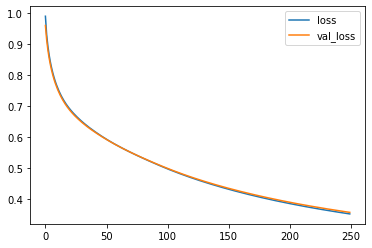

In [185]:
plt.plot(history.history['loss'], label ='loss')
plt.plot(history.history['val_loss'], label='val_loss')

plt.legend(loc="upper left")
plt.legend()

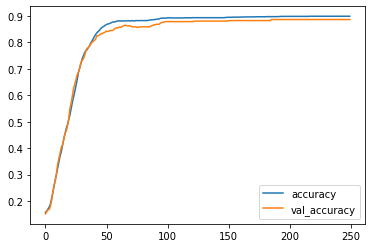

In [186]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')

plt.legend(loc="upper left")
plt.legend()

In [187]:
y_log = model.predict(X_test_scaled)

20/20 [==============================] - 0s 829us/step


In [188]:
y_pred = np.where(y_log > 0.5, 1, 0)

In [189]:
result_unbalanced = accuracy_score(y_test, y_pred)*100
print('%.2f' % result_unbalanced, "% accuracy")

88.89 % accuracy


In [212]:
#Print Train Accuracy
y_log = model.predict(X_train_scaled)
y_pred = np.where(y_log > 0.5, 1, 0)
slp_train_accuracy = metrics.accuracy_score(y_train, y_pred)*100
print("Training accuracy = ",slp_train_accuracy)
#Print Test Accuracy
y_log = model.predict(X_test_scaled)
y_pred = np.where(y_log > 0.5, 1, 0)
slp_test_accuracy = metrics.accuracy_score(y_test, y_pred)*100
print("Testing accuracy = ",slp_test_accuracy)

79/79 [==============================] - 0s 1ms/step
Training accuracy =  89.68253968253968
20/20 [==============================] - 0s 821us/step
Testing accuracy =  88.88888888888889


acc.append(result_unbalanced)
model.append('Single_Layer Perceptron')

## handling imbalanced dataset

In [51]:
from sklearn.utils import resample
# Separate majority and minority classes
majority_class = df[df['Churn'] == 0]
minority_class = df[df['Churn'] == 1]

# Upsample the minority class
upsampled_minority = resample(minority_class,
                              replace=True,  # Sample with replacement
                              n_samples=len(majority_class),  # Match the number of majority class samples
                              random_state=0)  # Set random state for reproducibility

# Combine the upsampled minority class with the majority class
balanced_data = pd.concat([majority_class, upsampled_minority])
balanced_data

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
0,8.0,0.0,38.0,0.0,4370.0,71.0,5.0,17.0,3.0,1.0,1.0,30.0,197.640,0.0
1,0.0,0.0,39.0,0.0,318.0,5.0,7.0,4.0,2.0,1.0,2.0,25.0,46.035,0.0
2,10.0,0.0,37.0,0.0,2453.0,60.0,359.0,24.0,3.0,1.0,1.0,30.0,1536.520,0.0
3,10.0,0.0,38.0,0.0,4198.0,66.0,1.0,35.0,1.0,1.0,1.0,15.0,240.020,0.0
4,3.0,0.0,38.0,0.0,2393.0,58.0,2.0,33.0,1.0,1.0,1.0,15.0,145.805,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,2.0,0.0,5.0,0.0,1408.0,17.0,0.0,3.0,3.0,1.0,1.0,30.0,57.000,1.0
2978,11.0,0.0,39.0,0.0,1148.0,19.0,15.0,4.0,3.0,1.0,2.0,30.0,106.680,1.0
2027,4.0,1.0,34.0,0.0,1963.0,38.0,27.0,29.0,3.0,1.0,2.0,30.0,188.040,1.0
949,0.0,0.0,8.0,0.0,777.0,8.0,0.0,7.0,3.0,1.0,1.0,30.0,31.400,1.0


0.0    2655
1.0    2655
Name: Churn, dtype: int64

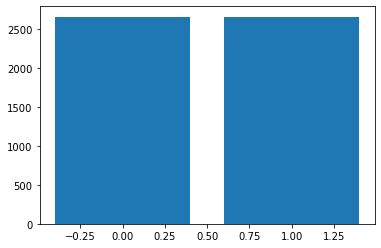

In [52]:
plt.bar(balanced_data['Churn'].unique(), balanced_data['Churn'].value_counts())
balanced_data.Churn.value_counts()

In [172]:
y = balanced_data['Churn']
X = balanced_data.drop('Churn',axis=1)

In [173]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [174]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [56]:
# check the shape of X_train & X_test, y_train & y_test
print("X_train Shape : ", X_train.shape)
print("X_test Shape : ", X_test.shape)
print("y_train Shape : ", y_train.shape)
print("y_test Shape : ", y_test.shape)

X_train Shape :  (4248, 13)
X_test Shape :  (1062, 13)
y_train Shape :  (4248,)
y_test Shape :  (1062,)


In [57]:
model = Sequential()
model.add(Dense(units=13, activation='relu', input_dim=13))
model.add(Dense(units=7, activation='relu', input_dim=7))
model.add(Dense(units=1, activation='sigmoid'))

history = model.compile(loss='binary_crossentropy', optimizer= keras.optimizers.Adagrad() , metrics='accuracy')
history = model.fit(X_train_scaled, y_train, epochs = 250, validation_split=0.2)

Epoch 1/250
107/107 [==============================] - 1s 2ms/step - loss: 0.6861 - accuracy: 0.4985 - val_loss: 0.6708 - val_accuracy: 0.4929
Epoch 2/250
107/107 [==============================] - 0s 1ms/step - loss: 0.6465 - accuracy: 0.5018 - val_loss: 0.6407 - val_accuracy: 0.5106
Epoch 3/250
107/107 [==============================] - 0s 1ms/step - loss: 0.6220 - accuracy: 0.5297 - val_loss: 0.6195 - val_accuracy: 0.5435
Epoch 4/250
107/107 [==============================] - 0s 1ms/step - loss: 0.6039 - accuracy: 0.5506 - val_loss: 0.6028 - val_accuracy: 0.5518
Epoch 5/250
107/107 [==============================] - 0s 1ms/step - loss: 0.5894 - accuracy: 0.5912 - val_loss: 0.5891 - val_accuracy: 0.6071
Epoch 6/250
107/107 [==============================] - 0s 1ms/step - loss: 0.5772 - accuracy: 0.6286 - val_loss: 0.5775 - val_accuracy: 0.6353
Epoch 7/250
107/107 [==============================] - 0s 1ms/step - loss: 0.5667 - accuracy: 0.6536 - val_loss: 0.5674 - val_accuracy: 0.6682

Epoch 58/250
107/107 [==============================] - 0s 2ms/step - loss: 0.4056 - accuracy: 0.8470 - val_loss: 0.4125 - val_accuracy: 0.8424
Epoch 59/250
107/107 [==============================] - 0s 3ms/step - loss: 0.4043 - accuracy: 0.8470 - val_loss: 0.4113 - val_accuracy: 0.8424
Epoch 60/250
107/107 [==============================] - 0s 2ms/step - loss: 0.4031 - accuracy: 0.8481 - val_loss: 0.4101 - val_accuracy: 0.8424
Epoch 61/250
107/107 [==============================] - 0s 2ms/step - loss: 0.4019 - accuracy: 0.8493 - val_loss: 0.4090 - val_accuracy: 0.8424
Epoch 62/250
107/107 [==============================] - 0s 2ms/step - loss: 0.4007 - accuracy: 0.8496 - val_loss: 0.4079 - val_accuracy: 0.8435
Epoch 63/250
107/107 [==============================] - 0s 2ms/step - loss: 0.3995 - accuracy: 0.8514 - val_loss: 0.4067 - val_accuracy: 0.8435
Epoch 64/250
107/107 [==============================] - 0s 2ms/step - loss: 0.3984 - accuracy: 0.8520 - val_loss: 0.4057 - val_accuracy:

Epoch 115/250
107/107 [==============================] - 0s 2ms/step - loss: 0.3589 - accuracy: 0.8693 - val_loss: 0.3681 - val_accuracy: 0.8659
Epoch 116/250
107/107 [==============================] - 0s 2ms/step - loss: 0.3583 - accuracy: 0.8696 - val_loss: 0.3676 - val_accuracy: 0.8659
Epoch 117/250
107/107 [==============================] - 0s 2ms/step - loss: 0.3578 - accuracy: 0.8696 - val_loss: 0.3671 - val_accuracy: 0.8659
Epoch 118/250
107/107 [==============================] - 0s 2ms/step - loss: 0.3573 - accuracy: 0.8696 - val_loss: 0.3666 - val_accuracy: 0.8659
Epoch 119/250
107/107 [==============================] - 0s 1ms/step - loss: 0.3568 - accuracy: 0.8696 - val_loss: 0.3661 - val_accuracy: 0.8659
Epoch 120/250
107/107 [==============================] - 0s 2ms/step - loss: 0.3562 - accuracy: 0.8696 - val_loss: 0.3656 - val_accuracy: 0.8659
Epoch 121/250
107/107 [==============================] - 0s 2ms/step - loss: 0.3557 - accuracy: 0.8696 - val_loss: 0.3651 - val_ac

107/107 [==============================] - 0s 2ms/step - loss: 0.3357 - accuracy: 0.8717 - val_loss: 0.3464 - val_accuracy: 0.8682
Epoch 172/250
107/107 [==============================] - 0s 2ms/step - loss: 0.3354 - accuracy: 0.8717 - val_loss: 0.3461 - val_accuracy: 0.8682
Epoch 173/250
107/107 [==============================] - 0s 2ms/step - loss: 0.3350 - accuracy: 0.8720 - val_loss: 0.3458 - val_accuracy: 0.8706
Epoch 174/250
107/107 [==============================] - 0s 1ms/step - loss: 0.3347 - accuracy: 0.8720 - val_loss: 0.3455 - val_accuracy: 0.8706
Epoch 175/250
107/107 [==============================] - 0s 1ms/step - loss: 0.3344 - accuracy: 0.8720 - val_loss: 0.3452 - val_accuracy: 0.8706
Epoch 176/250
107/107 [==============================] - 0s 1ms/step - loss: 0.3341 - accuracy: 0.8720 - val_loss: 0.3449 - val_accuracy: 0.8706
Epoch 177/250
107/107 [==============================] - 0s 2ms/step - loss: 0.3338 - accuracy: 0.8723 - val_loss: 0.3446 - val_accuracy: 0.8706

107/107 [==============================] - 0s 1ms/step - loss: 0.3201 - accuracy: 0.8808 - val_loss: 0.3322 - val_accuracy: 0.8753
Epoch 228/250
107/107 [==============================] - 0s 1ms/step - loss: 0.3199 - accuracy: 0.8808 - val_loss: 0.3320 - val_accuracy: 0.8753
Epoch 229/250
107/107 [==============================] - 0s 1ms/step - loss: 0.3197 - accuracy: 0.8808 - val_loss: 0.3318 - val_accuracy: 0.8753
Epoch 230/250
107/107 [==============================] - 0s 2ms/step - loss: 0.3194 - accuracy: 0.8808 - val_loss: 0.3316 - val_accuracy: 0.8753
Epoch 231/250
107/107 [==============================] - 0s 2ms/step - loss: 0.3192 - accuracy: 0.8808 - val_loss: 0.3314 - val_accuracy: 0.8753
Epoch 232/250
107/107 [==============================] - 0s 1ms/step - loss: 0.3190 - accuracy: 0.8808 - val_loss: 0.3312 - val_accuracy: 0.8753
Epoch 233/250
107/107 [==============================] - 0s 2ms/step - loss: 0.3188 - accuracy: 0.8808 - val_loss: 0.3310 - val_accuracy: 0.8753

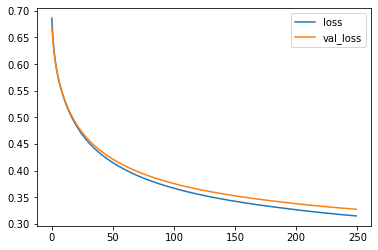

In [58]:
plt.plot(history.history['loss'], label ='loss')
plt.plot(history.history['val_loss'], label='val_loss')

plt.legend(loc="upper left")
plt.legend()

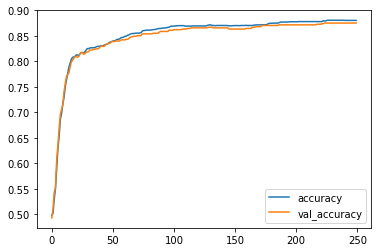

In [59]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')

plt.legend(loc="upper left")
plt.legend()

In [60]:
y_log = model.predict(X_test_scaled)
y_pred = np.where(y_log > 0.5, 1, 0)
result_balanced = accuracy_score(y_test, y_pred)*100
print('%.2f' % result_balanced, "% accuracy")

34/34 [==============================] - 0s 828us/step
88.23 % accuracy


## ML Algorithms Modelling

In [111]:
acc = []
model = []

In [112]:
acc.append(result_unbalanced)
model.append('Single-layer Perceptron')

In [113]:
from sklearn.metrics import classification_report , confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb

In [114]:
y = df['Churn']
X = df.drop('Churn',axis=1)

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

## Logistic Regression (LR)

In [116]:
# Initialising Logistic regression model and generating a prediction
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

# Generating prediction
predicted_values = logreg.predict(X_test)

x = metrics.accuracy_score(y_test, predicted_values)

In [117]:
print("Logistic Regression's Accuracy is: ", x , "%")
print(" ")
print(classification_report(y_test,predicted_values))

Logistic Regression's Accuracy is:  0.846031746031746 %
 
              precision    recall  f1-score   support

         0.0       0.85      0.98      0.91       521
         1.0       0.69      0.20      0.31       109

    accuracy                           0.85       630
   macro avg       0.77      0.59      0.61       630
weighted avg       0.83      0.85      0.81       630



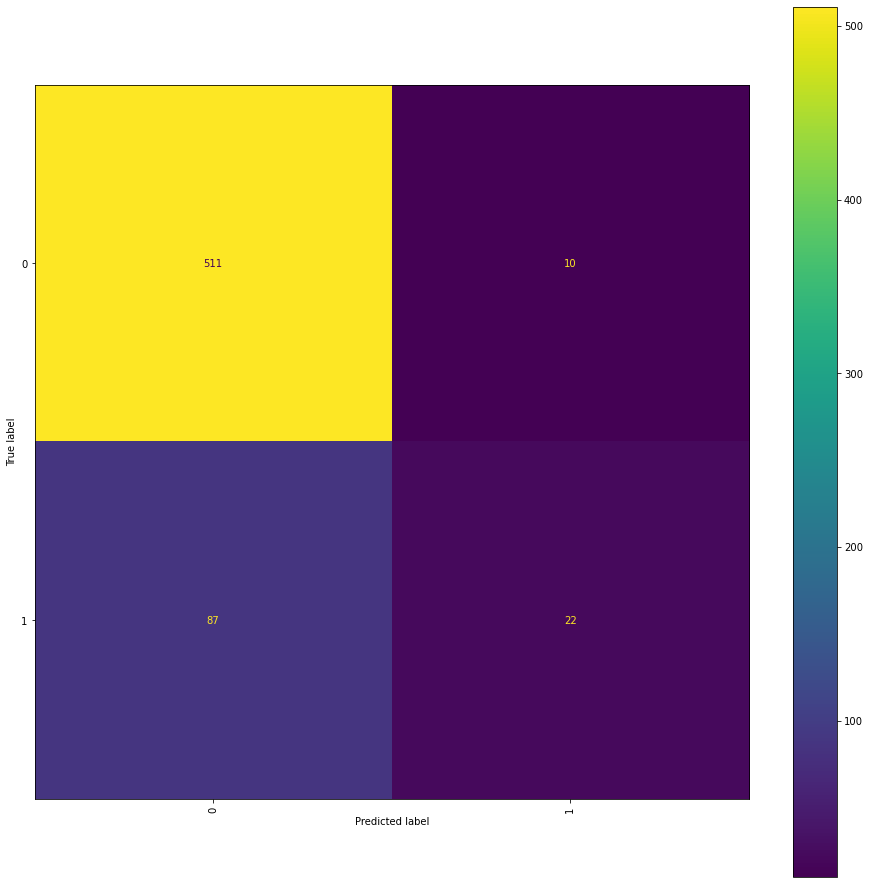

In [118]:
# list of the crop labels
crop_list = data['Churn'].unique()

# Confusion matrix for logistic regression model
cm = confusion_matrix(y_test, predicted_values)
cmp = ConfusionMatrixDisplay(cm, display_labels=crop_list)
fig, ax = plt.subplots(figsize=(16,16))

cmp.plot(ax=ax)

plt.xticks(rotation = 90)
print(" ")

In [119]:
# Cross validation score (Logistic Regression)
score = cross_val_score(logreg, X, y, cv=5)
print('Cross validation score: ',score)

Cross validation score:  [0.84444444 0.84761905 0.84603175 0.85555556 0.86031746]


In [120]:
score.mean()

0.8507936507936508

In [121]:
#Print Train Accuracy
lr_train_accuracy = metrics.accuracy_score(y_train, logreg.predict(X_train))
print("Training accuracy = ",metrics.accuracy_score(y_train, logreg.predict(X_train)))
#Print Test Accuracy
lr_test_accuracy = metrics.accuracy_score(y_test, logreg.predict(X_test))
print("Testing accuracy = ",metrics.accuracy_score(y_test, logreg.predict(X_test)))

Training accuracy =  0.8555555555555555
Testing accuracy =  0.846031746031746


## Optimizing Logistic Regression Model

In [122]:
# initialising lists of hyperparameters to test for the optimal settings
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
penalty = ['none','l1','l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

In [123]:
# Using GridSearchCV to test for hyperparameter setting
grid = dict(solver=solvers,penalty=penalty,C=c_values)
grid_search = GridSearchCV(estimator=logreg, param_grid=grid, n_jobs=-1, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, y)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy

/home/hduser/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/hduser/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/hduser/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/hduser/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/hduser/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/hduser/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:35

/home/hduser/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/hduser/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/hduser/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/hduser/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/hduser/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/hduser/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:35

/home/hduser/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/hduser/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [124]:
# Printing out the optimal hyperparameters
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

Best: 0.893968 using {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


In [125]:
# Initialise logreg model with optimised hyperparameters & fitting the data
logreg = LogisticRegression(C=0.1, penalty='l1', solver='liblinear')
logreg.fit(X_train, y_train)

# Generating prediction
predicted_values = logreg.predict(X_test)

# Storing the accuracy score to be used later in model comparison
x = metrics.accuracy_score(y_test, predicted_values)*100
acc.append(x)
model.append('Logistic Regression')

x

88.09523809523809

              precision    recall  f1-score   support

         0.0       0.89      0.98      0.93       521
         1.0       0.81      0.40      0.54       109

    accuracy                           0.88       630
   macro avg       0.85      0.69      0.74       630
weighted avg       0.87      0.88      0.86       630

AxesSubplot(0.125,0.125;0.775x0.755)


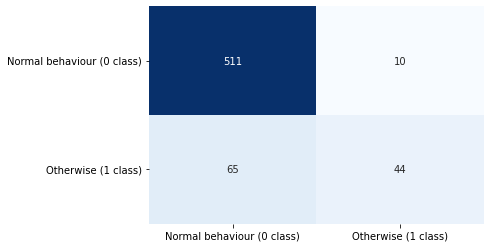

In [126]:
print(classification_report(y_test, predicted_values))
print(sns.heatmap(confusion_matrix(y_test, predicted_values), annot=True, fmt='.4g',                 
                 xticklabels=['Normal behaviour (0 class)','Otherwise (1 class)'],                
                 yticklabels=['Normal behaviour (0 class)','Otherwise (1 class)'],                  
                 cbar=False, cmap='Blues'))

In [127]:
#Print Train Accuracy
lr_train_accuracy = metrics.accuracy_score(y_train, logreg.predict(X_train))
print("Training accuracy = ",metrics.accuracy_score(y_train, logreg.predict(X_train)))
#Print Test Accuracy
lr_test_accuracy = metrics.accuracy_score(y_test, logreg.predict(X_test))
print("Testing accuracy = ",metrics.accuracy_score(y_test, logreg.predict(X_test)))

Training accuracy =  0.8960317460317461
Testing accuracy =  0.8809523809523809


In [128]:
# Performing Cross validation
# Cross validation score (Logistic Regression)
score = cross_val_score(logreg, X, y, cv=5)
print('Cross validation score: ',score)

Cross validation score:  [0.9047619  0.87777778 0.89365079 0.89365079 0.9       ]


In [129]:
# Mean accuracy score
score.mean()

0.893968253968254

## Support Vector Machine (SVM)

In [130]:
SVM = SVC(gamma='auto')

SVM.fit(X_train,y_train)

predicted_values = SVM.predict(X_test)

x = metrics.accuracy_score(y_test, predicted_values)*100
acc.append(x)
model.append('SVM')

In [131]:
print(" ")
print("SVM's Accuracy is: ", x)
print(" ")
print(classification_report(y_test,predicted_values))

 
SVM's Accuracy is:  85.39682539682539
 
              precision    recall  f1-score   support

         0.0       0.85      0.99      0.92       521
         1.0       0.84      0.19      0.31       109

    accuracy                           0.85       630
   macro avg       0.85      0.59      0.62       630
weighted avg       0.85      0.85      0.81       630



In [132]:
# Cross validation score (SVM)
score = cross_val_score(SVM, X, y,cv=5)
print('Cross validation score: ',score)

Cross validation score:  [0.86507937 0.88253968 0.85079365 0.87619048 0.87460317]


In [133]:
score.mean()

0.86984126984127

In [134]:
#Print Train Accuracy
SVM_train_accuracy = metrics.accuracy_score(y_train, SVM.predict(X_train))
print("Training accuracy = ",metrics.accuracy_score(y_train, SVM.predict(X_train)))
#Print Test Accuracy
SVM_test_accuracy = metrics.accuracy_score(y_test, SVM.predict(X_test))
print("Testing accuracy = ",metrics.accuracy_score(y_test, SVM.predict(X_test)))

Training accuracy =  0.9857142857142858
Testing accuracy =  0.8539682539682539


## Random Forest Classifier (RF)

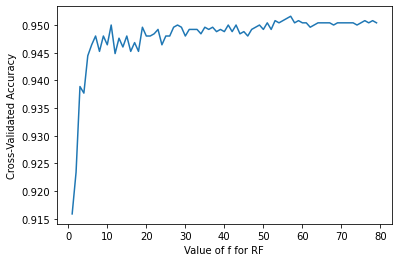

57


In [135]:
# Using a similar approach to logistic regrestion, I will run multiple tests to find the optimal n_estimator value
# Random_state= 0 is used to maintain continuity of results across multiple runs
rf_range = range(1, 80)
rf_scores = []
rf_max = 0
rf_max_score = 0

for f in rf_range:
    RF = RandomForestClassifier(n_estimators=f, random_state=0)
    scores = cross_val_score(RF, X_train, y_train, scoring='accuracy')
    rf_scores.append(scores.mean())
    if scores.mean() > rf_max_score:
        rf_max = f
        rf_max_score = scores.mean()

plt.plot(rf_range, rf_scores)
plt.xlabel('Value of f for RF')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

print(rf_max)

In [136]:
RF = RandomForestClassifier(n_estimators=57, random_state=0)
RF.fit(X_train, y_train)

predicted_values = RF.predict(X_test)

x = metrics.accuracy_score(y_test, predicted_values)*100
acc.append(x)
model.append('Random Forest')

              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97       521
         1.0       0.89      0.78      0.83       109

    accuracy                           0.95       630
   macro avg       0.92      0.88      0.90       630
weighted avg       0.94      0.95      0.94       630



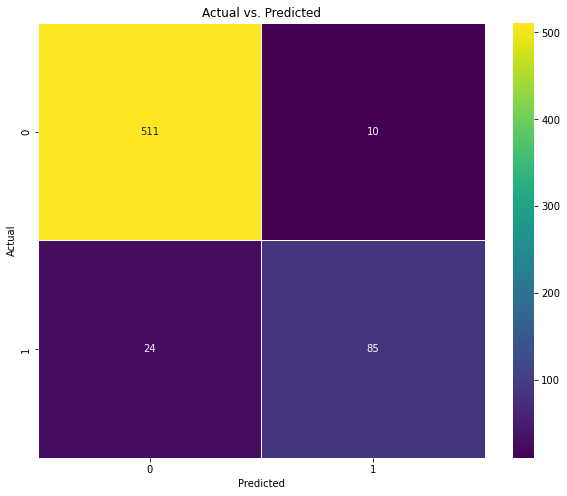

In [137]:
# Classification report and breakdown
print(classification_report( y_test,predicted_values))

y_pred = RF.predict(X_test)
y_true = y_test

cm_RF = confusion_matrix(y_true,y_pred)

f, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cm_RF, annot=True, linewidth=0.5, fmt=".0f",cmap='viridis', ax = ax)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Actual vs. Predicted')
plt.show()

In [138]:
# Storing the accuracy values for model results comparison later

#Print Train Accuracy
rf_train_accuracy = metrics.accuracy_score(y_train, RF.predict(X_train))
print("Training accuracy = ",metrics.accuracy_score(y_train, RF.predict(X_train)))

#Print Test Accuracy
rf_test_accuracy = metrics.accuracy_score(y_test, RF.predict(X_test))
print("Testing accuracy = ",metrics.accuracy_score(y_test, RF.predict(X_test)))

Training accuracy =  0.9920634920634921
Testing accuracy =  0.946031746031746


In [139]:
# Cross validation on dataset
score = cross_val_score(RF, X, y, cv=5)
print('Cross validation score: ',score)

Cross validation score:  [0.95079365 0.96031746 0.94444444 0.95873016 0.95396825]


In [140]:
# Mean score
score.mean()

0.9536507936507936

## AdaBoost Classifier

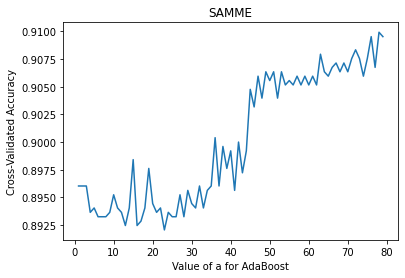

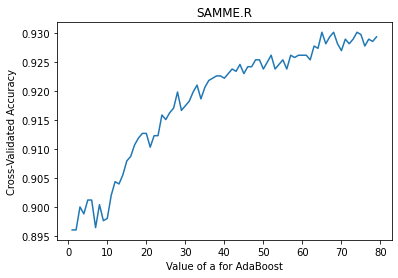

65 SAMME.R


In [141]:
ada_range = range(1, 80)
ada_scores_SAMME = []
ada_scores_SAMME_R = []
ada_max = 0
ada_max_score = 0
algorithm_max = 0

algorithm = ['SAMME', 'SAMME.R']

for a in ada_range:
    for algo in range(len(algorithm)):
        ada = AdaBoostClassifier(n_estimators=a, algorithm= algorithm[algo], random_state=0)
        scores = cross_val_score(ada, X_train, y_train, scoring='accuracy')
        if algo == 0:
            ada_scores_SAMME.append(scores.mean())
        else:
            ada_scores_SAMME_R.append(scores.mean())
        if scores.mean() > ada_max_score:
            ada_max = a
            ada_max_score = scores.mean()
            algorithm_max = algorithm[algo]

plt.plot(ada_range, ada_scores_SAMME)
plt.xlabel('Value of a for AdaBoost')
plt.ylabel('Cross-Validated Accuracy')
plt.title('SAMME')
plt.show()

plt.plot(ada_range, ada_scores_SAMME_R)
plt.xlabel('Value of a for AdaBoost')
plt.ylabel('Cross-Validated Accuracy')
plt.title('SAMME.R')
plt.show()

print(ada_max, algorithm_max)

## Runnig Optimized AdaBoost

In [142]:
ada = AdaBoostClassifier(n_estimators=65, algorithm="SAMME.R", random_state=0)
ada.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=65, random_state=0)

In [143]:
predicted_values = ada.predict(X_test)

In [144]:
x = metrics.accuracy_score(y_test, predicted_values) * 100
acc.append(x)
model.append('AdaBoost')
x

93.4920634920635

              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96       521
         1.0       0.85      0.75      0.80       109

    accuracy                           0.93       630
   macro avg       0.90      0.86      0.88       630
weighted avg       0.93      0.93      0.93       630



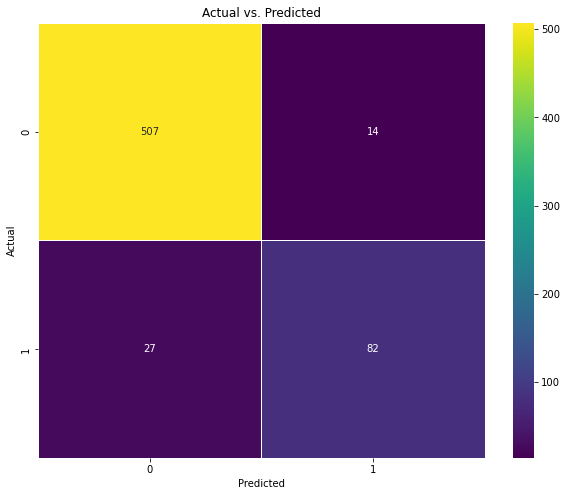

In [145]:
# Classification report and breakdown
print(classification_report(y_test,predicted_values))

y_pred = ada.predict(X_test)
y_true = y_test

cm_Ada = confusion_matrix(y_true,y_pred)

f, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cm_Ada, annot=True, linewidth=0.5, fmt=".0f",cmap='viridis', ax = ax)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Actual vs. Predicted')
plt.show()

In [146]:
# Storing the accuracy values for model results comparison later

#Print Train Accuracy
ada_train_accuracy = metrics.accuracy_score(y_train, ada.predict(X_train))
print("Training accuracy = ",metrics.accuracy_score(y_train, ada.predict(X_train)))

#Print Test Accuracy
ada_test_accuracy = metrics.accuracy_score(y_test, ada.predict(X_test))
print("Testing accuracy = ",metrics.accuracy_score(y_test, ada.predict(X_test)))

Training accuracy =  0.944047619047619
Testing accuracy =  0.9349206349206349


In [147]:
# Cross validation on dataset
score = cross_val_score(ada, X, y, cv=5)
print('Cross validation score: ',score)

Cross validation score:  [0.93015873 0.93174603 0.91587302 0.92698413 0.92539683]


In [148]:
# Mean score
score.mean()

0.9260317460317461

## XGBoost Classifier

In [149]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [150]:
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=0)

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=42, n_iter=200, cv=5, verbose=1, n_jobs=1, return_train_score=True)

search.fit(X_train, y_train)

report_best_scores(search.cv_results_, 1)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Model with rank: 1
Mean validation score: 0.957 (std: 0.007)
Parameters: {'colsample_bytree': 0.8167605036202489, 'gamma': 0.00541882574014918, 'learning_rate': 0.3016145929257791, 'max_depth': 5, 'n_estimators': 108, 'subsample': 0.7277254550361659}



In [151]:
report_best_scores(search.cv_results_, 1)

Model with rank: 1
Mean validation score: 0.957 (std: 0.007)
Parameters: {'colsample_bytree': 0.8167605036202489, 'gamma': 0.00541882574014918, 'learning_rate': 0.3016145929257791, 'max_depth': 5, 'n_estimators': 108, 'subsample': 0.7277254550361659}



In [152]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=0, colsample_bytree=0.81676, gamma = 0.005419, learning_rate = 0.3016145, max_depth = 5, n_estimators = 108, subsample = 0.7277)
xgb_model.fit(X_train, y_train)

predicted_values = xgb_model.predict(X_test)


In [153]:
x = metrics.accuracy_score(y_test, predicted_values) * 100
acc.append(x)
model.append('XGBoost')
x

95.23809523809523

              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97       521
         1.0       0.91      0.81      0.85       109

    accuracy                           0.95       630
   macro avg       0.93      0.90      0.91       630
weighted avg       0.95      0.95      0.95       630



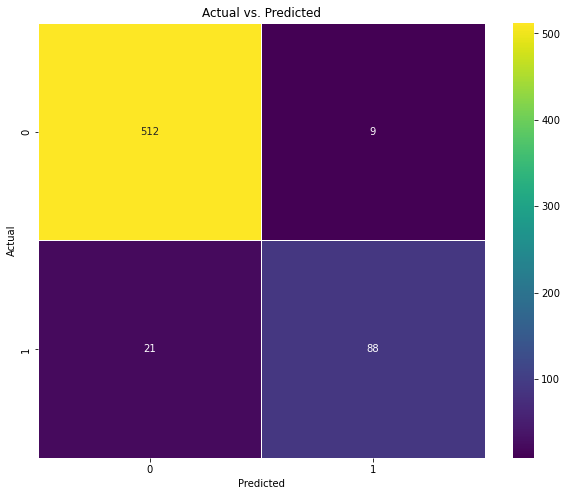

In [154]:
# Classification report and breakdown
print(classification_report(y_test,predicted_values))

y_pred = xgb_model.predict(X_test)
y_true = y_test

cm_XGB = confusion_matrix(y_true,y_pred)

f, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cm_XGB, annot=True, linewidth=0.5, fmt=".0f",cmap='viridis', ax = ax)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Actual vs. Predicted')
plt.show()

In [155]:
# Storing the accuracy values for model results comparison later

#Print Train Accuracy
xgb_train_accuracy = metrics.accuracy_score(y_train, xgb_model.predict(X_train))
print("Training accuracy = ",metrics.accuracy_score(y_train, xgb_model.predict(X_train)))

#Print Test Accuracy
xgb_test_accuracy = metrics.accuracy_score(y_test, xgb_model.predict(X_test))
print("Testing accuracy = ",metrics.accuracy_score(y_test, xgb_model.predict(X_test)))

Training accuracy =  0.9912698412698413
Testing accuracy =  0.9523809523809523


In [156]:
# Cross validation on dataset
score = cross_val_score(ada, X, y, cv=5)
print('Cross validation score: ',score)

Cross validation score:  [0.93015873 0.93174603 0.91587302 0.92698413 0.92539683]


In [157]:
# Mean score
score.mean()

0.9260317460317461

## Model Comparison

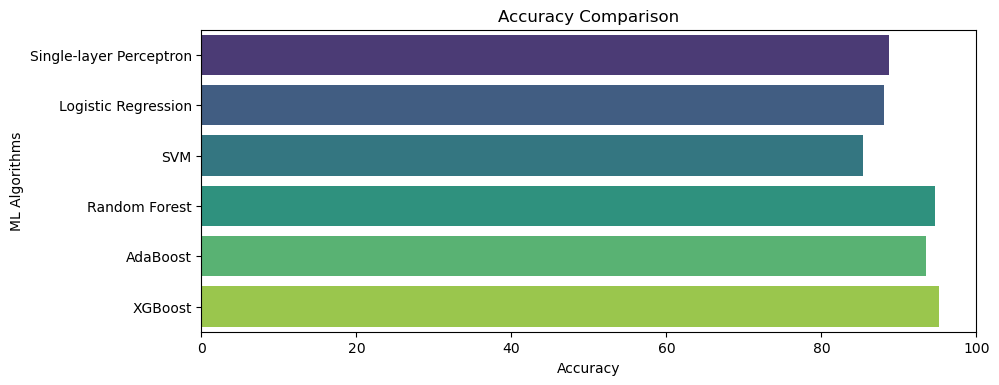

In [158]:
plt.figure(figsize=[10,4],dpi = 100, facecolor='white')
plt.title('Accuracy Comparison')
plt.xlabel('Accuracy')
plt.ylabel('ML Algorithms')
sns.barplot(x = acc,y = model,palette='viridis')
print(" ")

In [159]:
acc

[88.73015873015872,
 88.09523809523809,
 85.39682539682539,
 94.6031746031746,
 93.4920634920635,
 95.23809523809523]

In [160]:
model

['Single-layer Perceptron',
 'Logistic Regression',
 'SVM',
 'Random Forest',
 'AdaBoost',
 'XGBoost']

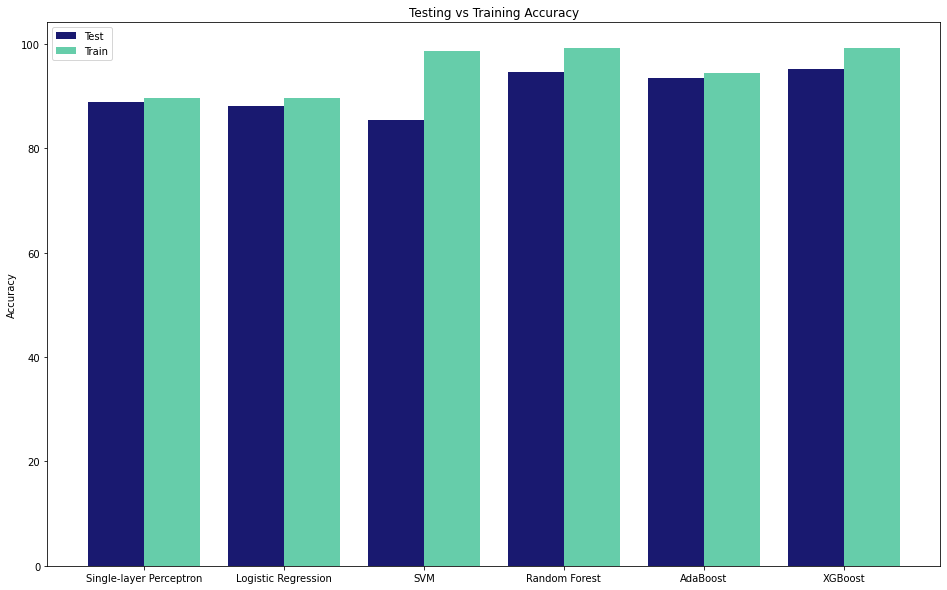

In [216]:
label = ['Single-layer Perceptron', 'Logistic Regression', 'SVM', 'Random Forest', 'AdaBoost', 'XGBoost']
Test = [slp_test_accuracy, lr_test_accuracy*100, SVM_test_accuracy*100, rf_test_accuracy*100, ada_test_accuracy*100, xgb_test_accuracy*100]
Train = [slp_train_accuracy, lr_train_accuracy*100, SVM_train_accuracy*100, rf_train_accuracy*100, ada_train_accuracy*100, xgb_train_accuracy*100]

f, ax = plt.subplots(figsize=(16,10)) 
X_axis = np.arange(len(label))
plt.bar(X_axis - 0.2,Test, 0.4, label = 'Test', color=('midnightblue'))
plt.bar(X_axis + 0.2,Train, 0.4, label = 'Train', color=('mediumaquamarine'))

plt.xticks(X_axis, label)
plt.ylabel("Accuracy")
plt.title("Testing vs Training Accuracy")
plt.legend()
plt.show()